# Community Water System Prediction Model

**Overview**  
The [Division of Drinking Water](https://www.waterboards.ca.gov/drinking_water/programs/) (DDW) at the [California State Water Resources Control Board](https://www.waterboards.ca.gov/) regulates Community Water Systems (CWS) throughout the state. Some of these CWS risk running out of water during the dry summer season.

Here we develop a machine learning model that predicts which CWS face the highest risk of running out of water. The model architecture is a Support Vector Machine, from the open source scientific software package [scikit-learn](https://scikit-learn.org/stable/). The model is intended to run in production on an annual basis, during April of every year.

The dataset used to train and test the model comprises of 5772 examples that describe 2886 CWS over a span of two years, from 2021 to 2023. We use 15 features and one outcome label to describe each example. The outcome label itself is a composite, consisting of three separate conditions that a CWS may experience: reliance on bottled or hauled water, receipt of a drought violation, or contention of a curtailment. We define a CWS that experiences any one, or multiple, of these conditions, as `DroughtExperienced`. We define a CWS that experiences none of these conditions as not `DroughtExperienced.`

**Features**  
The features in the dataset span various time scales, and some remain static over time. The following table describes each feature and its associated timescale.

Feature | Description | Timescale
---|---|---
DSCI Dry Season Average| The [US Drought Monitor Data](https://droughtmonitor.unl.edu/) database creates a weighted blend of multiple observational data (precipitation, streamflow, reservoir levels, temperature and evaporative demand, soil moisture, vegetation health) into an index called the Drought Severity and Coverage Index (DSCI). This feature takes the average value of the DSCI during the dry season, which spans from May 1 to September 30 in any given calendar year. | Seasonal (October 1 - April 1)
DSCI Wet Season Average| This feature takes the average value of the DSCI during the wet season, which spans from October 1 in a given calendar year to April 1 in the following year. | Seasonal (May 1 - September 30)
DSCI Dry Wet Delta| This feature takes the difference of the average value of the DSCI during the dry season and wet season. The data that goes into this calculation spans 11 months, from May 1 in a given calendar year to April 1 in the following year. | Seasonal (May 1 - April 1)
Total Number of Water Sources| As defined in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 74): "Total number of available water sources including surface water, wells, and imported/purchased water." | We use this annually, but it is available quarterly via SAFER.
Intertie| As defined in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 76): "An intertie or interconnection is a connection between one or more water systems where systems can either supply or receive water from each other. The presence of interties is assumed to reduce the risk of a water outage by allowing water systems to switch sources and even governance structure support, if needed." If the CWS is not connected to any other water systems, this value is zero. Otherwise it is one. | We use this annually, but it is available quarterly via SAFER.
Score_CriticallyOverdraftedGroundwaterBasin| This indicates whether the CWS is located within a critically overdrafted groundwater basin. According to in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 80): "A basin is subject to critical conditions of overdraft when continuation of current water management practices would probably result in significant adverse overdraft-related environmental, social, or economic impacts." Per table A30, this value equals 0 if fewer than 25% of system’s wells reside in such a basin and 1 otherwise. | We use this annually, but it is available quarterly via SAFER.
Score_SCV| According to in the [SAFER 2023 Annual Report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf) (pp. 82): "The purpose of this risk indicator is to identify water systems that have violated source capacity standards as required in California Waterworks Standards82 within the last three years." If this is true, the value of Score_SCV equals 1. Otherwise it is 0. | We use this annually, but it is available quarterly via SAFER. This feature describes the last three years of behavior.
Score_SCM| This risk indicator identifies whether a water system experienced a service connection moratorium within the last three years. | Annual. This feature describes the last three years of behavior.
Curtailment| Whether the CWS experienced a curtailment within the calendar year. | Annual
ServiceConnections| The number of service connections to a CWS. | Annual
PWPhysicalAddressLat| The latitude of the CWS. | Static
PWPhysicalAddressLong| The longitude of the CWS. | Static
HUC_Categories| Whether the CWS is located in a coastal region (1), the central valley (2), or some other region (3). | Static
Population| The population served by a given CWS. | Static
Wholesalers| The number of wholesale CWS. These CWS do not serve anybody directly, but serve other CWS -- which in turn, serve people directly. | Static

**Label**  
The labels in the dataset span various time scales. The following table describes each label and its associated timescale.

Label | Description | Timescale
---|---|---
WaterOutageDroughtViolation| Describes wether (0) or not (1) the system experienced a water outage violation in the last year. | Annual
BottledHauledWaterOrZeroSource| "The purpose of this risk indicator is to identify water systems that have had to supplement or replace their source of supply to meet customer demand with bottled water, and/or hauled water at any point within the past three years." | We use this annually, but it is available quarterly via SAFER. This feature describes the last three years of behavior.
CurtailmentExemptionPetition|  Describes wether (0) or not (1) the system petitioned a curtailment in the last year.| Annual

**Resources**  
* A [searchable website](https://sdwis.waterboards.ca.gov/PDWW/) of community water systems
* A [searchable map](https://gispublic.waterboards.ca.gov/portal/apps/webappviewer/index.html?id=272351aa7db14435989647a86e6d3ad8) of community water systems

In [1]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
import time
import pydotplus
from datetime import datetime as dt_obj
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import dice_ml

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 3000)

/Users/monica.bobra/anaconda3/envs/water/lib/python3.10/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.


### Create 2021 Data

The initial data set provided by the DDW include two csv files that contain data from 2020 and 2021: `DroughtWatchPrioritization_v4.csv` and 
`DroughtWatchPrioritization_v9_input_data_with_TNC.csv`.  The files provide a list of CWS, various parameters that describe the CWS, and the outcome of each CWS at the end of 2021 via the label `DroughtExperienced`. If `DroughtExperienced` equals 1, a CWS ran out of water; otherwise, the system was safe.

In [2]:
BUCKET_NAME = 'aae-water-dev-us-west-2'

In [3]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
water_bucket = s3.Bucket(BUCKET_NAME)

In [4]:
def get_data_from_s3(filename):
    for water_bucket_object in water_bucket.objects.all():
        response = s3_client.get_object(Bucket=BUCKET_NAME, Key=filename)
        status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
        print('Status equals {}, getting {}.'.format(status, filename))
        if status == 200:
            df = pd.read_csv(response.get("Body"))
            return(df)

Read in the initial data sets:

In [5]:
df1 = get_data_from_s3(filename='DroughtWatchPrioritization_v4.csv')
df2 = get_data_from_s3(filename='DroughtWatchPrioritization_v9_input_data_with_TNC.csv')

Status equals 200, getting DroughtWatchPrioritization_v4.csv.
Status equals 200, getting DroughtWatchPrioritization_v9_input_data_with_TNC.csv.


The keyword `PWPhysicalAddressLat` in one dataframe is the same as `Lat` in other other; same with longitude. Rename these keywords.

In [6]:
df2 = df2.rename(columns={"Lat": "PWPhysicalAddressLat", "Long": "PWPhysicalAddressLong"})

Merge the two dataframes using these keys: `ServiceConnections`, `Population`, `CDAG_rank`, and `Lat`. The ideal solution is to merge on the unique identifier, `CWSID`. However, `CWSID` is not present in both files.

In [7]:
df_2021_initial = df1.merge(df2, on=['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat'])

Remove the '-' character from the HUC8 values to make them consistent with other datasets.

In [8]:
df_2021_initial['HUC8'] = df_2021_initial['HUC8'].str.replace("-", "").astype(int)

Add a column called `Water Year` and set the the values to 2021:

In [9]:
df_2021_initial['Water Year'] = 2021

#### A. Add [US Drought Monitor Data](https://droughtmonitor.unl.edu/)

The US Drought Monitor Database creates a weighted blend of multiple observational data (precipitation, streamflow, reservoir levels, temperature and evaporative demand, soil moisture, vegetation health) into an index called the Drought Severity and Coverage Index (DSCI). These data are available on a weekly cadence from 2000 until the present day.

**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain DSCI data per HUC8 code per unit time.** 
* The [US Drought Monitor Index](https://droughtmonitor.unl.edu/) provides several drought-related datasets. These data are available through a REST API. 
* Construct the URL for the REST API. The query terms are: 
  * `[area]` = `HUCStatistics`
  * `[statistics type]` = `GetDroughtSeverityStatisticsByAreaPercent` (Note: One could use `GetDSCI`, but this will not return HUC8 codes as a key)
  * `[aoi]` = Any given HUC8 code, e.g. 15040004
  * `[start date]` = 01/01/2021
  * `[end date]` = 01/01/2022
  * `[statistics type]` = 2. (Note: This is a different keyword from the first statistics type. A statistics type of 2 refers to categorical statistics).
* Here is an example URL: url_dsci = `https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi=15040004&startdate=1/2/2021&enddate=12/27/2021&statisticsType=2`

**Step 3: Calculate the Drought Severity and Coverage Index (DSCI).** Compute a weighted sum of the categorical percent area as described [here](https://droughtmonitor.unl.edu/About/AbouttheData/DSCI.aspx): DSCI = 1(D0) + 2(D1) + 3(D2) + 4(D3) + 5(D4)

Note: As of Monday, July 17 2023, the USDM Rest API is down. I have downloaded all the relevant data from the [comprehensive statistics](https://droughtmonitor.unl.edu/DmData/DataDownload/ComprehensiveStatistics.aspx) page for use temporarily. 

* Select all HUC8 codes that start with 15, 16, 17, and 18.
* Select Statistics Type = Categorical.

Step 1:

In [10]:
url_huc8 = 'https://gis.data.cnra.ca.gov/datasets/02ff4971b8084ca593309036fb72289c_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'

In [11]:
df_huc8 = pd.read_csv(url_huc8)

In [12]:
# Define the dry seasons
dry_seasons_start = [dt_obj.fromisoformat('2022-05-01'), dt_obj.fromisoformat('2021-05-01')]
dry_seasons_end = [dt_obj.fromisoformat('2022-09-30'), dt_obj.fromisoformat('2021-09-30')]

# Define the wet seasons
wet_seasons_start = [dt_obj.fromisoformat('2022-10-01'), dt_obj.fromisoformat('2021-10-01')]
wet_seasons_end = [dt_obj.fromisoformat('2023-04-01'), dt_obj.fromisoformat('2022-04-01')]

Complete Steps 2 and 3:

In [13]:
df_dsci = get_data_from_s3(filename='DSCI.csv')

Status equals 200, getting DSCI.csv.


In [14]:
if len(df_dsci[df_dsci['HUCId'] == 15030102].reset_index()) == 0:
    print("empty")

In [15]:
all_huc_ids = []
all_average_dscis_dry_season = []
all_average_dscis_wet_season = []
all_delta_dscis = []
years_average_dscis_dry_season = []
years_average_dscis_wet_season = []
years_delta_dscis = []
for i in range(len(df_huc8['HUC8'])):
    # Get an individual HUC8 region in California
    one_huc8_code = df_huc8['HUC8'][i]
    df_one_huc = df_dsci[df_dsci['HUCId'] == one_huc8_code].reset_index()
    if len(df_one_huc) == 0:
        print('Empty data for HUC8 region',one_huc8_code, df_huc8['Name'][i])
    else:
        print('Reading data for HUC8 region',one_huc8_code, df_huc8['Name'][i])
        # Convert the keyword MapDate into a datetime object
        df_one_huc['MapDate'] = pd.to_datetime(df_one_huc['MapDate'], format = '%Y%m%d').reset_index(drop=True)

        # Save the data to a list
        all_huc_ids.append(one_huc8_code)

        for j in range(len(dry_seasons_start)):
            # Identify one dry season
            mask_dry = (df_one_huc['MapDate'] > dry_seasons_start[j]) & (df_one_huc['MapDate'] <= dry_seasons_end[j])
            df_dry = df_one_huc[mask_dry]

            # Calculate the maximum, average, and standard deviation of the DSCI during the dry season
            average_dsci_dry_season = np.nanmean(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)
            standard_deviation_dry_season_dsci = np.nanstd(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)

            # Identify one wet season
            mask_wet = (df_one_huc['MapDate'] > wet_seasons_start[j]) & (df_one_huc['MapDate'] <= wet_seasons_end[j])
            df_wet = df_one_huc[mask_wet]

            # Calculate the average DSCI during the wet season
            average_dsci_wet_season = np.nanmean(1*df_wet.D0 + 2*df_wet.D1 + 3*df_wet.D2 + 4*df_wet.D3 + 5*df_wet.D4)

            # Calculate the change in average DSCI between dry and wet seasons
            delta_dsci = average_dsci_dry_season - average_dsci_wet_season

            # Concatenate each feature by years
            years_average_dscis_dry_season.append(average_dsci_dry_season)
            years_average_dscis_wet_season.append(average_dsci_wet_season)
            years_delta_dscis.append(delta_dsci)

        # Save the data to a list
        all_average_dscis_dry_season.append(years_average_dscis_dry_season)
        all_average_dscis_wet_season.append(years_average_dscis_wet_season)
        all_delta_dscis.append(years_delta_dscis)

        years_average_dscis_dry_season = []
        years_average_dscis_wet_season = []
        years_delta_dscis = []

Reading data for HUC8 region 18100204 Salton Sea
Reading data for HUC8 region 18070303 San Luis Rey-Escondido
Reading data for HUC8 region 18070304 San Diego
Reading data for HUC8 region 18020162 Upper Putah
Reading data for HUC8 region 18050001 Suisun Bay
Reading data for HUC8 region 15030102 Piute Wash
Reading data for HUC8 region 18100100 Southern Mojave
Reading data for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Reading data for HUC8 region 18060003 Carrizo Plain
Reading data for HUC8 region 18060007 Cuyama
Reading data for HUC8 region 18070102 Santa Clara
Reading data for HUC8 region 18090206 Antelope-Fremont Valleys
Reading data for HUC8 region 18020002 Upper Pit
Reading data for HUC8 region 18080002 Madeline Plains
Reading data for HUC8 region 17100309 Applegate
Reading data for HUC8 region 17100311 Illinois
Reading data for HUC8 region 18030009 Upper Dry
Reading data for HUC8 region 18040001 Middle San Joaquin-Lower Chowchilla
Reading data for HUC8 region 181002

In [16]:
df_drought_data_2021 = pd.DataFrame({
                   'HUC8': all_huc_ids,
                   'Water Year': [2021]*len(all_huc_ids),
                   'DSCI Dry Season Average': [item[0] for item in all_average_dscis_dry_season],        
                   'DSCI Wet Season Average': [item[0] for item in all_average_dscis_wet_season],
                   'DSCI Dry Wet Delta': [item[0] for item in all_delta_dscis],
})

In [17]:
df_drought_data_2022 = pd.DataFrame({
                   'HUC8': all_huc_ids,
                   'Water Year': [2022]*len(all_huc_ids),
                   'DSCI Dry Season Average': [item[1] for item in all_average_dscis_dry_season],        
                   'DSCI Wet Season Average': [item[1] for item in all_average_dscis_wet_season],
                   'DSCI Dry Wet Delta': [item[1] for item in all_delta_dscis],
})

In [18]:
df_drought_data_2021[df_drought_data_2021['HUC8'] == 18100204]

HUC8  Water Year  DSCI Dry Season Average  DSCI Wet Season Average  \
0  18100204        2021               320.326818               174.214615   

   DSCI Dry Wet Delta  
0          146.112203

In [19]:
df_2021 = df_2021_initial.merge(df_drought_data_2021, on=['HUC8'], how='left')

In [20]:
df_2021['DSCI Dry Season Average'] = df_2021['DSCI Dry Season Average'].fillna(0)
df_2021['DSCI Wet Season Average'] = df_2021['DSCI Wet Season Average'].fillna(0)
df_2021['DSCI Dry Wet Delta'] = df_2021['DSCI Dry Wet Delta'].fillna(0)

#### B. Add SAFER 2021 Data

Table A2 of the [SAFER 2023 Drinking Water Needs Assessment](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023needsassessment.pdf) indicates each component of the SAFER score. These data are available in [attachment A1](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/docs/a1.xlsx) of the 2021 [SAFER Archives](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html). Here we will query one remaining component called "Number of Sources", which is available under the column titled "Total" under the tab titled "Accessibility Raw Data".

In [21]:
df_SAFER_2021 = get_data_from_s3(filename='SAFER_2021.csv')

Status equals 200, getting SAFER_2021.csv.


In [22]:
df_SAFER_2021 = df_SAFER_2021[['PWSID','Total']].rename(columns={'PWSID': 'CWSID', 'Total':'Total Number of Water Sources'})

In [23]:
df_2021 = df_2021.merge(df_SAFER_2021, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Some CWS do not have a value for total number of water sources. Assume they only have one source.

In [24]:
df_2021['Total Number of Water Sources'] = df_2021['Total Number of Water Sources'].fillna(1)

#### C. Refine Keywords for 2021 Data

Rename columns so they make more sense.

In [25]:
df_2021.columns = df_2021.columns.str.removesuffix("_x")
df_2021.columns = df_2021.columns.str.removesuffix("_y")

In [26]:
# Drop duplicate columns
df_2021 = df_2021.loc[:,~df_2021.columns.duplicated()].copy()

Redefine the following keys: 
* `CentralValleyCounties`: No is set to zero and everything else is set to 1.
* `FracturedRock`: Set string '0-000' to 0 and set 'FR-999' to 1.
* `CurtailedWatershed`: Set string 'NotInCurtailedWatershed' to 0 and everything else to 1.

Create the following new keys:
* `HUC_Categories`: The keys `HUC8_CentralValley`, `HUC8_Coast`, and `HUC8_Other` contain values that include 8-digit HUC codes or strings. The string values are identical to the keyword names (i.e. 'HUC8_CentralValley', 'HUC8_Coast', and 'HUC8_Other'). Set these string values to 1, 2, and 3, respectively, and gather these into a separate keywords called 'HUC8_Categories'.

Skip the following keys:
* `Basin_Number_part1`, `Basin12`, `Basin34`, `Basin5`, `Basin6`, `Basin789`: Ignore these variables for now to avoid introducing noise into the data set (by one-hot-encoding six variables, all of which have many possible values).

In [27]:
# Redefine CentralValleyCounties
region_dictionary = {'No':0, 'BUTTE':1, 'COLUSA':1, 'FRESNO':1, 'GLENN':1, 'KERN':1, 'KINGS':1,
       'MADERA':1, 'MERCED':1, 'PLACER':1, 'SACRAMENTO':1, 'SAN JOAQUIN':1,
       'SHASTA':1, 'SOLANO':1, 'STANISLAUS':1, 'SUTTER':1, 'TEHAMA':1, 'TULARE':1,
       'YOLO':1, 'YUBA':1}
df_2021['CentralValleyCounties'] = df_2021['CentralValleyCounties'].apply(lambda x: region_dictionary[x])

In [28]:
# Redefine FracturedRock
fracturedrock_dictionary = {'0-000':0, 'FR-999':1}
df_2021['FracturedRock'] = df_2021['FracturedRock'].apply(lambda x: fracturedrock_dictionary[x])

In [29]:
# Redefine CurtailedWatershed
watershed_dictionary = {'NotInCurtailedWatershed':0, 'PartialSacSJ':1, 'PartialSJ':1,
       'SanJoaquinRiver':1, 'SacramentoRiver':1, 'SacSJ':1, 'RussianRiver':1,
       'PartialRus':1, 'PartialSac':1, 'ScottRiver':1, 'ShastaRiver':1,
       'PartialShasta':1}
df_2021['CurtailedWatershed'] = df_2021['CurtailedWatershed'].apply(lambda x: watershed_dictionary[x])

In [30]:
# Create HUC_Categories

df_2021['HUC8_CentralValley'] = df_2021['HUC8_CentralValley'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Coast'] = df_2021['HUC8_Coast'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Other'] = df_2021['HUC8_Other'].replace(to_replace='180*', value=0, regex=True)
df_2021['HUC8_Other'] = df_2021['HUC8_Other'].replace(to_replace='160*', value=0, regex=True)

df_2021 = df_2021.replace(to_replace='HUC8_Coast', value=1)
df_2021 = df_2021.replace(to_replace='HUC8_CentralValley', value=2)
df_2021 = df_2021.replace(to_replace='HUC8_Other', value=3)

df_2021['HUC_Categories'] = np.nan

df_2021['HUC_Categories'] = df_2021[['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other']].max(axis=1, numeric_only=True)

df_2021 = df_2021.drop(columns=['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other'])

#### D. Re-calculate outcome label `DroughtExperienced`

For the 2021 data, the label `DroughtExperienced` was based on five variables: `WaterOutageDroughtViolation`, `BottledHauledWaterOrZeroSource`, `CurtailmentExemptionPetition`, `Score_1704`, and `FundedProject`. If any of these variables had a value of 1, then the `DroughtExperienced` had a value of 1. If all of these variables had a value of 0, then `DroughtExperienced` had a value of 0. Later, it was mentioned that `Score_1702` should have been factored into `DroughtExperienced`.

After using both versions of `DroughtExperienced` (with and without `Score_1702`), we discovered that the eRA scores contain subjective responses that vary wildly between one CWS and another. This essentially adds noise to the model, increasing the false negative rate. The SAFER consortium observed the same in its [2023 annual report](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2023riskassessment.pdf), noting that "In 2021, the State Water Board expanded the electronical Annual Report (eAR) to require the submission of income data for the first time. Many water systems struggled to provide thisinformation. Many water systems may have provided inaccurate data ... ."

Therefore, we will construct a new version of `DroughtExperienced` that removes all the eRA scores (`Score_1704` and `Score_1702`) as well as `FundedProject`. In this current definition, `DroughtExperienced` comprises of three constituent parts: `WaterOutageDroughtViolation`, `BottledHauledWaterOrZeroSource`, and `CurtailmentExemptionPetition`. If any of these values are 1, then `DroughtExperienced` equals 1. Otherwise, `DroughtExperiened` equals 0. 

In [31]:
# Rewrite all values of DroughtExperienced with np.NaN
df_2021['DroughtExperienced'] = np.NaN

In [32]:
df_2021['DroughtExperienced'].unique()

array([nan])

In [33]:
conditions = [
    (df_2021['WaterOutageDroughtViolation'].eq(1)) |
    (df_2021['BottledHauledWaterOrZeroSource'].eq(1)) |
    (df_2021['CurtailmentExemptionPetition'].eq(1))  
]

choicelist = [1]

In [34]:
df_2021['DroughtExperienced'] = np.select(conditions, choicelist, default=0)

In [35]:
df_2021['DroughtExperienced'].unique()

array([0, 1])

In [36]:
print("In 2021, ",df_2021[df_2021['DroughtExperienced'] == 1]['Population'].sum(),"people in California experienced some form of drought.")

In 2021,  952732 people in California experienced some form of drought.


In [37]:
df_2021.shape

(2866, 54)

#### E. Flag some data quality issues

Why are there multiple CWS at the same location?

In [38]:
df_2021[['CWSID', 'ServiceConnections', 'Population', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']][30:39]

CWSID  ServiceConnections  Population  PWPhysicalAddressLat  \
30  CA0310003                1742        4943             38.382864   
31  CA0310004                 520        1060             38.480957   
32  CA0310005                 388         907             38.413058   
33  CA0310006                 215         510             38.544707   
34  CA0310008                 211        1184             38.191586   
35  CA0310011                 337         838             38.458547   
36  CA0310012                2743        8809             38.382864   
37  CA0310018                  82         200             38.447565   
38  CA0310019                  55         188             38.382864   

    PWPhysicalAddressLong  
30            -120.787745  
31            -120.847427  
32            -120.658861  
33            -120.741079  
34            -120.829103  
35            -120.541518  
36            -120.787745  
37            -120.537917  
38            -120.787745

Note that there are 38 CWSIDs with a population of zero, which seems like an incorrect value. 

```python
df_2021[df_2021['Population'] == 0.0][['CWSID','Population']]
```

These are wholesalers that only sell water; however, SDWIS assigns a population to these CWS, e.g. [CA3710042](https://sdwis.waterboards.ca.gov/PDWW/JSP/WaterSystemDetail.jsp?tinwsys_is_number=3927&tinwsys_st_code=CA) serves 3.3M people.

#### F. Select keywords to use in model

In [39]:
keywords_to_use_in_the_model = [
 'CWSID',                   # Unique Identifier
 'Water Year',              # Unique Identifier
 'HUC8',                    # Unique Identifier
 'DroughtExperienced',      # Labels
 'WaterOutageDroughtViolation',
 'BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',          
 'DSCI Dry Season Average', # Drought Information
 'DSCI Wet Season Average',
 'DSCI Dry Wet Delta', 
 'Intertie',               # Infrastructure Information
 'ServiceConnections',
 'Population',
 'Score_SCV',              # Risk Scores
 'Score_SCM',
 'Curtailment',
 'Score_CriticallyOverdraftedGroundwaterBasin',
 'PWPhysicalAddressLong',  # Location Information
 'PWPhysicalAddressLat',
 'HUC_Categories', 
 'Total Number of Water Sources'
]

In [40]:
df_2021 = df_2021[keywords_to_use_in_the_model]

In [41]:
df_2021.columns

Index(['CWSID', 'Water Year', 'HUC8', 'DroughtExperienced',
       'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource',
       'CurtailmentExemptionPetition', 'DSCI Dry Season Average',
       'DSCI Wet Season Average', 'DSCI Dry Wet Delta', 'Intertie',
       'ServiceConnections', 'Population', 'Score_SCV', 'Score_SCM',
       'Curtailment', 'Score_CriticallyOverdraftedGroundwaterBasin',
       'PWPhysicalAddressLong', 'PWPhysicalAddressLat', 'HUC_Categories',
       'Total Number of Water Sources'],
      dtype='object')

In [42]:
df_2021.shape

(2866, 21)

### Create 2022 Data

The original data covered the year 2021. Add data that covers the year 2022.
Follow the steps in the [Analytical File Specifications](https://docs.google.com/document/d/104HVf3_-9r174I6ZWnu0zzyngckeEz19HmvarQ5yJpM/edit).

#### A. Create a new dataframe for the 2022 data

Create a new dataframe for 2022 data and add the US Drought Monitor data for 2022.

In [43]:
df_2022 = df_2021[['CWSID', 'HUC8']]

In [44]:
df_2022.shape

(2866, 2)

In [45]:
df_2022 = df_2022.merge(df_drought_data_2022, on='HUC8', how='left')

In [46]:
df_2022['Water Year'] = 2022

#### B. Add the labels

There are three labels in the model:
1. `WaterOutageDroughtViolation`
2. `BottledHauledWaterOrZeroSource`
3. `CurtailmentExemptionPetition`

##### 1. `WaterOutageDroughtViolation`
These data are in the file `Water_Outage_Report_SDWISViolations.csv`.

In [47]:
df_outage = get_data_from_s3(filename='Water_Outage_Report_SDWISViolations.csv')

Status equals 200, getting Water_Outage_Report_SDWISViolations.csv.


In [48]:
# Retain only three fields and rename water system id to CWSID
df_outage = df_outage[['water system id', 'Begin Date', 'End Date']].rename(columns={'water system id': 'CWSID'})

In [49]:
df_2022 = df_2022.merge(df_outage, how='left').drop_duplicates().reset_index(drop=True)

In [50]:
df_2022['WaterOutageDroughtViolation'] = np.NaN

In [51]:
# Convert the keywords Begin Date and End Date into a datetime object
df_2022['Begin Date'] = pd.to_datetime(df_2022['Begin Date'], format = '%Y-%m-%d')
df_2022['End Date'] = pd.to_datetime(df_2022['End Date'], format = '%Y-%m-%d')

In [52]:
# Identify the 2022 water season
# Define the dry season 2021
start_2022_water_season = dt_obj.fromisoformat('2021-10-01')
end_2022_water_season = dt_obj.fromisoformat('2022-09-30')

Step 1: Identify all cases where a `Begin Date` and `End Dat`e fall within any point of the 2022 water season (10/2021 - 9/2022). This identifies three cases.

In [53]:
mask_2022_water_season_1 = (df_2022['Begin Date'] > start_2022_water_season) & (df_2022['End Date'] <= end_2022_water_season)
df_water_season_1 = df_2022[mask_2022_water_season_1]

In [54]:
df_water_season_1

CWSID      HUC8  Water Year  DSCI Dry Season Average  \
177   CA0910006  18040013        2022               462.742727   
1431  CA3301512  18100201        2022               322.437273   
1582  CA3500823  18060002        2022               390.096818   

      DSCI Wet Season Average  DSCI Dry Wet Delta Begin Date   End Date  \
177                376.136538           86.606189 2022-07-11 2022-07-24   
1431               250.790769           71.646503 2022-03-01 2022-04-30   
1582               346.423077           43.673741 2022-05-31 2022-08-04   

      WaterOutageDroughtViolation  
177                           NaN  
1431                          NaN  
1582                          NaN

Step 2: Identify all cases with a `Begin Date` at any time with no end date. This identifies zero cases.

In [55]:
mask_2022_water_season_2 = (df_2022['Begin Date'] != pd.NaT) & (df_2022['End Date'] == pd.NaT)
df_water_season_2 = df_2022[mask_2022_water_season_2]

Set the value of `WaterOutageDroughtViolation` equal to 1 for the three cases identified in Step 1.

In [56]:
df_2022.loc[mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 1

And set the other values to zero.

In [57]:
df_2022.loc[~mask_2022_water_season_1, ['WaterOutageDroughtViolation']] = 0

In [58]:
df_2022 = df_2022.drop(columns=['Begin Date', 'End Date'])

In [59]:
df_2022['WaterOutageDroughtViolation'] = df_2022['WaterOutageDroughtViolation'].astype('int').fillna(0)

In [60]:
df_2022.shape

(2866, 7)

##### 2. `BottledHauledWaterOrZeroSource`

In [61]:
df_bottled = get_data_from_s3(filename='2022BottledHauledWater_Drought Experienced.csv')
df_excluded = get_data_from_s3(filename='2022BottledHauledWater_Excluded.csv')

Status equals 200, getting 2022BottledHauledWater_Drought Experienced.csv.
Status equals 200, getting 2022BottledHauledWater_Excluded.csv.


In [62]:
df_bottled = df_bottled.rename(columns={
    'PWSID': 'CWSID', 
    'Bottled Water or Hauled Water Reliance\r\n':'BottledHauledWaterOrZeroSource'
}).drop(columns=[
    'Number of Water Sources\r\n', 'Absence of Interties\r\n',
    'Source Capacity Violations\r\n',
    'DWR – Drought & Water Shortage Risk Assessment Results',
    'Critically Overdrafted Groundwater Basin',
    'Drought Experienced (Bottled Hauled Water Reliance)'
])

In [63]:
bottled_water_dictionary = {'Y':1}
df_bottled['BottledHauledWaterOrZeroSource'] = df_bottled['BottledHauledWaterOrZeroSource'].apply(lambda x: bottled_water_dictionary[x])

In [64]:
df_2022 = df_2022.merge(df_bottled, how='left', on='CWSID').drop_duplicates().reset_index(drop=True).fillna(0)

In [65]:
df_excluded

CWSID                                   Name
0  CA1500393   RAINBIRD VALLEY MUTUAL WATER COMPANY
1  CA1500442                   SUNSET APARTMENTS WS
2  CA1500455  WILLIAM FISHER MEMORIAL WATER COMPANY
3  CA1500458              R.S. MUTUAL WATER COMPANY
4  CA1500461            FOUNTAIN TRAILER PARK WATER
5  CA1510052                       NORTH EDWARDS WD
6  CA2610003                         BRIDGEPORT PUD
7  CA4100529                          CAMP LOMA MAR
8  CA5000389                MONTEREY PARK TRACT CSD

In [66]:
out = df_2022.loc[df_2022['CWSID'].isin(list(df_excluded['CWSID']))].replace(1,0)

In [67]:
df_2022.loc[list(out.index)] = df_2022.loc[list(out.index)].replace(1,0)

In [68]:
df_2022['BottledHauledWaterOrZeroSource'] = df_2022['BottledHauledWaterOrZeroSource'].astype('int').fillna(0)

In [69]:
df_2022.shape

(2866, 8)

##### 3.  `CurtailmentExemptionPetition`

We can add also add the feature Curtailment at this stage

In [70]:
df_curtailment = get_data_from_s3(filename='Curtailed.csv')

Status equals 200, getting Curtailed.csv.


In [71]:
df_curtailment = df_curtailment.drop(columns=[
    'REG_AGENCY', 'COUNTY', 'PWS_NAME', 'WS_FED_TYPE',
    'SERVICE_CONNECTIONS', 'POPULATION', 'FAC_ID', 'FAC_NAME',
    'WR_TYPE', 'Claimed Priority Date', 'August Curtailment Status',
    'September Curtailment Status', 'DWR October Curtailment Status',
    'Watershed', 'Unnamed: 17', 'Exemptions',
    'Petitions', 'Unnamed: 20'
]).rename(columns={'WS_ID': 'CWSID', 'Exemption or Petition':'CurtailmentExemptionPetition', 'APPL_ID':'Curtailment'})

In [72]:
df_curtailment.columns

Index(['CWSID', 'Curtailment', 'CurtailmentExemptionPetition'], dtype='object')

In [73]:
df_curtailment['CurtailmentExemptionPetition'].unique()

array([nan, 'Petition - Approved', 'Exemption', 'Petition - Pending',
       'Petition - Withdrawn'], dtype=object)

In [74]:
df_curtailment[df_curtailment['Curtailment'].isna()]

CWSID Curtailment CurtailmentExemptionPetition
114  CA2300606         NaN                          NaN
115  CA2300731         NaN                          NaN
116  CA2300837         NaN                          NaN
120  CA2310010         NaN                          NaN
122  CA4900521         NaN                          NaN
128  CA4900665         NaN                          NaN
129  CA4900736         NaN                          NaN
133  CA4910024         NaN                          NaN

In [75]:
df_2022 = df_2022.merge(df_curtailment, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [76]:
df_exemption_dictionary = {np.NaN:0, 'Exemption':1, 'Petition - Approved':1, 'Petition - Withdrawn':0, 'Petition - Pending':1}
df_2022['CurtailmentExemptionPetition'] = df_2022['CurtailmentExemptionPetition'].apply(lambda x: df_exemption_dictionary[x])

In [77]:
df_2022['CurtailmentExemptionPetition'].value_counts()

0    2813
1      53
Name: CurtailmentExemptionPetition, dtype: int64

In [78]:
conditions = [(~df_2022['Curtailment'].isna()),
              (df_2022['Curtailment'].isna())]

choicelist = [1,0]

In [79]:
df_2022['Curtailment'] = np.select(conditions, choicelist, default=0)

In [80]:
df_2022['Curtailment'].value_counts()

0    2735
1     131
Name: Curtailment, dtype: int64

In [81]:
df_2022.shape

(2866, 10)

##### 4. `DroughtExperienced`

This label is calculated in the same way as it is for 2021.

In [82]:
conditions = [
    (df_2022['WaterOutageDroughtViolation'].eq(1)) |
    (df_2022['BottledHauledWaterOrZeroSource'].eq(1)) |
    (df_2022['CurtailmentExemptionPetition'].eq(1)) 
]

choicelist = [1]

In [83]:
df_2022['DroughtExperienced'] = np.select(conditions, choicelist, default=0)

In [84]:
df_2022.shape

(2866, 11)

#### C. Add the features

##### 1. Intertie
This feature indicates whether a water system is connected to another water system. If the CWS is not connected to any other water systems, this value is zero. Otherwise it is one. These data come from the the [SWDIS](https://sdwis.epa.gov/ords/sfdw_pub/r/sfdw/sdwis_fed_reports_public/103?clear=RP) and [EPA](https://www.epa.gov/ground-water-and-drinking-water/safe-drinking-water-information-system-sdwis-federal-reporting).

In [85]:
df_SDWIS_sources = get_data_from_s3(filename='Interties.csv')

Status equals 200, getting Interties.csv.


In [86]:
df_SDWIS_sources = df_SDWIS_sources.drop(columns=[
    'Groundwater', 'Surface Water']).rename(columns={'PWSID': 'CWSID', 'Interties':'Number_Interties'})

In [87]:
conditions = [(df_SDWIS_sources['Number_Interties'].eq(0)),
              (df_SDWIS_sources['Number_Interties'].ne(0))]

choicelist = [0,1]

In [88]:
df_SDWIS_sources['Intertie'] = np.select(conditions, choicelist, default=0)

In [89]:
df_SDWIS_sources = df_SDWIS_sources.drop(columns=['Number_Interties'])

In [90]:
df_2022 = df_2022.merge(df_SDWIS_sources, how='left', on='CWSID')

In [91]:
df_2022['Intertie'] = df_2022['Intertie'].fillna(0)

In [92]:
df_2022.shape

(2866, 12)

##### 2. ServiceConnections, SAFER_AccessibilityScore, & Score_CriticallyOverdraftedGroundwaterBasin

The SAFER Accessibility score is calculated in the [2022 Drinking Water Needs Assessment: Risk Assessment for Public Water Systems](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2022riskassessment.pdf) of the SAFER website.

See the up-to-date [SAFER dashboard](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/saferdashboard.html) here. 

In [93]:
df_SAFER = get_data_from_s3(filename='Drinking_Water_Risk_Assessment.csv')

Status equals 200, getting Drinking_Water_Risk_Assessment.csv.


In [94]:
df_SAFER = df_SAFER[['WATER_SYSTEM_NUMBER',
                     'SERVICE_CONNECTIONS',
                     'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE']].rename(columns={'WATER_SYSTEM_NUMBER': 'CWSID', 
                                                                                            'SERVICE_CONNECTIONS':'ServiceConnections', 
                                                                                            'CRITICALLY_OVERDRAFTED_GROUNDWATER_BASIN_RAW_SCORE':'Score_CriticallyOverdraftedGroundwaterBasin'})

In [95]:
df_SAFER = df_SAFER.replace('Not Assessed', np.NaN)

In [96]:
df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'] = df_SAFER['Score_CriticallyOverdraftedGroundwaterBasin'].fillna(0).astype('int')

In [97]:
df_SAFER.dtypes

CWSID                                          object
ServiceConnections                              int64
Score_CriticallyOverdraftedGroundwaterBasin     int64
dtype: object

In [98]:
df_2022 = df_2022.merge(df_SAFER, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [99]:
df_2022['Score_CriticallyOverdraftedGroundwaterBasin'] = df_2022['Score_CriticallyOverdraftedGroundwaterBasin'].fillna(0).astype('int')
df_2022['ServiceConnections'] = df_2022['ServiceConnections'].fillna(0)

In [100]:
df_2022.shape

(2866, 14)

Add data from [attachment A1](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/documents/needs/2022risk.xlsx) of the 2022 [SAFER Archives](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html). Here we will query one remaining component called "Number of Sources", which is available under the column titled "Total Number of Water Sources" under the tab titled "Accessibility Raw Data Summary".

In [101]:
df_SAFER_2022 = get_data_from_s3(filename='SAFER_2022.csv')

Status equals 200, getting SAFER_2022.csv.


In [102]:
df_SAFER_2022 = df_SAFER_2022[['PWSID','Total Number of Water Sources ']].rename(columns={'PWSID': 'CWSID', 'Total Number of Water Sources ':'Total Number of Water Sources'})

In [103]:
df_2022 = df_2022.merge(df_SAFER_2022, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Again, assume that NaN values of the keyword `Total Number of Water Sources` equal one.

In [104]:
df_2022['Total Number of Water Sources'] = df_2022['Total Number of Water Sources'].fillna(1)

##### 3. Score_SCV 

Source Capacity Violations tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [105]:
df_SCV = get_data_from_s3(filename='Source_Capacity_Violations.csv')

Status equals 200, getting Source_Capacity_Violations.csv.


In [106]:
df_SCV = df_SCV[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [107]:
df_SCV['Score_SCV'] = 1

In [108]:
df_2022 = df_2022.merge(df_SCV, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [109]:
df_2022['Score_SCV'] = df_2022['Score_SCV'].fillna(0)

In [110]:
df_2022.shape

(2866, 16)

##### 4. Score_SCM 
Source: Service Connection Moratoriums tab of the 2023risk.xlsx file found [here](https://www.waterboards.ca.gov/drinking_water/certlic/drinkingwater/needs.html2023risk.xlsx). Link to the spreadsheet can be found under the 2023 Needs Assessment section. Go to the Maps & Data tab and click Public Water Systems Data Spreadsheet to download.

In [111]:
df_SCM = get_data_from_s3(filename='Service_Connection_Moratoriums.csv')

Status equals 200, getting Service_Connection_Moratoriums.csv.


In [112]:
df_SCM = df_SCM[['PWSID']].rename(columns={'PWSID': 'CWSID'})

In [113]:
df_SCM['Score_SCM'] = 1

In [114]:
df_2022 = df_2022.merge(df_SCM, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [115]:
df_2022['Score_SCM'] = df_2022['Score_SCM'].fillna(0)

In [116]:
df_2022.shape

(2866, 17)

##### 5. Add SAFER Clearinghouse Data

This dataset will identify which CWS are wholesalers. Wholesalers sell water to multiple community water systems and all of them have a `DroughtExperienced` label of zero. This means predicting drought is a network problem -- those that are connected to wholesalers will likely not lose water, whereas those that are will are more at risk.

In [117]:
df_wholesalers = get_data_from_s3(filename='SAFER_CLEARINGHOUSE_Wholesalers.csv')

Status equals 200, getting SAFER_CLEARINGHOUSE_Wholesalers.csv.


In [118]:
df_wholesalers = df_wholesalers[['PWSID', 'PRIMARY_SERVICE_AREA_TYPE']].rename(columns={'PWSID':'CWSID'}).drop_duplicates().reset_index(drop=True)

In [119]:
df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].unique()

array(['RESIDENTIAL AREA              ', 'MOBILE HOME PARK              ',
       'K-12 SCHOOL                   ', 'MUNICIPALITY                  ',
       'WHOLESALER (SELLS WATER)      ', 'OTHER AREA                    ',
       'SCHOOL                        ', 'DAY CARE CENTER               ',
       'RECREATION AREA               ', 'INSTITUTION                   ',
       'HIGHER EDUCATION SCHOOL       ', 'MEDICAL FACILITY              ',
       'SECONDARY RESIDENCES          ', 'INDUSTRIAL/AGRICULTURAL       ',
       'OTHER RESIDENTIAL AREA        ', 'SUMMER CAMP                   ',
       'OTHER NON-TRANSIENT AREA      ', 'OTHER TRANSIENT AREA          ',
       'SUBDIVISION                   ', 'HOTEL/MOTEL                   ',
       'MOBILE HOME PARK,PRINC. RES.  ', 'RESTAURANT                    ',
       'SERVICE STATION               ', nan], dtype=object)

In [120]:
conditions = [df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].eq('WHOLESALER (SELLS WATER)      '),
              df_wholesalers['PRIMARY_SERVICE_AREA_TYPE'].ne('WHOLESALER (SELLS WATER)      ')]

choicelist = [1,0]

In [121]:
df_wholesalers['Wholesalers'] = np.select(conditions, choicelist, default=0)

In [122]:
df_wholesalers = df_wholesalers.drop(columns='PRIMARY_SERVICE_AREA_TYPE')

In [123]:
df_2022 = df_2022.merge(df_wholesalers, how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

In [124]:
df_2022['Wholesalers'] = df_2022['Wholesalers'].fillna(0)

In [125]:
df_2022.shape

(2866, 18)

#### D. Select and refine keywords

Find the common keys between the two dataframes

In [126]:
common_keys = np.intersect1d(df_2021.columns, df_2022.columns)

In [127]:
print('There are', len(common_keys),'common keys:')
print(*common_keys, sep=', ')

There are 17 common keys:
BottledHauledWaterOrZeroSource, CWSID, Curtailment, CurtailmentExemptionPetition, DSCI Dry Season Average, DSCI Dry Wet Delta, DSCI Wet Season Average, DroughtExperienced, HUC8, Intertie, Score_CriticallyOverdraftedGroundwaterBasin, Score_SCM, Score_SCV, ServiceConnections, Total Number of Water Sources, Water Year, WaterOutageDroughtViolation


Create subsets of the 2021 and 2022 data that include only the common keys

In [128]:
df_2022_subset = df_2022[common_keys]
df_2021_subset = df_2021[common_keys]

Find the keys that are not in common:

In [129]:
uncommon_keys_in_2022 = np.setdiff1d(df_2022.columns, df_2021.columns)
uncommon_keys_in_2021 = np.setdiff1d(df_2021.columns, df_2022.columns)

In [130]:
print('There are', len(uncommon_keys_in_2021),'keys unique to the 2021 dataset:')
print(*uncommon_keys_in_2021, sep=', ')

There are 4 keys unique to the 2021 dataset:
HUC_Categories, PWPhysicalAddressLat, PWPhysicalAddressLong, Population


In [131]:
print('There are', len(uncommon_keys_in_2022),'keys unique to the 2022 dataset:')
print(*uncommon_keys_in_2022, sep=', ')

There are 1 keys unique to the 2022 dataset:
Wholesalers


Concatenate the subsets of the 2021 and 2022 data that include the common keys

In [132]:
df_combined = pd.concat([df_2021_subset, df_2022_subset]).reset_index(drop=True)

In [133]:
df_combined.shape

(5732, 17)

Merge in the remaining keys for 2022 individually by CWSID:

In [134]:
for i in range(len(uncommon_keys_in_2022)):
    print(uncommon_keys_in_2022[i])
    df_combined = df_combined.merge(df_2022[[uncommon_keys_in_2022[i], 'CWSID']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

Wholesalers


Merge in the remaining keys for 2021 individually by CWSID:

In [135]:
for i in range(len(uncommon_keys_in_2021)):
    print(uncommon_keys_in_2021[i])
    df_combined = df_combined.merge(df_2021[[uncommon_keys_in_2021[i], 'CWSID']], how='left', on='CWSID').drop_duplicates().reset_index(drop=True)

HUC_Categories
PWPhysicalAddressLat
PWPhysicalAddressLong
Population


#### E. Flag some data quality issues 

There are 22 CWSIDs with zero service connections:

In [136]:
df_combined[df_combined['ServiceConnections'] == 0][['CWSID', 'Water Year', 'ServiceConnections']]

CWSID  Water Year  ServiceConnections
2922  CA0400036        2022                 0.0
2924  CA0400041        2022                 0.0
2991  CA0707574        2022                 0.0
3096  CA1000445        2022                 0.0
3216  CA1210801        2022                 0.0
3227  CA1300591        2022                 0.0
3298  CA1500216        2022                 0.0
3318  CA1500380        2022                 0.0
3541  CA1900007        2022                 0.0
3585  CA1900901        2022                 0.0
3593  CA1900976        2022                 0.0
3744  CA1910253        2022                 0.0
3778  CA2000647        2022                 0.0
3789  CA2000785        2022                 0.0
3984  CA2700992        2022                 0.0
4108  CA2801020        2022                 0.0
4186  CA3100023        2022                 0.0
4311  CA3301803        2022                 0.0
4320  CA3303087        2022                 0.0
4358  CA3310075        2022                 0.0
4364  CA3310083        2022                 0.0
4436  CA3500524        2022                 0.0
4457  CA3500923        2022                 0.0
4513  CA3600308        2022                 0.0
4653  CA3702754        2022                 0.0
4791  CA3910800        2022                 0.0
4913  CA4200684        2022                 0.0
4929  CA4200842        2022                 0.0
4985  CA4300581        2022                 0.0
5090  CA4500018        2022                 0.0
5186  CA4800574        2022                 0.0
5277  CA4900788        2022                 0.0
5344  CA5000017        2022                 0.0
5348  CA5000049        2022                 0.0
5350  CA5000055        2022                 0.0
5354  CA5000066        2022                 0.0
5358  CA5000080        2022                 0.0
5361  CA5000095        2022                 0.0
5364  CA5000237        2022                 0.0
5419  CA5200512        2022                 0.0
5424  CA5200531        2022                 0.0
5445  CA5200600        2022                 0.0
5459  CA5301010        2022                 0.0
5572  CA5500019        2022                 0.0

Some of these had many service connections in the previous year, e.g.:

In [137]:
df_combined[df_combined['CWSID'] == 'CA0400036'][['CWSID', 'Water Year', 'ServiceConnections']]

CWSID  Water Year  ServiceConnections
56    CA0400036        2021               129.0
2922  CA0400036        2022                 0.0

### Exploratory Data Analysis

#### A. Looking at the label
Look at the subset of features selected for the model. There is almost no variation between 2020 and 2021.

In [138]:
features = ['DSCI Dry Season Average',
'DSCI Wet Season Average',
'DSCI Dry Wet Delta',
'Intertie',
'Wholesalers',
'ServiceConnections',
'Population',
'Score_CriticallyOverdraftedGroundwaterBasin',
'Score_SCV',
'Score_SCM',
'Curtailment',
'PWPhysicalAddressLat',
'PWPhysicalAddressLong',
'HUC_Categories',
'Total Number of Water Sources']

In [139]:
labels = ['BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition',
 'DroughtExperienced',
 'WaterOutageDroughtViolation']

/Users/monica.bobra/anaconda3/envs/water/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/var/folders/93/hbnl0wps0mg_sqnmv_jpnwlm0000gq/T/ipykernel_32747/1178048925.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


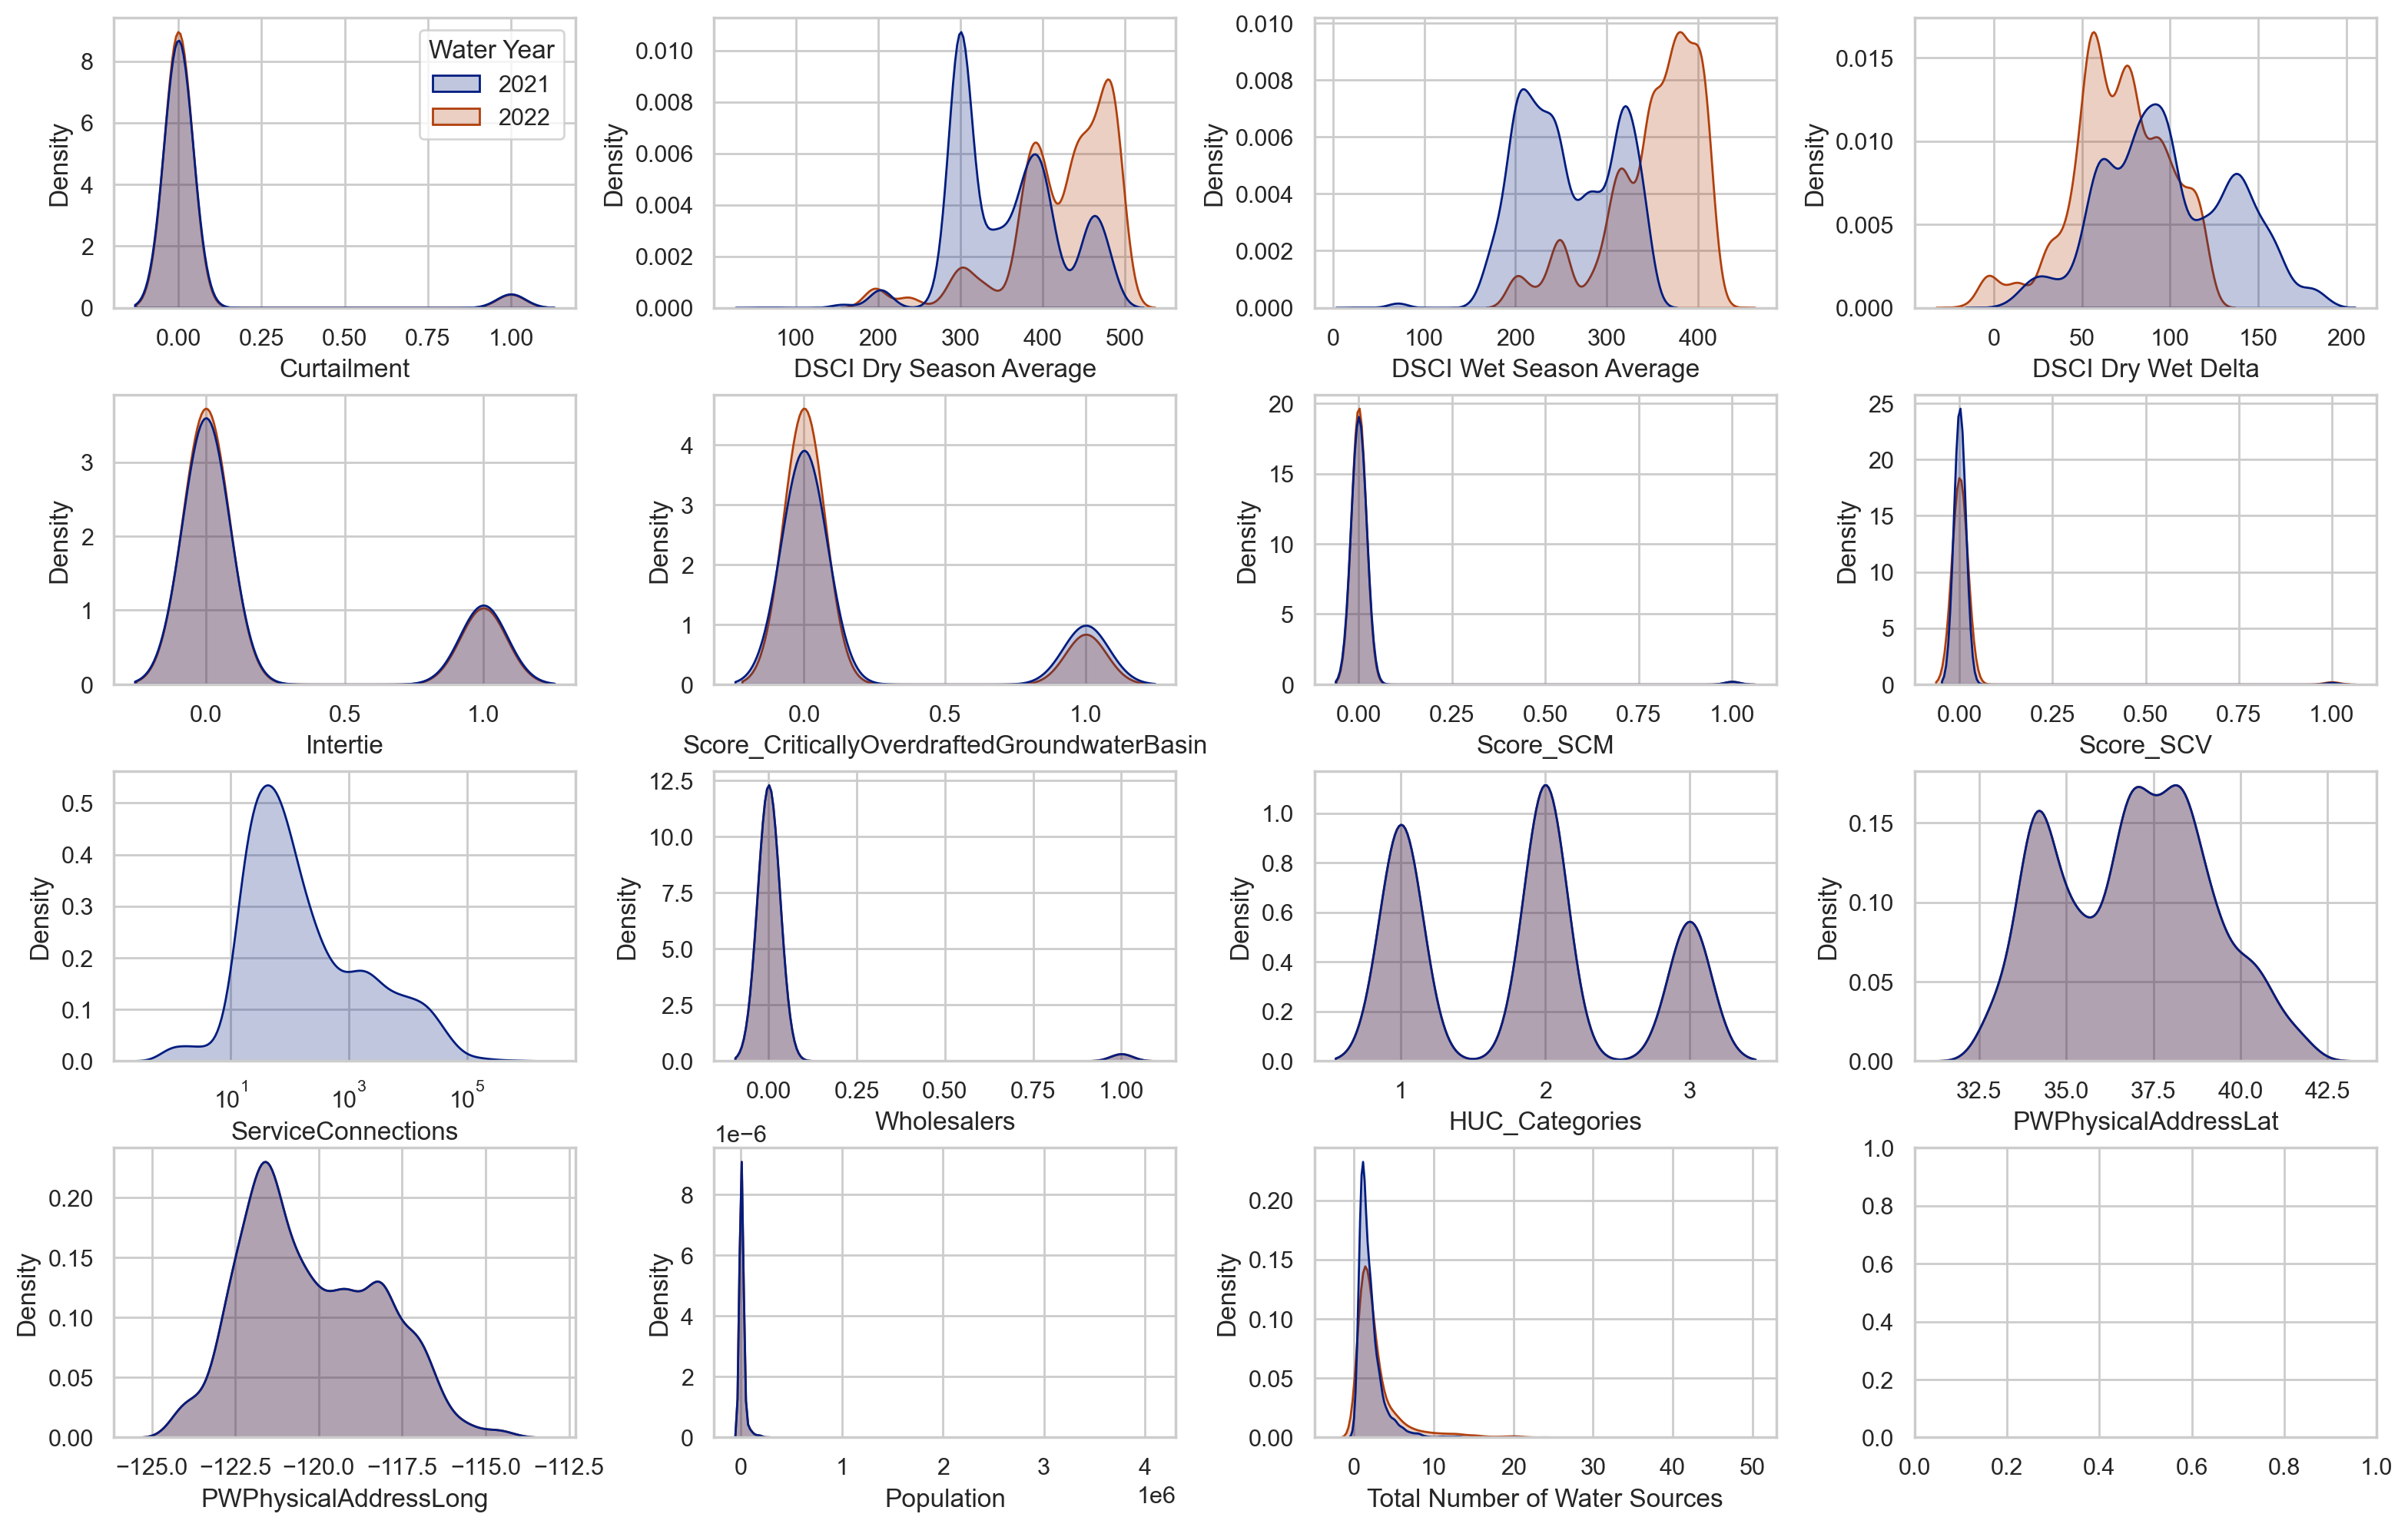

In [140]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(4,4, figsize=(19,12))
sns.kdeplot(df_combined, x='Curtailment', hue='Water Year', fill=True, ax=ax[0,0], legend=True, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Season Average', hue='Water Year', fill=True, ax=ax[0,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='Water Year', fill=True, ax=ax[0,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Wet Delta', hue='Water Year', fill=True, ax=ax[0,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Intertie', hue='Water Year', fill=True, ax=ax[1,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_CriticallyOverdraftedGroundwaterBasin', hue='Water Year', fill=True, ax=ax[1,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCM', hue='Water Year', fill=True, ax=ax[1,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCV', hue='Water Year', fill=True, ax=ax[1,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='ServiceConnections', hue='Water Year', fill=True, ax=ax[2,0], legend=False, log_scale=True, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Wholesalers', hue='Water Year', fill=True, ax=ax[2,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='HUC_Categories', hue='Water Year', fill=True, ax=ax[2,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLat', hue='Water Year', fill=True, ax=ax[2,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLong', hue='Water Year', fill=True, ax=ax[3,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Population', hue='Water Year', fill=True, ax=ax[3,1], legend=False, palette='dark')
sns.kdeplot(df_combined, x='Total Number of Water Sources', hue='Water Year', fill=True, ax=ax[3,2], legend=False, palette='dark')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('Features_per_WaterYear.png', dpi=300, transparent=True, bbox_inches='tight')

**Thinking about the label**

* `BottledHauledWaterOrZeroSource`: This describes whether a system currently relies on bottled water. 
* `WaterOutageDroughtViolation`: This directly describes whether a system had an outage due to drought.
* `CurtailmentExemptionPetition`: This is a petition to repeal the curtailment and unrelated to drought. The only ones who would appeal a curtailment are those who are already curtailed. `Curtailment` is a feature in the model, and highly correlated with the outcome label `CurtailmentExemptionPrediction`. A curtailment occurs when there is already a problem. According to the [DDW 2022 Water Right Curtailments Fact Sheet](https://www.waterboards.ca.gov/drought/resources-for-water-rights-holders/docs/curtailments-2022.pdf): "State Water Board staff evaluate water availability using current and forecasted hydrologic information, water use data from water right holders, environmental water needs, projected supplies, and more. When that evaluation shows there is not enough water to support all the known needs in a watershed, the State Water Board can send water right holders an order that prohibits water use. These orders are called Curtailment Orders." Based on this, it seems like `Curtailment` should be an outcome. 

<Axes: xlabel='CurtailmentExemptionPetition', ylabel='Density'>

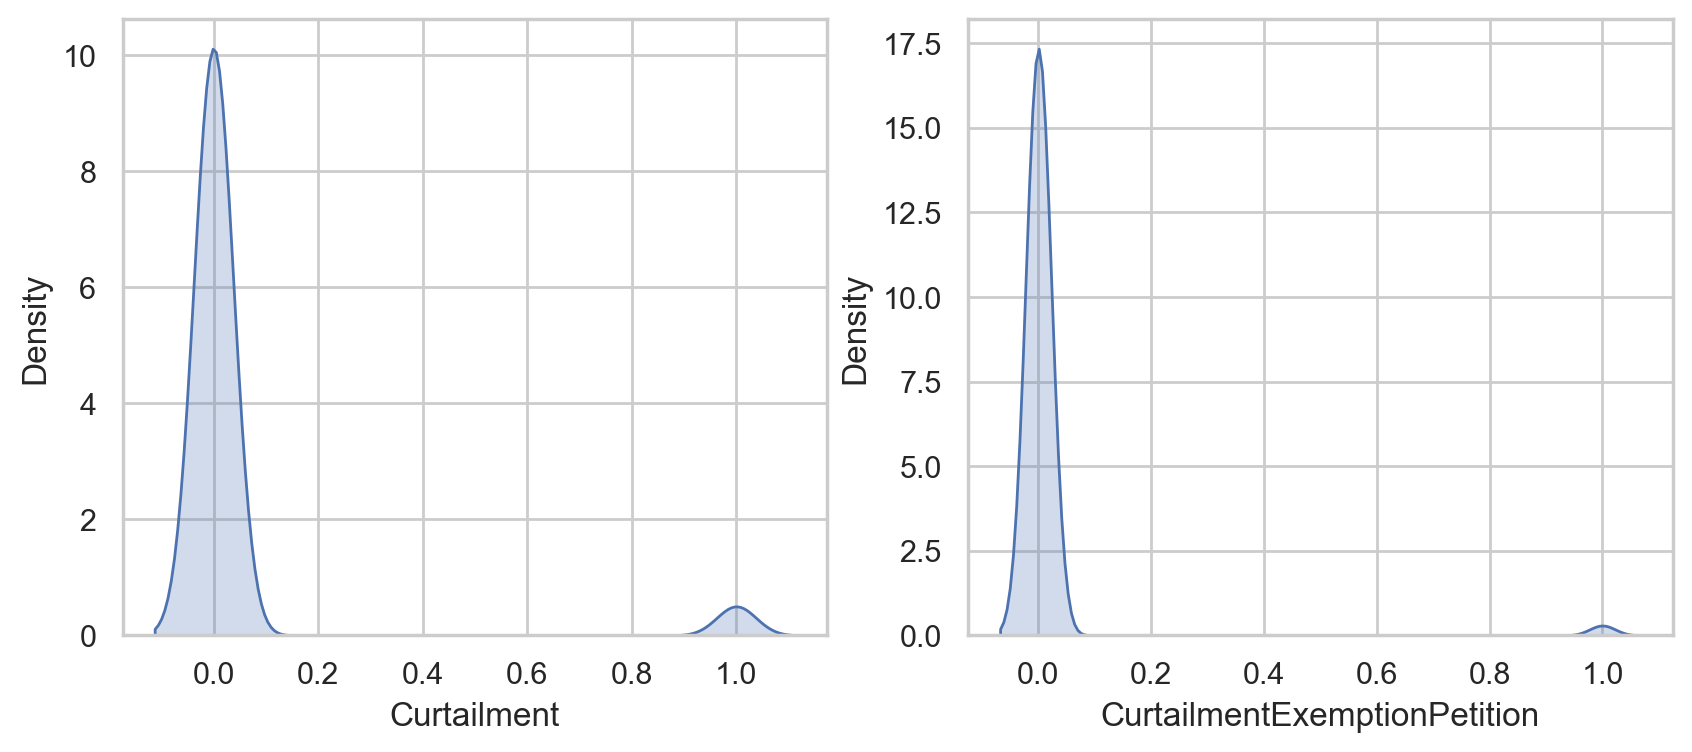

In [141]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.kdeplot(x=df_combined['Curtailment'], fill=True, legend=True, ax=ax[0])
sns.kdeplot(x=df_combined['CurtailmentExemptionPetition'], fill=True, legend=True, ax=ax[1])

In [142]:
print('Number of Curtailments in 2021: ',df_combined[df_combined['Water Year'] == 2021]['Curtailment'].value_counts()[1])
print('Number of Petitions in 2021: ',df_combined[df_combined['Water Year'] == 2021]['CurtailmentExemptionPetition'].value_counts()[1])
print('Number of Curtailments in 2022: ',df_combined[df_combined['Water Year'] == 2022]['Curtailment'].value_counts()[1])
print('Number of Petitions in 2022: ',df_combined[df_combined['Water Year'] == 2022]['CurtailmentExemptionPetition'].value_counts()[1])

Number of Curtailments in 2021:  139
Number of Petitions in 2021:  42
Number of Curtailments in 2022:  131
Number of Petitions in 2022:  53


Are there people who did not experience outages who wanted a petition? No. This is probably because a curtailment is a preventative measure. See:

```python
df_combined[df_combined['CurtailmentExemptionPetition'] == 1][['BottledHauledWaterOrZeroSource', 'WaterOutageDroughtViolation','Curtailment']]
```

Look at the difference in the labels between 2021 and 2022.

In [143]:
print('Year 2021')
print('Positive values of DroughtExperienced: ',df_combined[df_combined['Water Year'] == 2021]['DroughtExperienced'].value_counts()[1])
print('Positive values of WaterOutageDroughtViolation: ',df_combined[df_combined['Water Year'] == 2021][['WaterOutageDroughtViolation']].value_counts()[1])
print('Positive values| of BottledHauledWaterOrZeroSource: ',df_combined[df_combined['Water Year'] == 2021][['BottledHauledWaterOrZeroSource']].value_counts()[1])
print('Positive values of CurtailmentExemptionPetition: ',df_combined[df_combined['Water Year'] == 2021][['CurtailmentExemptionPetition']].value_counts()[1])

Year 2021
Positive values of DroughtExperienced:  102
Positive values of WaterOutageDroughtViolation:  16
Positive values| of BottledHauledWaterOrZeroSource:  58
Positive values of CurtailmentExemptionPetition:  42


In [144]:
print('Year 2022')
print('Positive values of DroughtExperienced: ',df_combined[df_combined['Water Year'] == 2022][['DroughtExperienced']].value_counts()[1])
print('Positive values of WaterOutageDroughtViolation: ',df_combined[df_combined['Water Year'] == 2022][['WaterOutageDroughtViolation']].value_counts()[1])
print('Positive values of BottledHauledWaterOrZeroSource: ',df_combined[df_combined['Water Year'] == 2022][['BottledHauledWaterOrZeroSource']].value_counts()[1])
print('Positive values of CurtailmentExemptionPetition: ',df_combined[df_combined['Water Year'] == 2022][['CurtailmentExemptionPetition']].value_counts()[1])

Year 2022
Positive values of DroughtExperienced:  122
Positive values of WaterOutageDroughtViolation:  3
Positive values of BottledHauledWaterOrZeroSource:  66
Positive values of CurtailmentExemptionPetition:  53


In [145]:
(102/2866.)*100.

3.558967201674808

In [146]:
total = [
    df_combined[df_combined['Water Year'] == 2021][['DroughtExperienced']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['WaterOutageDroughtViolation']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['BottledHauledWaterOrZeroSource']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2021][['CurtailmentExemptionPetition']].value_counts()[1], 
    df_combined[df_combined['Water Year'] == 2022][['DroughtExperienced']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['WaterOutageDroughtViolation']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['BottledHauledWaterOrZeroSource']].value_counts()[1],
    df_combined[df_combined['Water Year'] == 2022][['CurtailmentExemptionPetition']].value_counts()[1]]    

In [147]:
year = [2021, 2021, 2021, 2021,
        2022, 2022, 2022, 2022]

In [148]:
labels = ['DroughtExperienced', 'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource', 
          'CurtailmentExemptionPetition',
          'DroughtExperienced', 'WaterOutageDroughtViolation', 'BottledHauledWaterOrZeroSource', 
          'CurtailmentExemptionPetition']

In [149]:
df_examples = pd.DataFrame(
    {'Total': total,
     'Year': year,
     'Labels': labels})

<Axes: xlabel='Total', ylabel='Labels'>

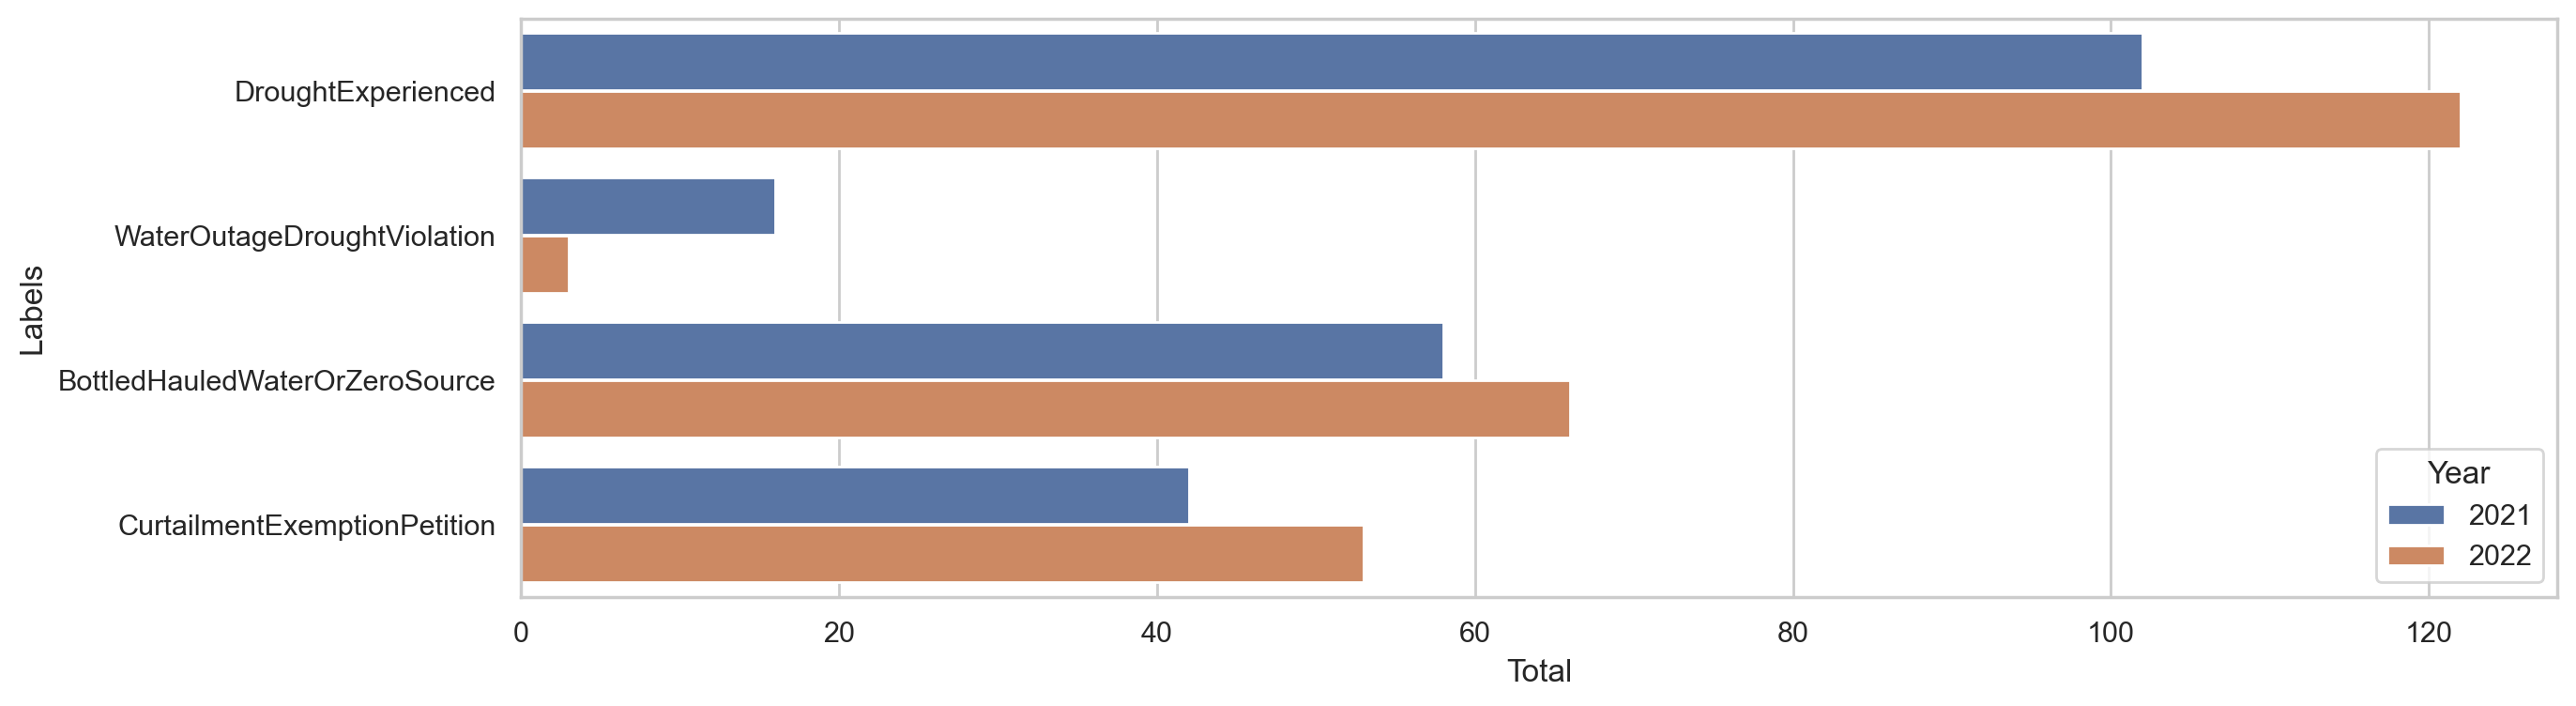

In [150]:
fig, ax = plt.subplots(figsize=(14,4))
sns.set_theme(style='whitegrid')

sns.barplot(orient="h", data=df_examples, x='Total', y='Labels', hue='Year')
#fig.savefig('outcome.png', dpi=300, transparent=True, bbox_inches='tight')

#### B. Looking at correlations
Look at the features together with the each consituent outcome label.

Right now, the outcome label `DroughtExperienced` equals 1 if any of the following consituent outcomes equal 1:  `WaterOutageDroughtViolation'`, `BottledHauledWaterOrZeroSource`, or `CurtailmentExemptionPetition`. Otherwise, `DroughtExperienced` equals zero.

/var/folders/93/hbnl0wps0mg_sqnmv_jpnwlm0000gq/T/ipykernel_32747/1445186735.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

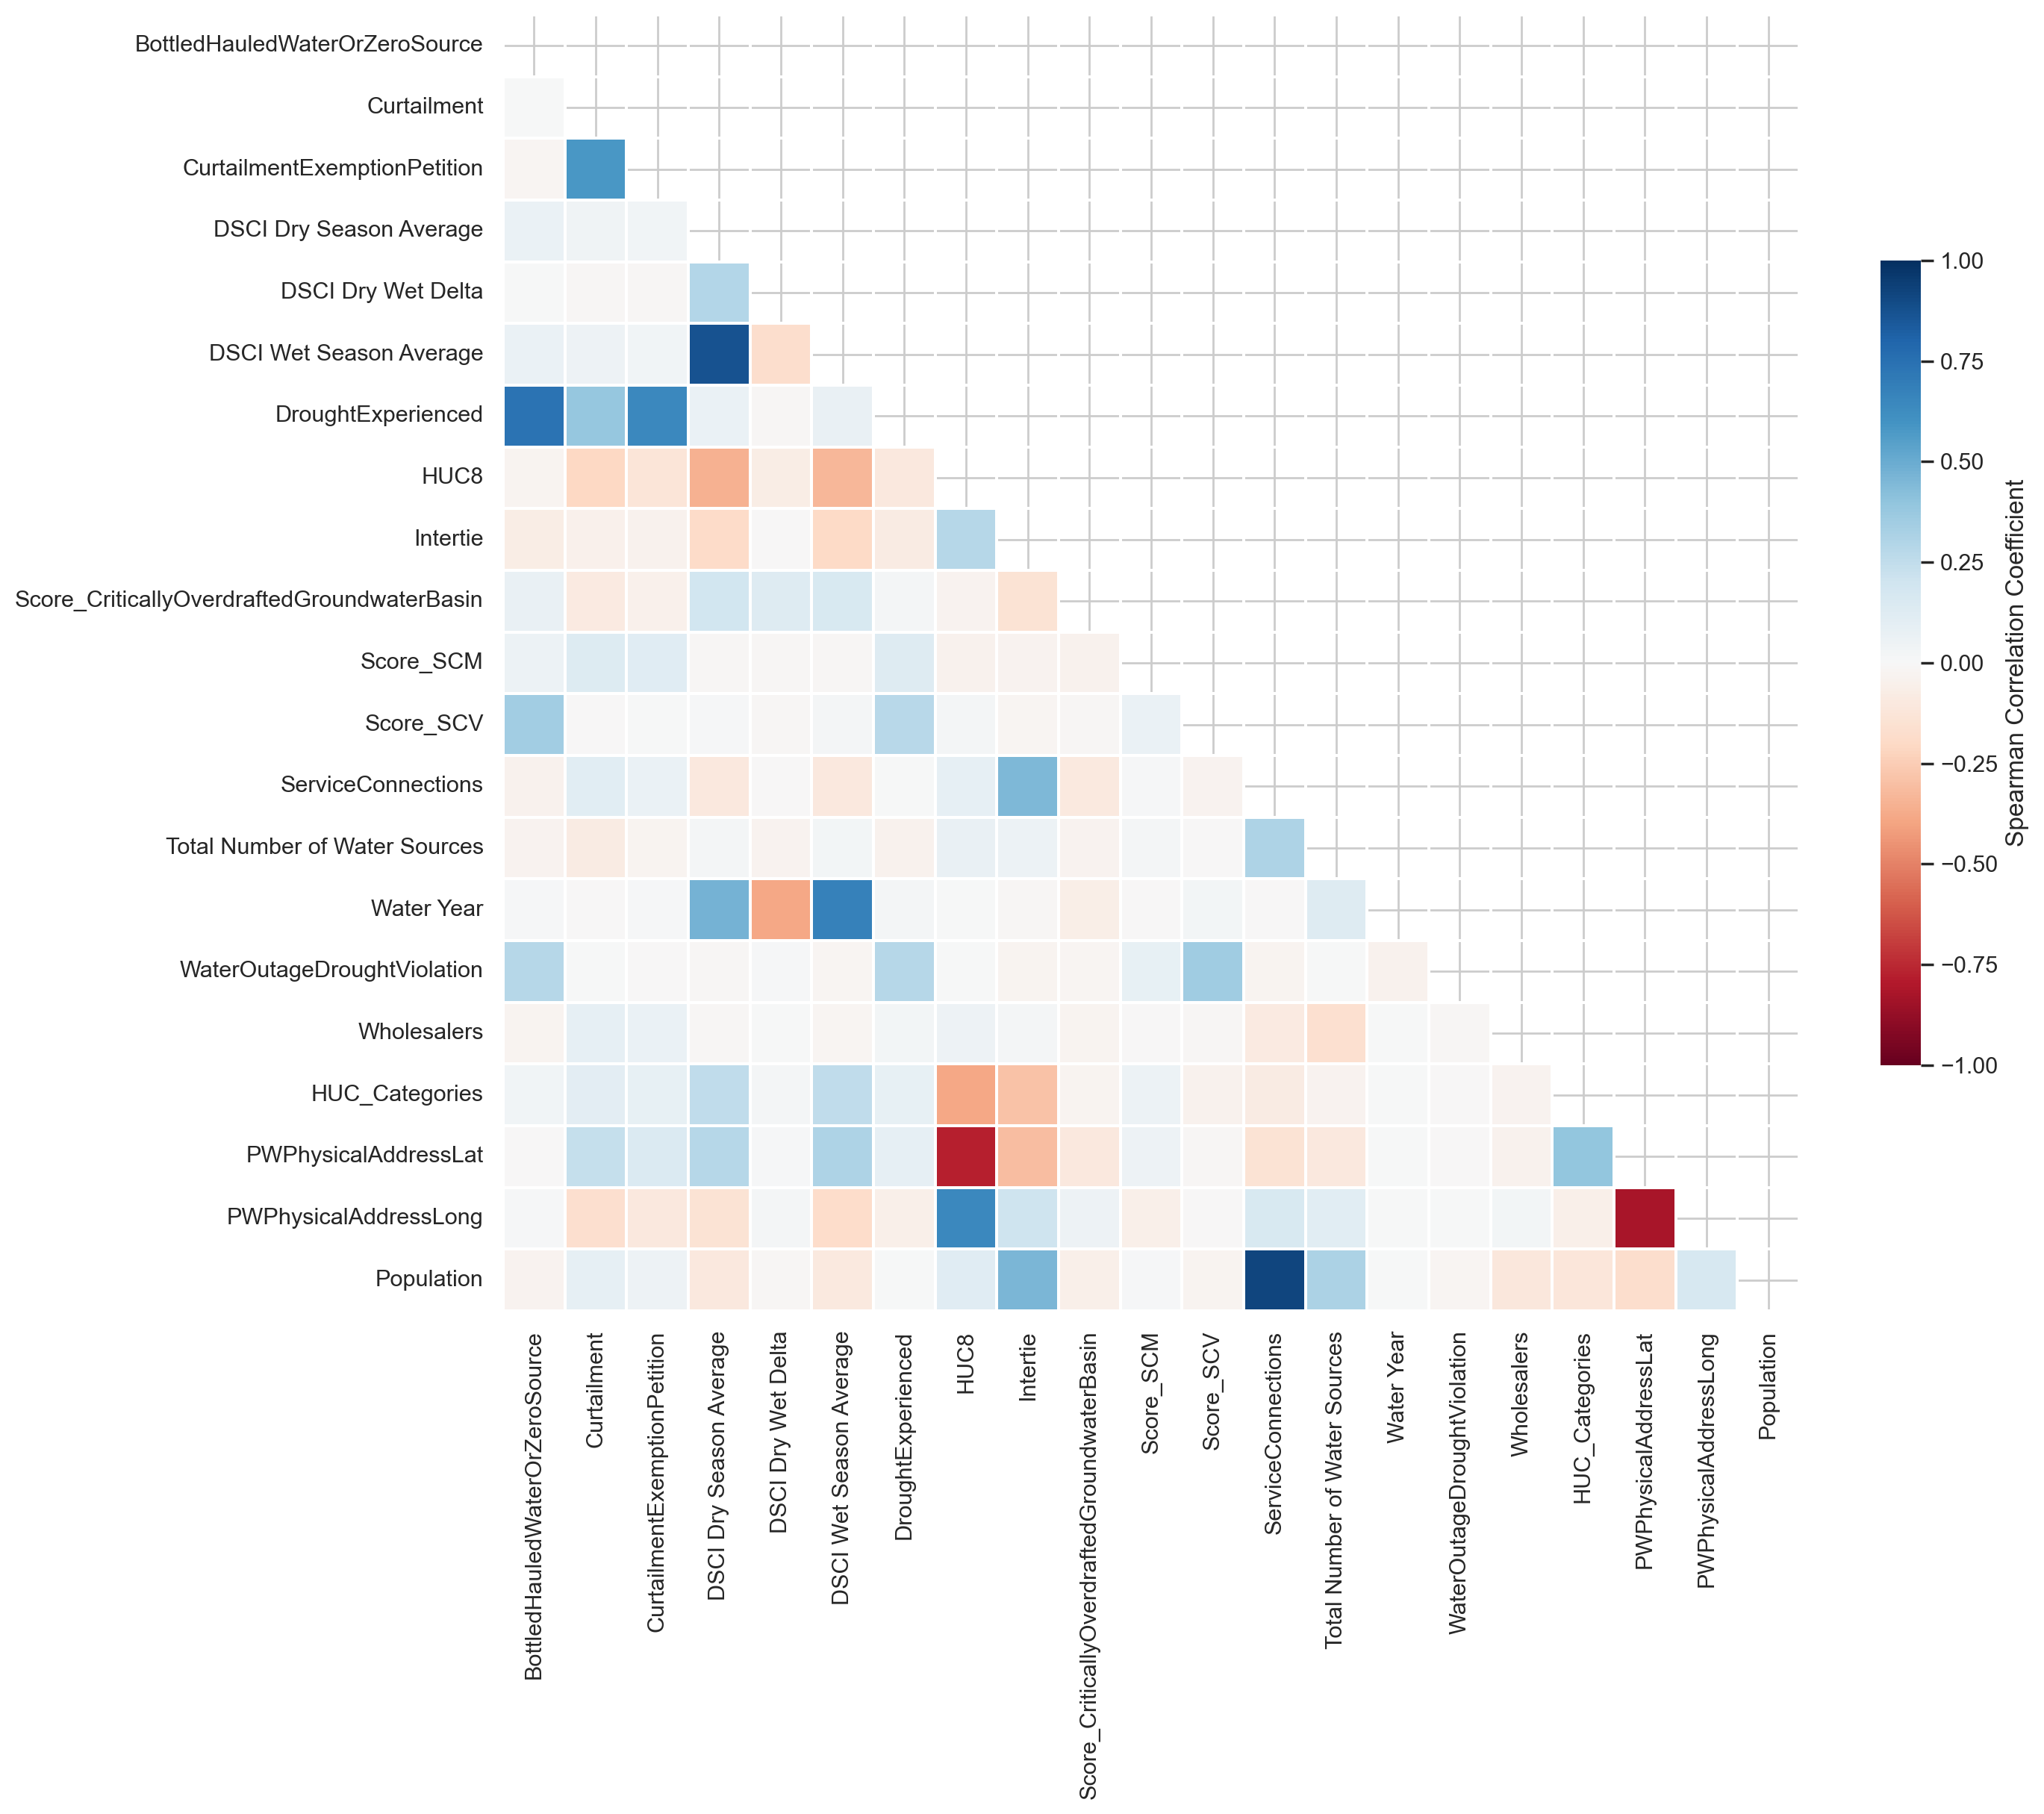

In [151]:
fig, ax = plt.subplots(figsize=(14, 14))
sns.set_theme(style="white")

# Calculate Spearman correlation coefficient
corr = df_combined.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot Spearman correlation coefficient as a diagonal heatmap
cmap = sns.color_palette('RdBu', as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.75, cbar_kws={"shrink": .5, "label": 'Spearman Correlation Coefficient'})
#fig.savefig('spearman_with_labels_v4.png', dpi=300, transparent=True, bbox_inches='tight')

#### C. Looking at CWS that experienced drought multiple years in a row

In [152]:
print("In 2021, ",df_combined[(df_combined['DroughtExperienced'] == 1) & (df_combined['Water Year'] == 2021)]['Population'].sum(),"people in California experienced some form of drought.")

In 2021,  952732 people in California experienced some form of drought.


In [153]:
print("In 2022,",df_combined[(df_combined['DroughtExperienced'] == 1) & (df_combined['Water Year'] == 2022)]['Population'].sum(),"people in California experienced some form of drought.")

In 2022, 1087825 people in California experienced some form of drought.


Most of the CWS experienced drought two years in a row. This means persistence (use of the previous outcome to predict the subsequent outcome) will be a useful feature.

In [154]:
number_of_drought_years = df_combined[(df_combined['DroughtExperienced'] == 1)][['CWSID', 'DroughtExperienced']].groupby('CWSID').sum()

In [155]:
number_of_single_years = len(number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 1])
number_of_repeat_years = len(number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 2])
total_number = len(number_of_drought_years)

In [156]:
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in only one year.'.format(number_of_single_years, (number_of_single_years/total_number)))
print('{} CWS, or {:2.2%} of all drought-experienced CWS, experienced drought in both years.'.format(number_of_repeat_years, (number_of_repeat_years/total_number)))

46 CWS, or 34.07% of all drought-experienced CWS, experienced drought in only one year.
89 CWS, or 65.93% of all drought-experienced CWS, experienced drought in both years.


In addition, 28.26% of CWS that experienced drought only once had their experience in 2021. Comparatively, 71.74% of CWS that experienced drought only once had their experience in 2022.

In [157]:
df_single_CWSIDS = number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 1].merge(df_combined, how='left', on='CWSID').reset_index(drop=True)
df_repeat_CWSIDS = number_of_drought_years[number_of_drought_years['DroughtExperienced'] == 2].merge(df_combined, how='left', on='CWSID').reset_index(drop=True)

In [158]:
single_CWSIDS_list = df_single_CWSIDS['CWSID'].to_list()
repeat_CWSIDS_list = df_repeat_CWSIDS['CWSID'].to_list()

In [159]:
single_CWSIDS_index = df_combined[df_combined['CWSID'].isin(single_CWSIDS_list)].index
repeat_CWSIDS_index = df_combined[df_combined['CWSID'].isin(repeat_CWSIDS_list)].index

In [160]:
df_combined['DroughtExperienced Years'] = 0

In [161]:
df_combined.loc[single_CWSIDS_index, ('DroughtExperienced Years')] = 1
df_combined.loc[repeat_CWSIDS_index, ('DroughtExperienced Years')] = 2

Did the CWSIDs that experienced drought in both 2021 and 2022 experience it for the same reason?

There are a couple CWSIDs that experienced a water drought violation in 2021 and then relied on bottled or hauled water in 2022. We also see many CWSIDs that are relying on bottled or hauled water, but do not have a flag for a water outage drought violation. Why is that?

In [162]:
multi_reason_CWSIDS = []

for i in range(len(repeat_CWSIDS_list)):
    df_tmp = df_combined[df_combined['CWSID'] == repeat_CWSIDS_list[i]].reset_index()
    if (df_tmp['BottledHauledWaterOrZeroSource'][0] != df_tmp['BottledHauledWaterOrZeroSource'][1]):
        multi_reason_CWSIDS.append(repeat_CWSIDS_list[i])
    if (df_tmp['CurtailmentExemptionPetition'][0] != df_tmp['CurtailmentExemptionPetition'][1]):
        multi_reason_CWSIDS.append(repeat_CWSIDS_list[i])
    if (df_tmp['WaterOutageDroughtViolation'][0] != df_tmp['WaterOutageDroughtViolation'][1]):
        multi_reason_CWSIDS.append(repeat_CWSIDS_list[i])

In [163]:
print('There are {} CWS that were flagged for different reasons from year to year. {} CWS rest were flagged for the same reason.'.format(len(multi_reason_CWSIDS), len(repeat_CWSIDS_list)/2))

There are 32 CWS that were flagged for different reasons from year to year. 89.0 CWS rest were flagged for the same reason.


Where are the CWS that experienced drought in both years?

It looks like they're everywhere, but about half are in the central valley.

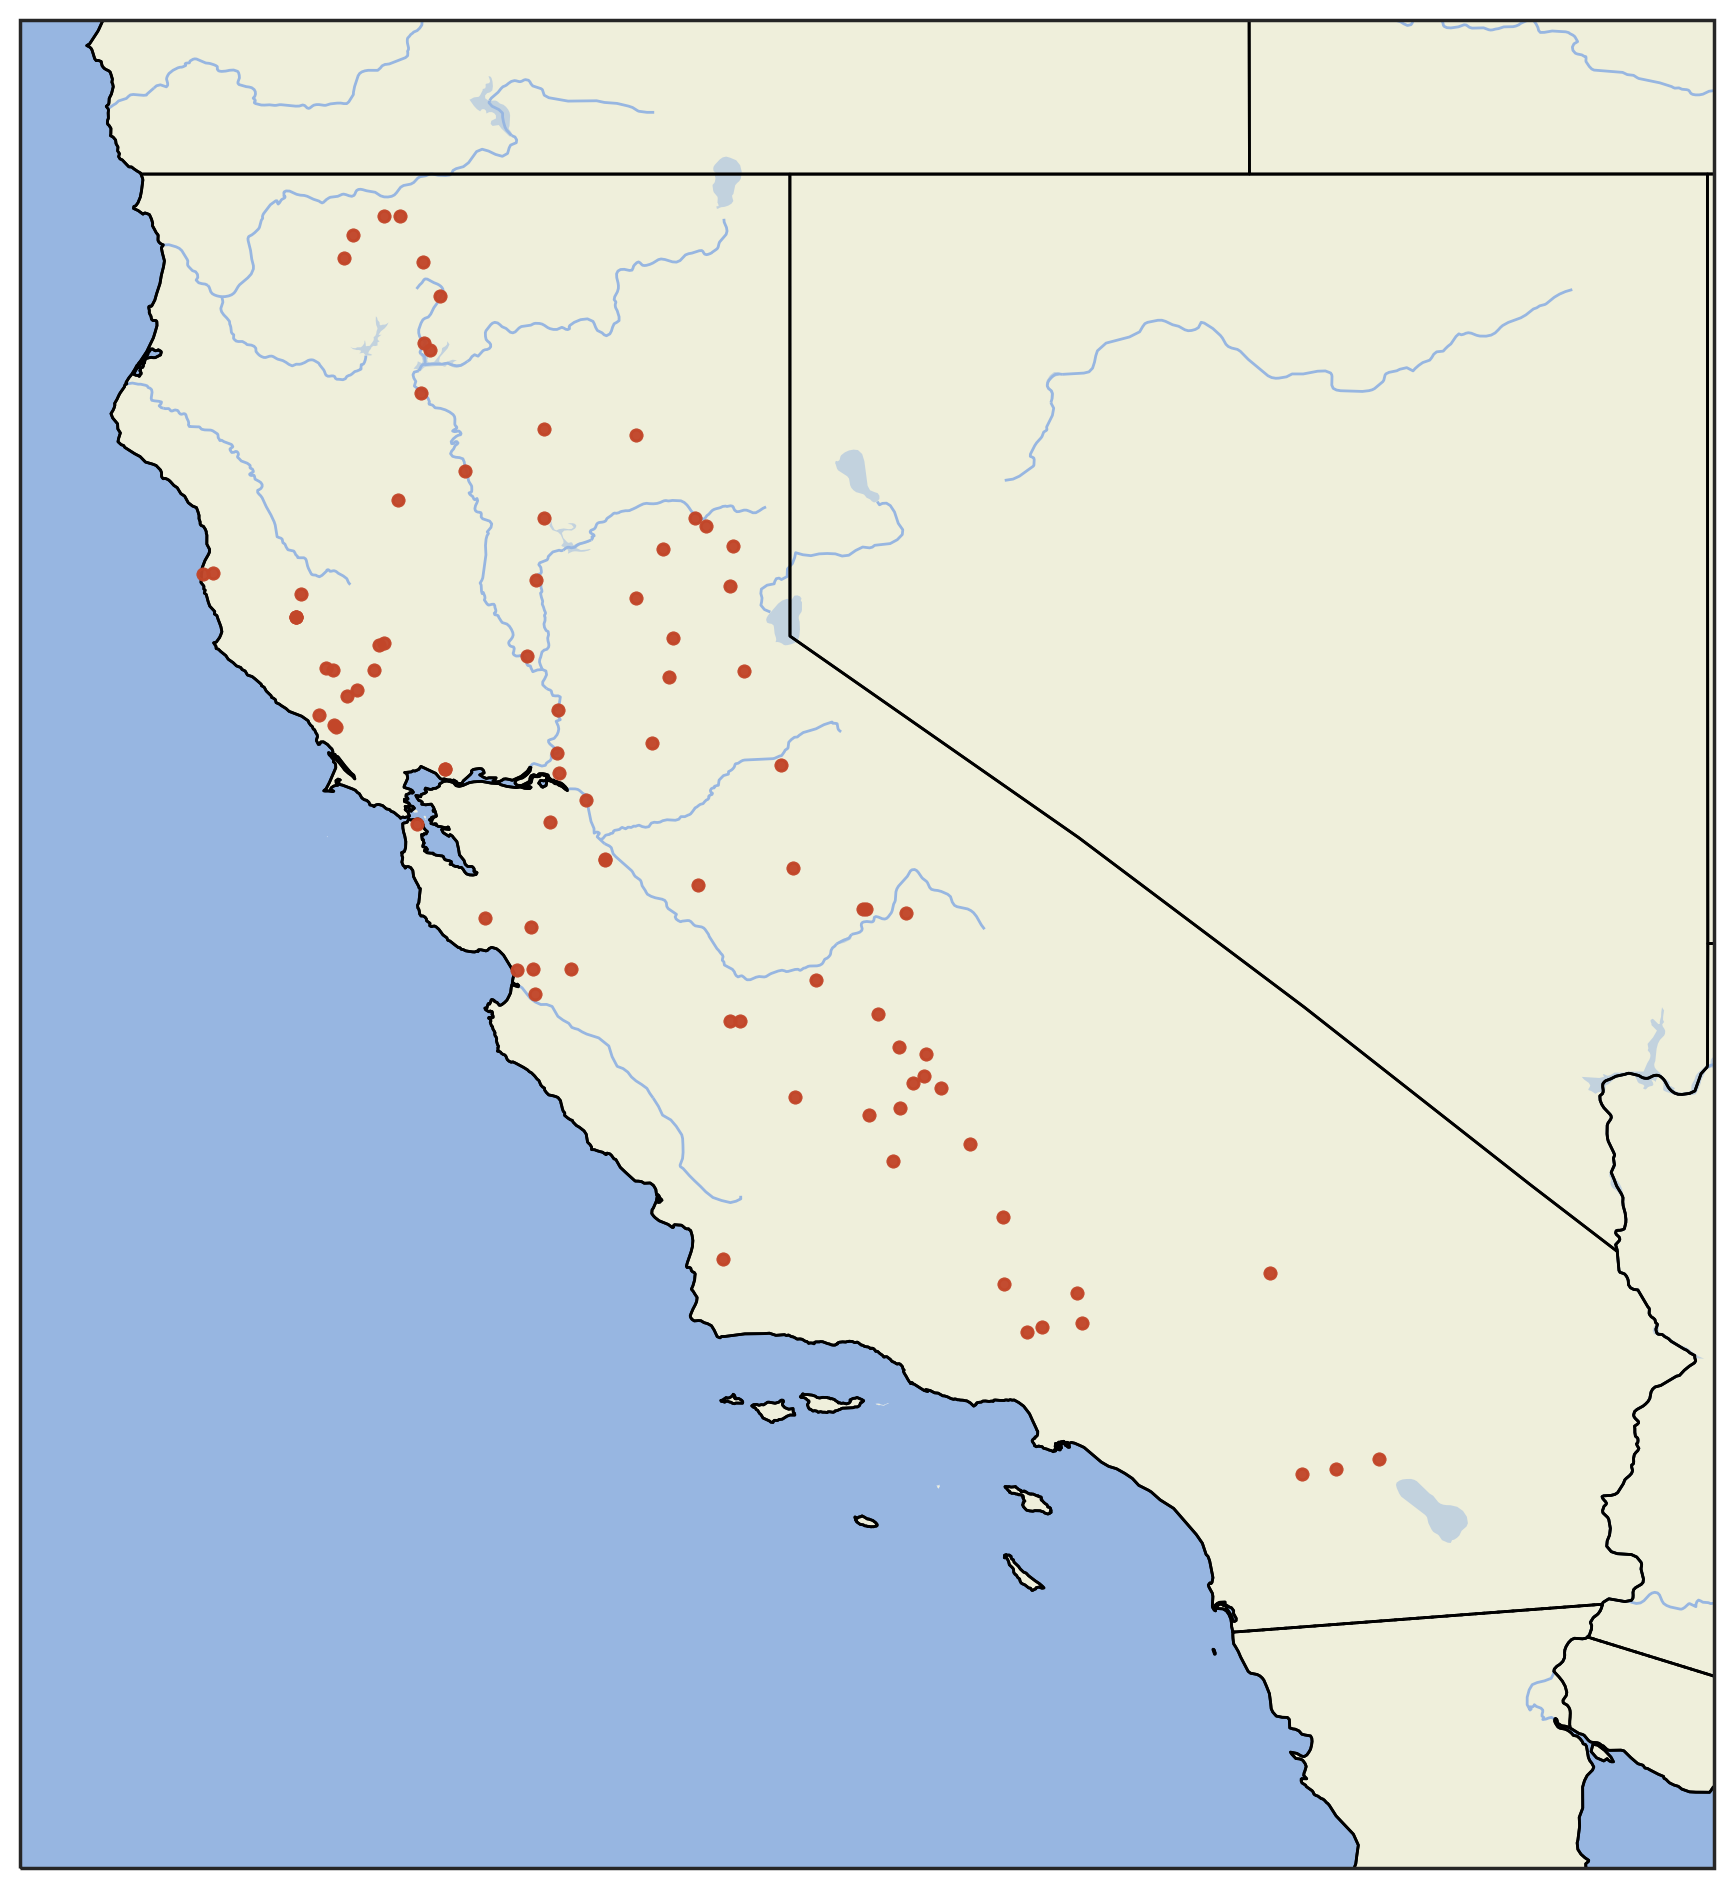

In [164]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-125, -114, 31, 43], crs=ccrs.PlateCarree())

odi_red = "#C24629"

ax.plot(df_repeat_CWSIDS['PWPhysicalAddressLong'],df_repeat_CWSIDS['PWPhysicalAddressLat'], marker='o', 
        linestyle='None', color=odi_red, markersize=4, alpha=0.8, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.STATES)

plt.show()

#fig.savefig('locations.png', dpi=300, transparent=True, bbox_inches='tight')

Is there any difference between the CWS that are drought-impacted both years, drought-impacted one year, and not drought-impacted?

/var/folders/93/hbnl0wps0mg_sqnmv_jpnwlm0000gq/T/ipykernel_32747/879612564.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


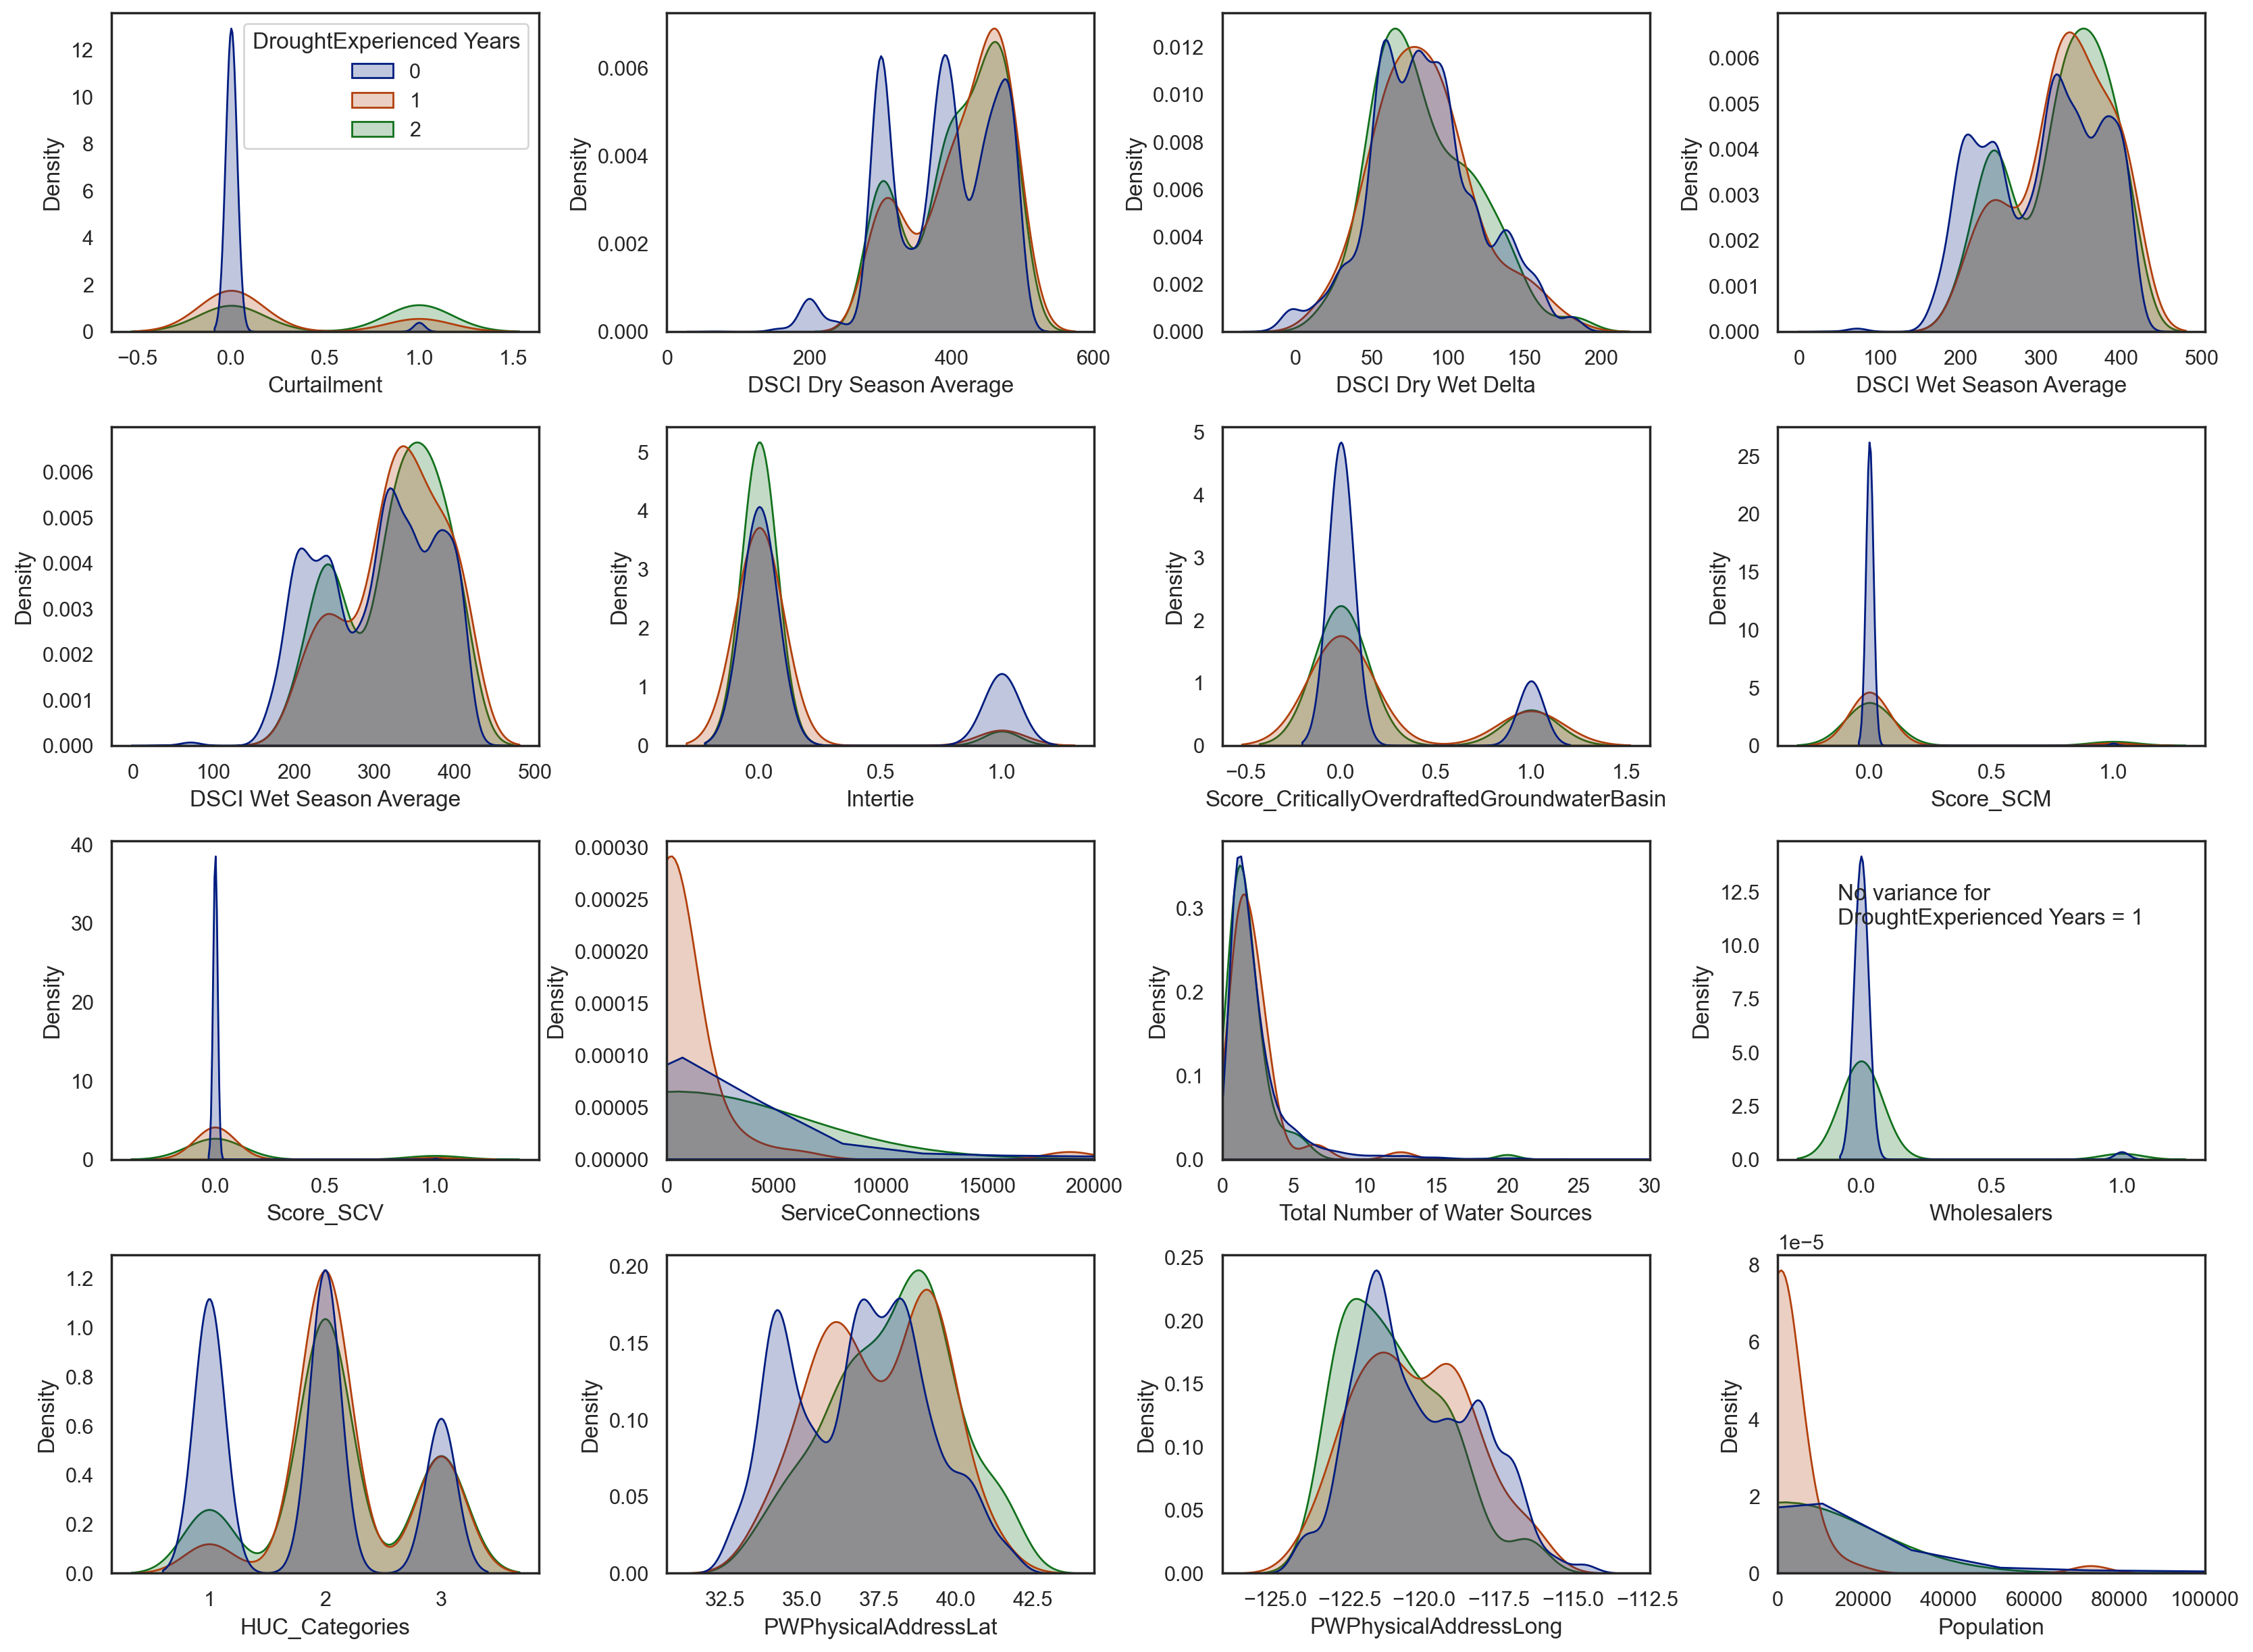

In [165]:
fig, ax = plt.subplots(4,4, figsize=(20,15))
sns.kdeplot(df_combined, x='Curtailment', hue='DroughtExperienced Years', fill=True, ax=ax[0,0], legend=True, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Season Average', hue='DroughtExperienced Years', fill=True, ax=ax[0,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Dry Wet Delta', hue='DroughtExperienced Years', fill=True, ax=ax[0,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='DroughtExperienced Years', fill=True, ax=ax[0,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='DSCI Wet Season Average', hue='DroughtExperienced Years', fill=True, ax=ax[1,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Intertie', hue='DroughtExperienced Years', fill=True, ax=ax[1,1,], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_CriticallyOverdraftedGroundwaterBasin', hue='DroughtExperienced Years', fill=True, ax=ax[1,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCM', hue='DroughtExperienced Years', fill=True, ax=ax[1,3], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Score_SCV', hue='DroughtExperienced Years', fill=True, ax=ax[2,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='ServiceConnections', hue='DroughtExperienced Years', fill=True, ax=ax[2,1], log_scale=False, legend=False, common_norm=False, palette='dark')
ax[2,1].set_xlim([0,20000])
sns.kdeplot(df_combined, x='Total Number of Water Sources', hue='DroughtExperienced Years', fill=True, ax=ax[2,2], log_scale=False, legend=False, common_norm=False, palette='dark')
ax[2,2].set_xlim([0,30])
sns.kdeplot(df_combined, x='Wholesalers', hue='DroughtExperienced Years', fill=True, ax=ax[2,3], legend=False, common_norm=False, palette='dark')
ax[2,3].annotate('No variance for \nDroughtExperienced Years = 1', xy=(-0.09, 11))
sns.kdeplot(df_combined, x='HUC_Categories', hue='DroughtExperienced Years', fill=True, ax=ax[3,0], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLat', hue='DroughtExperienced Years', fill=True, ax=ax[3,1], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='PWPhysicalAddressLong', hue='DroughtExperienced Years', fill=True, ax=ax[3,2], legend=False, common_norm=False, palette='dark')
sns.kdeplot(df_combined, x='Population', hue='DroughtExperienced Years', fill=True, ax=ax[3,3], log_scale=False, legend=False, common_norm=False, palette='dark')
ax[3,3].set_xlim([0,100000])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#fig.savefig('DroughtExperienced_years.png', dpi=300, transparent=True, bbox_inches='tight')

### Split the data

Create a training and validation dataset. 

* We ask the model to learn the relationship between everything that happened in 2021 and the label for 2022. Critically, this means that we treat the outcome, or label, for 2021 as a feature. Therefore, we train the model on 70% of the data from 2021 and 70% of the labels 2022. In addition, we make sure as many HUC8 codes as posible are represented in the training set. Note that there are a dozen HUC8 codes with only one CWS, so these cannot be represented in both samples. To do this, we temporarily add `HUC8`, `CWSID`, `Water Year` to the list of features, so we can stratify this feature across the training and testing sets and verify the results. After that, we will drop these three features from our data.
* We test the model by giving it the remaining 30% of data from 2021 and asking the model to predict the 2022 labels.
* Note that we do not use the 2022 features here. We will use the 2022 features and labels, together with the 2021 features and labels, to predict the 2023 outcome.

In [166]:
temporary_features = ['CWSID', 'Water Year', 'HUC8']

numeric_features = ['ServiceConnections', 'Population',
                    'PWPhysicalAddressLat', 'PWPhysicalAddressLong', 
                    'DSCI Dry Season Average', 'DSCI Wet Season Average',
                    'DSCI Dry Wet Delta', 'Total Number of Water Sources']

categorical_features = ['Score_SCV', 'Score_SCM',
                        'Score_CriticallyOverdraftedGroundwaterBasin',
                        'Intertie', 'Wholesalers',
                        'Curtailment', 'HUC_Categories', 'DroughtExperienced']

temporary_all_features = temporary_features + numeric_features + categorical_features

In [167]:
# Construct all the examples
X = df_combined[temporary_all_features][df_combined['Water Year'] == 2021]

# Construct all the labels
y = df_combined[['CWSID', 'Water Year', 'HUC8', 'DroughtExperienced']][df_combined['Water Year'] == 2022]

Right now there are two flavors of `DroughtExperienced` in the model:
1. The outcome label for 2021, which is a feature, and
2. The outcome label for 2022, which is a label.

To avoid confusion, rename the feature `DroughtExperienced` as `Outcome` and redefine the categorical features to include `Outcome`:

In [168]:
X = X.rename(columns={'DroughtExperienced' : 'Outcome'})

In [169]:
categorical_features = ['Score_SCV', 'Score_SCM',
                        'Score_CriticallyOverdraftedGroundwaterBasin',
                        'Intertie', 'Wholesalers',
                        'Curtailment', 'HUC_Categories', 'Outcome']

Now split the training and validation sets, stratifying by `HUC_Categories`:

In [170]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.36, random_state=77, stratify=X['HUC_Categories'])

In [171]:
print('There are {} positive examples in the training set.'.format(y_train['DroughtExperienced'].value_counts()[1]))
print('There are {} positive examples in the training set.'.format(y_val['DroughtExperienced'].value_counts()[1]))

There are 77 positive examples in the training set.
There are 45 positive examples in the training set.


In [172]:
X.columns

Index(['CWSID', 'Water Year', 'HUC8', 'ServiceConnections', 'Population',
       'PWPhysicalAddressLat', 'PWPhysicalAddressLong',
       'DSCI Dry Season Average', 'DSCI Wet Season Average',
       'DSCI Dry Wet Delta', 'Total Number of Water Sources', 'Score_SCV',
       'Score_SCM', 'Score_CriticallyOverdraftedGroundwaterBasin', 'Intertie',
       'Wholesalers', 'Curtailment', 'HUC_Categories', 'Outcome'],
      dtype='object')

In [173]:
print(f"The training set is {len(X_train)/len(X)*100}% of the data.")
print(f"The validation set is {len(X_val)/len(X)*100}% of the data.")
print("")
print(f"The entire dataset includes {len(X['HUC8'].unique())} unique HUC8 codes.")
print(f"The training set includes {len(X_train['HUC8'].unique())} unique HUC8 codes.")
print(f"The validation set includes {len(X_val['HUC8'].unique())} unique HUC8 codes.")

The training set is 63.991625959525464% of the data.
The validation set is 36.00837404047453% of the data.

The entire dataset includes 125 unique HUC8 codes.
The training set includes 120 unique HUC8 codes.
The validation set includes 112 unique HUC8 codes.


Take a look to make sure everything looks reasonable.

In [174]:
display(X_train[5:10])
display(y_train[5:10])
display(X_val[5:10])
display(y_val[5:10])

CWSID  Water Year      HUC8  ServiceConnections  Population  \
2458  CA4910018        2021  18010110               269.0         424   
829   CA1910149        2021  18070105              3123.0       11795   
1944  CA4000650        2021  18060006               313.0         600   
340   CA1210016        2021  18010102              6101.0       16900   
103   CA0600008        2021  18020104               123.0         305   

      PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
2458             38.522960            -122.998346               300.000000   
829              33.796878            -118.168357               300.150455   
1944             35.072592            -120.585933               307.007727   
340              40.935780            -124.099890               297.417727   
103              39.073305            -121.895627               400.000000   

      DSCI Wet Season Average  DSCI Dry Wet Delta  \
2458               246.010769           53.989231   
829                205.533846           94.616608   
1944               189.694231          117.313497   
340                163.171538          134.246189   
103                338.461538           61.538462   

      Total Number of Water Sources  Score_SCV  Score_SCM  \
2458                            2.0        0.0        0.0   
829                             4.0        0.0        0.0   
1944                            3.0        0.0        0.0   
340                             1.0        0.0        0.0   
103                             2.0        0.0        0.0   

      Score_CriticallyOverdraftedGroundwaterBasin  Intertie  Wholesalers  \
2458                                            0       0.0          0.0   
829                                             0       1.0          0.0   
1944                                            0       0.0          0.0   
340                                             0       1.0          0.0   
103                                             0       0.0          0.0   

      Curtailment  HUC_Categories  Outcome  
2458            0               3        0  
829             0               1        0  
1944            0               1        0  
340             0               3        0  
103             0               2        0

CWSID  Water Year      HUC8  DroughtExperienced
5324  CA4910018        2022  18010110                   0
3695  CA1910149        2022  18070105                   0
4810  CA4000650        2022  18060006                   0
3206  CA1210016        2022  18010102                   0
2969  CA0600008        2022  18020104                   1

CWSID  Water Year      HUC8  ServiceConnections  Population  \
1953  CA4000749        2021  18060006                17.0          38   
2612  CA5400523        2021  18030007                47.0         100   
518   CA1502164        2021  18030004                55.0          54   
208   CA1000238        2021  18030009                26.0          75   
1765  CA3700924        2021  18070305               123.0         360   

      PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
1953             35.138286            -120.563661               307.007727   
2612             36.546678            -119.425346               468.468636   
518              35.514642            -119.290251               455.952727   
208              36.432782            -119.799398               456.519545   
1765             32.681067            -116.503807               209.325000   

      DSCI Wet Season Average  DSCI Dry Wet Delta  \
1953               189.694231          117.313497   
2612               314.529615          153.939021   
518                331.196923          124.755804   
208                327.911154          128.608392   
1765               175.330000           33.995000   

      Total Number of Water Sources  Score_SCV  Score_SCM  \
1953                            2.0        0.0        0.0   
2612                            1.0        0.0        0.0   
518                             1.0        0.0        0.0   
208                             1.0        0.0        0.0   
1765                            4.0        0.0        0.0   

      Score_CriticallyOverdraftedGroundwaterBasin  Intertie  Wholesalers  \
1953                                            0       0.0          0.0   
2612                                            1       0.0          0.0   
518                                             1       0.0          0.0   
208                                             1       0.0          0.0   
1765                                            0       0.0          0.0   

      Curtailment  HUC_Categories  Outcome  
1953            0               1        0  
2612            0               2        1  
518             0               2        0  
208             0               2        0  
1765            0               1        0

CWSID  Water Year      HUC8  DroughtExperienced
4819  CA4000749        2022  18060006                   0
5478  CA5400523        2022  18030007                   1
3384  CA1502164        2022  18030004                   0
3074  CA1000238        2022  18030009                   0
4631  CA3700924        2022  18070305                   0

In [175]:
# Take a look at some individual CWSIDs
df_combined[df_combined['CWSID'] == 'CA0600008']

BottledHauledWaterOrZeroSource      CWSID  Curtailment  \
103                                0  CA0600008            0   
2969                               1  CA0600008            0   

      CurtailmentExemptionPetition  DSCI Dry Season Average  \
103                              0               400.000000   
2969                             0               486.363636   

      DSCI Dry Wet Delta  DSCI Wet Season Average  DroughtExperienced  \
103            61.538462               338.461538                   0   
2969           95.450944               390.912692                   1   

          HUC8  Intertie  Score_CriticallyOverdraftedGroundwaterBasin  \
103   18020104       0.0                                            0   
2969  18020104       0.0                                            0   

      Score_SCM  Score_SCV  ServiceConnections  Total Number of Water Sources  \
103         0.0        0.0               123.0                            2.0   
2969        0.0        0.0               123.0                            2.0   

      Water Year  WaterOutageDroughtViolation  Wholesalers  HUC_Categories  \
103         2021                            0          0.0               2   
2969        2022                            0          0.0               2   

      PWPhysicalAddressLat  PWPhysicalAddressLong  Population  \
103              39.073305            -121.895627         305   
2969             39.073305            -121.895627         305   

      DroughtExperienced Years  
103                          1  
2969                         1

Make a copy of of all these dataframes in order to print the probabilities per CWS.
Then drop the temporary features.

In [176]:
df_X_train = X_train
df_y_train = y_train
df_X_val = X_val
df_y_val = y_val

In [177]:
X_train = X_train.drop(columns=temporary_features)
y_train = y_train.drop(columns=temporary_features)
X_val = X_val.drop(columns=temporary_features)
y_val = y_val.drop(columns=temporary_features)
X = X.drop(columns=temporary_features)
y = y.drop(columns=temporary_features)

Unravel the label

In [178]:
y_val = y_val.values.ravel()
y_train = y_train.values.ravel()
y = y.values.ravel()

In [179]:
df_X_val[5:10]

CWSID  Water Year      HUC8  ServiceConnections  Population  \
1953  CA4000749        2021  18060006                17.0          38   
2612  CA5400523        2021  18030007                47.0         100   
518   CA1502164        2021  18030004                55.0          54   
208   CA1000238        2021  18030009                26.0          75   
1765  CA3700924        2021  18070305               123.0         360   

      PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
1953             35.138286            -120.563661               307.007727   
2612             36.546678            -119.425346               468.468636   
518              35.514642            -119.290251               455.952727   
208              36.432782            -119.799398               456.519545   
1765             32.681067            -116.503807               209.325000   

      DSCI Wet Season Average  DSCI Dry Wet Delta  \
1953               189.694231          117.313497   
2612               314.529615          153.939021   
518                331.196923          124.755804   
208                327.911154          128.608392   
1765               175.330000           33.995000   

      Total Number of Water Sources  Score_SCV  Score_SCM  \
1953                            2.0        0.0        0.0   
2612                            1.0        0.0        0.0   
518                             1.0        0.0        0.0   
208                             1.0        0.0        0.0   
1765                            4.0        0.0        0.0   

      Score_CriticallyOverdraftedGroundwaterBasin  Intertie  Wholesalers  \
1953                                            0       0.0          0.0   
2612                                            1       0.0          0.0   
518                                             1       0.0          0.0   
208                                             1       0.0          0.0   
1765                                            0       0.0          0.0   

      Curtailment  HUC_Categories  Outcome  
1953            0               1        0  
2612            0               2        1  
518             0               2        0  
208             0               2        0  
1765            0               1        0

In [180]:
df_y_val[5:10]

CWSID  Water Year      HUC8  DroughtExperienced
4819  CA4000749        2022  18060006                   0
5478  CA5400523        2022  18030007                   1
3384  CA1502164        2022  18030004                   0
3074  CA1000238        2022  18030009                   0
4631  CA3700924        2022  18070305                   0

### Scale the data

Scale the numeric features assuming the data obey a Gaussian distribution. Leave the categorical features unscaled.

In [181]:
all_features = numeric_features + categorical_features

In [182]:
if (len(numeric_features) + len(categorical_features)) == len(X.columns):
    print('All variables are included.')

All variables are included.


Select and scale the numeric features.

In [183]:
scaler = preprocessing.StandardScaler()

X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

Scale the validation set using the same mean and variance as the training set.

In [184]:
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

Append the unscaled categorical features.

In [185]:
X_train_categorical = np.array(X_train[categorical_features])
X_val_categorical = np.array(X_val[categorical_features])

X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)

X_train_scaled.shape, X_val_scaled.shape

((1834, 16), (1032, 16))

In [186]:
X_train.columns

Index(['ServiceConnections', 'Population', 'PWPhysicalAddressLat',
       'PWPhysicalAddressLong', 'DSCI Dry Season Average',
       'DSCI Wet Season Average', 'DSCI Dry Wet Delta',
       'Total Number of Water Sources', 'Score_SCV', 'Score_SCM',
       'Score_CriticallyOverdraftedGroundwaterBasin', 'Intertie',
       'Wholesalers', 'Curtailment', 'HUC_Categories', 'Outcome'],
      dtype='object')

### Train the model

We use a Gradient Boosting Trees to train and test the model. Note that the class imbalance ratio here is roughly 1:20.
We choose TSS as an validation metric.

In [187]:
# Print the number of examples per label in the training set
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1757,   77]))

In [188]:
# Print the number of examples per label in the validation set
np.unique(y_val, return_counts=True)

(array([0, 1]), array([987,  45]))

In [189]:
# Initialize the model
clf = svm.SVC(gamma='auto', kernel='rbf', C=5.0, class_weight={0:1, 1: 5}, probability=True)

# Fit the model
model = clf.fit(X_train_scaled, y_train)

In [190]:
# Predict the outcome with the best estimator
y_pred = y_pred = clf.predict(X_val_scaled)
y_pred_probability = clf.predict_proba(X_val_scaled)

### Question 1: Does the model perform well?

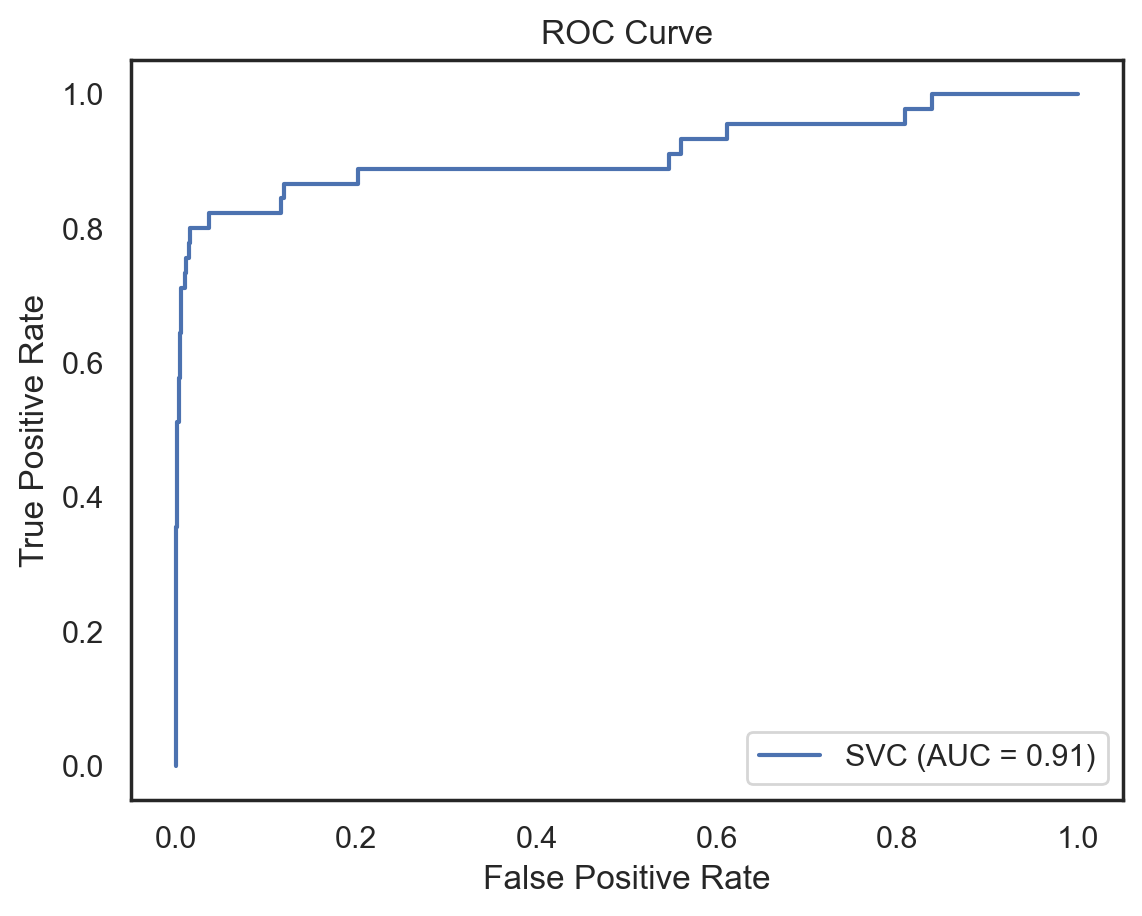

In [191]:
fig, ax = plt.subplots()
rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
plt.show()
#fig.savefig('ROC_AUC.png', dpi=300, transparent=True, bbox_inches='tight')

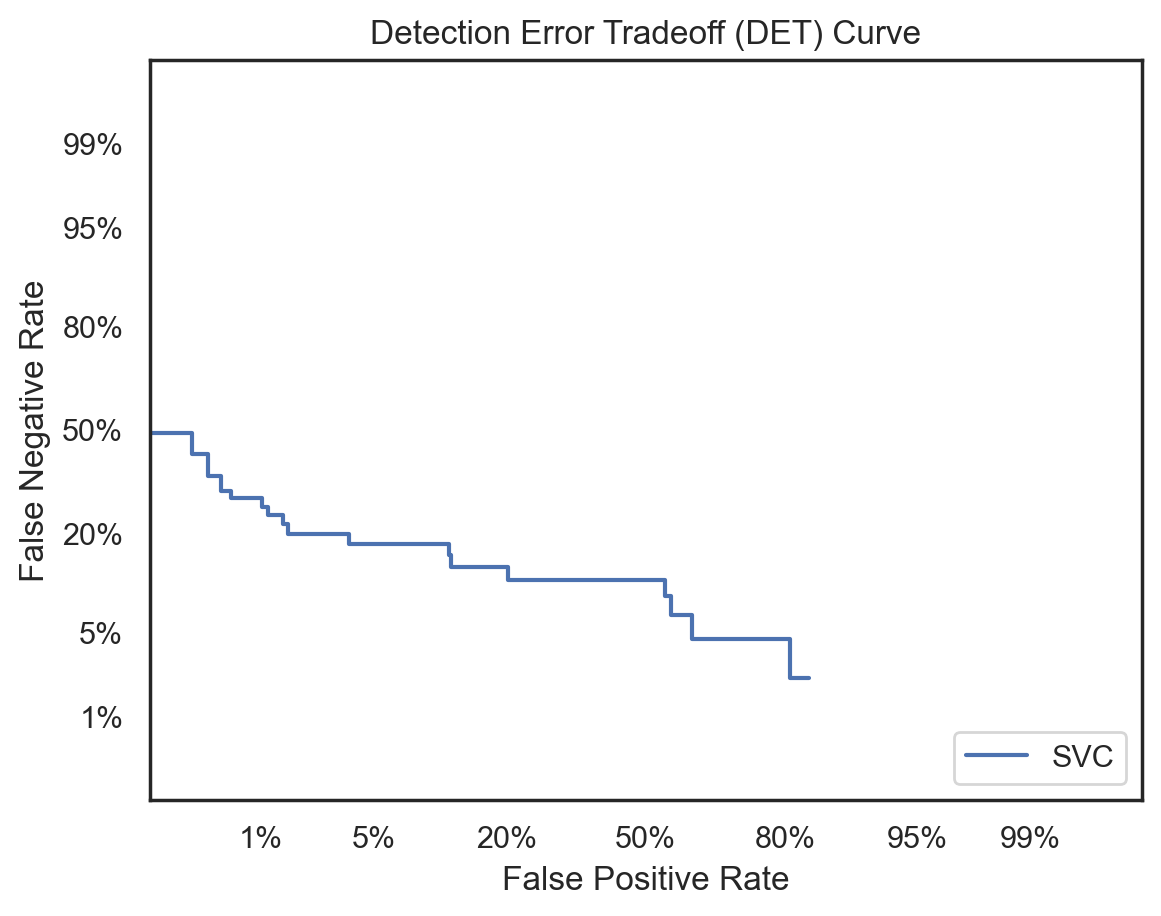

In [192]:
fig, ax = plt.subplots()
rfc_disp = metrics.DetCurveDisplay.from_estimator(clf, X_val_scaled, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('Detection Error Tradeoff (DET) Curve')
plt.show()
#fig.savefig('DET_2022.png', dpi=300, transparent=True, bbox_inches='tight')

Print the probabilities per CWS and flag the false positives and false negatives.

In [193]:
# Set counter
count_false_positive = 0
count_false_negative = 0
index_values = []

for i in range(len(y_val)):
    if ((y_val[i] == 0) and (y_pred_probability[i][0] <= 0.5)):
        count_false_positive += 1
        index_values.append(i)
        print('CWS {}: False Positive. True Value = {}, Probability of 0 = {:2.2%}, Probability of 1 = {:2.2%}.'.format(df_y_val[['CWSID']].iloc[i][0], y_val[i], (y_pred_probability[i][0]), y_pred_probability[i][1]))
    if ((y_val[i] == 1) and (y_pred_probability[i][1] <= 0.5)):
        count_false_negative += 1
        index_values.append(i)
        print('CWS {}: False Negative. True Value = {}, Probability of 0 = {:2.2%}, Probability of 1 = {:2.2%}.'.format(df_y_val[['CWSID']].iloc[i][0], y_val[i], y_pred_probability[i][0], y_pred_probability[i][1]))
print('There were {} false positives.'.format(count_false_positive))
print('There were {} false negatives.'.format(count_false_negative))

# Reset counter
count_false_positive = 0
count_false_negative = 0

CWS CA2310006: False Negative. True Value = 1, Probability of 0 = 85.61%, Probability of 1 = 14.39%.
CWS CA1500371: False Negative. True Value = 1, Probability of 0 = 50.00%, Probability of 1 = 50.00%.
CWS CA4700503: False Negative. True Value = 1, Probability of 0 = 99.47%, Probability of 1 = 0.53%.
CWS CA1500442: False Positive. True Value = 0, Probability of 0 = 30.87%, Probability of 1 = 69.13%.
CWS CA1500458: False Positive. True Value = 0, Probability of 0 = 44.32%, Probability of 1 = 55.68%.
CWS CA4600017: False Negative. True Value = 1, Probability of 0 = 69.41%, Probability of 1 = 30.59%.
CWS CA0910013: False Negative. True Value = 1, Probability of 0 = 87.38%, Probability of 1 = 12.62%.
CWS CA3600114: False Negative. True Value = 1, Probability of 0 = 97.83%, Probability of 1 = 2.17%.
CWS CA1500455: False Positive. True Value = 0, Probability of 0 = 27.03%, Probability of 1 = 72.97%.
CWS CA4900568: False Positive. True Value = 0, Probability of 0 = 22.74%, Probability of 1 = 

In [194]:
index_values

[39,
 111,
 116,
 152,
 226,
 233,
 348,
 421,
 435,
 448,
 467,
 546,
 547,
 561,
 649,
 704,
 712,
 807,
 999,
 1031]

In [195]:
df_X_val.iloc[index_values]

CWSID  Water Year      HUC8  ServiceConnections  Population  \
1012  CA2310006        2021  18010110              1609.0        5500   
449   CA1500371        2021  18030003                26.0         208   
2285  CA4700503        2021  18010208                34.0          70   
465   CA1500442        2021  18090206                20.0          37   
472   CA1500458        2021  18030001                24.0          67   
2279  CA4600017        2021  18020125               120.0         324   
180   CA0910013        2021  18020128              3733.0        9112   
1617  CA3600114        2021  18100201               165.0         695   
471   CA1500455        2021  18090206                16.0          56   
2367  CA4900568        2021  18010108                23.0          61   
2286  CA4700513        2021  18020154               147.0         280   
2657  CA5401003        2021  18030007               103.0         932   
2172  CA4400571        2021  18050006               108.0         350   
2001  CA4100529        2021  18050006                21.0         186   
2669  CA5403144        2021  18030006                13.0          39   
2617  CA5400544        2021  18030005               164.0         521   
1913  CA3910012        2021  18040003             49167.0      183046   
990   CA2300634        2021  18010108                71.0         250   
1552  CA3410020        2021  18020163            142794.0      510931   
891   CA2000527        2021  18040007                99.0         110   

      PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
1012             39.125805            -123.205817               300.000000   
449              35.224821            -118.614810               482.261364   
2285             41.309588            -122.801418               400.000000   
465              35.009511            -117.837943               406.360000   
472              35.706896            -118.456197               472.813182   
2279             39.574504            -120.615826               307.907273   
180              38.912373            -120.833732               314.318182   
1617             34.076247            -116.552461               294.676818   
471              34.941642            -118.254592               406.360000   
2367             39.348357            -123.803266               300.000000   
2286             40.575264            -122.357484               400.000000   
2657             36.548304            -119.262064               468.468636   
2172             37.019132            -122.205399               300.000000   
2001             37.275809            -122.283000               300.000000   
2669             36.211397            -119.260021               459.883636   
2617             35.850411            -119.384157               446.157273   
1913             37.936480            -121.325984               366.423636   
990              39.490059            -123.782471               300.000000   
1552             38.522549            -121.506577               385.502727   
891              37.328000            -119.649315               475.170000   

      DSCI Wet Season Average  DSCI Dry Wet Delta  \
1012               246.010769           53.989231   
449                342.023846          140.237517   
2285               329.102692           70.897308   
465                311.637692           94.722308   
472                293.557692          179.255490   
2279               229.781538           78.125734   
180                216.788846           97.529336   
1617               252.918462           41.758357   
471                311.637692           94.722308   
2367               209.446923           90.553077   
2286               338.580000           61.420000   
2657               314.529615          153.939021   
2172               217.634231           82.365769   
2001               217.634231           82.365769   
2669               321.320000          138

In [196]:
df_y_val.iloc[index_values]

CWSID  Water Year      HUC8  DroughtExperienced
3878  CA2310006        2022  18010110                   1
3315  CA1500371        2022  18030003                   1
5151  CA4700503        2022  18010208                   1
3331  CA1500442        2022  18090206                   0
3338  CA1500458        2022  18030001                   0
5145  CA4600017        2022  18020125                   1
3046  CA0910013        2022  18020128                   1
4483  CA3600114        2022  18100201                   1
3337  CA1500455        2022  18090206                   0
5233  CA4900568        2022  18010108                   0
5152  CA4700513        2022  18020154                   0
5523  CA5401003        2022  18030007                   1
5038  CA4400571        2022  18050006                   1
4867  CA4100529        2022  18050006                   0
5535  CA5403144        2022  18030006                   1
5483  CA5400544        2022  18030005                   1
4779  CA3910012        2022  18040003                   1
3856  CA2300634        2022  18010108                   1
4418  CA3410020        2022  18020163                   1
3757  CA2000527        2022  18040007                   1

### Question 2: What are the most predictive features?

We assess predictive capacity based the Univariate F Score.

In [197]:
X_train.columns

Index(['ServiceConnections', 'Population', 'PWPhysicalAddressLat',
       'PWPhysicalAddressLong', 'DSCI Dry Season Average',
       'DSCI Wet Season Average', 'DSCI Dry Wet Delta',
       'Total Number of Water Sources', 'Score_SCV', 'Score_SCM',
       'Score_CriticallyOverdraftedGroundwaterBasin', 'Intertie',
       'Wholesalers', 'Curtailment', 'HUC_Categories', 'Outcome'],
      dtype='object')

[Text(0.5, 0, 'Normalized Fisher Score')]

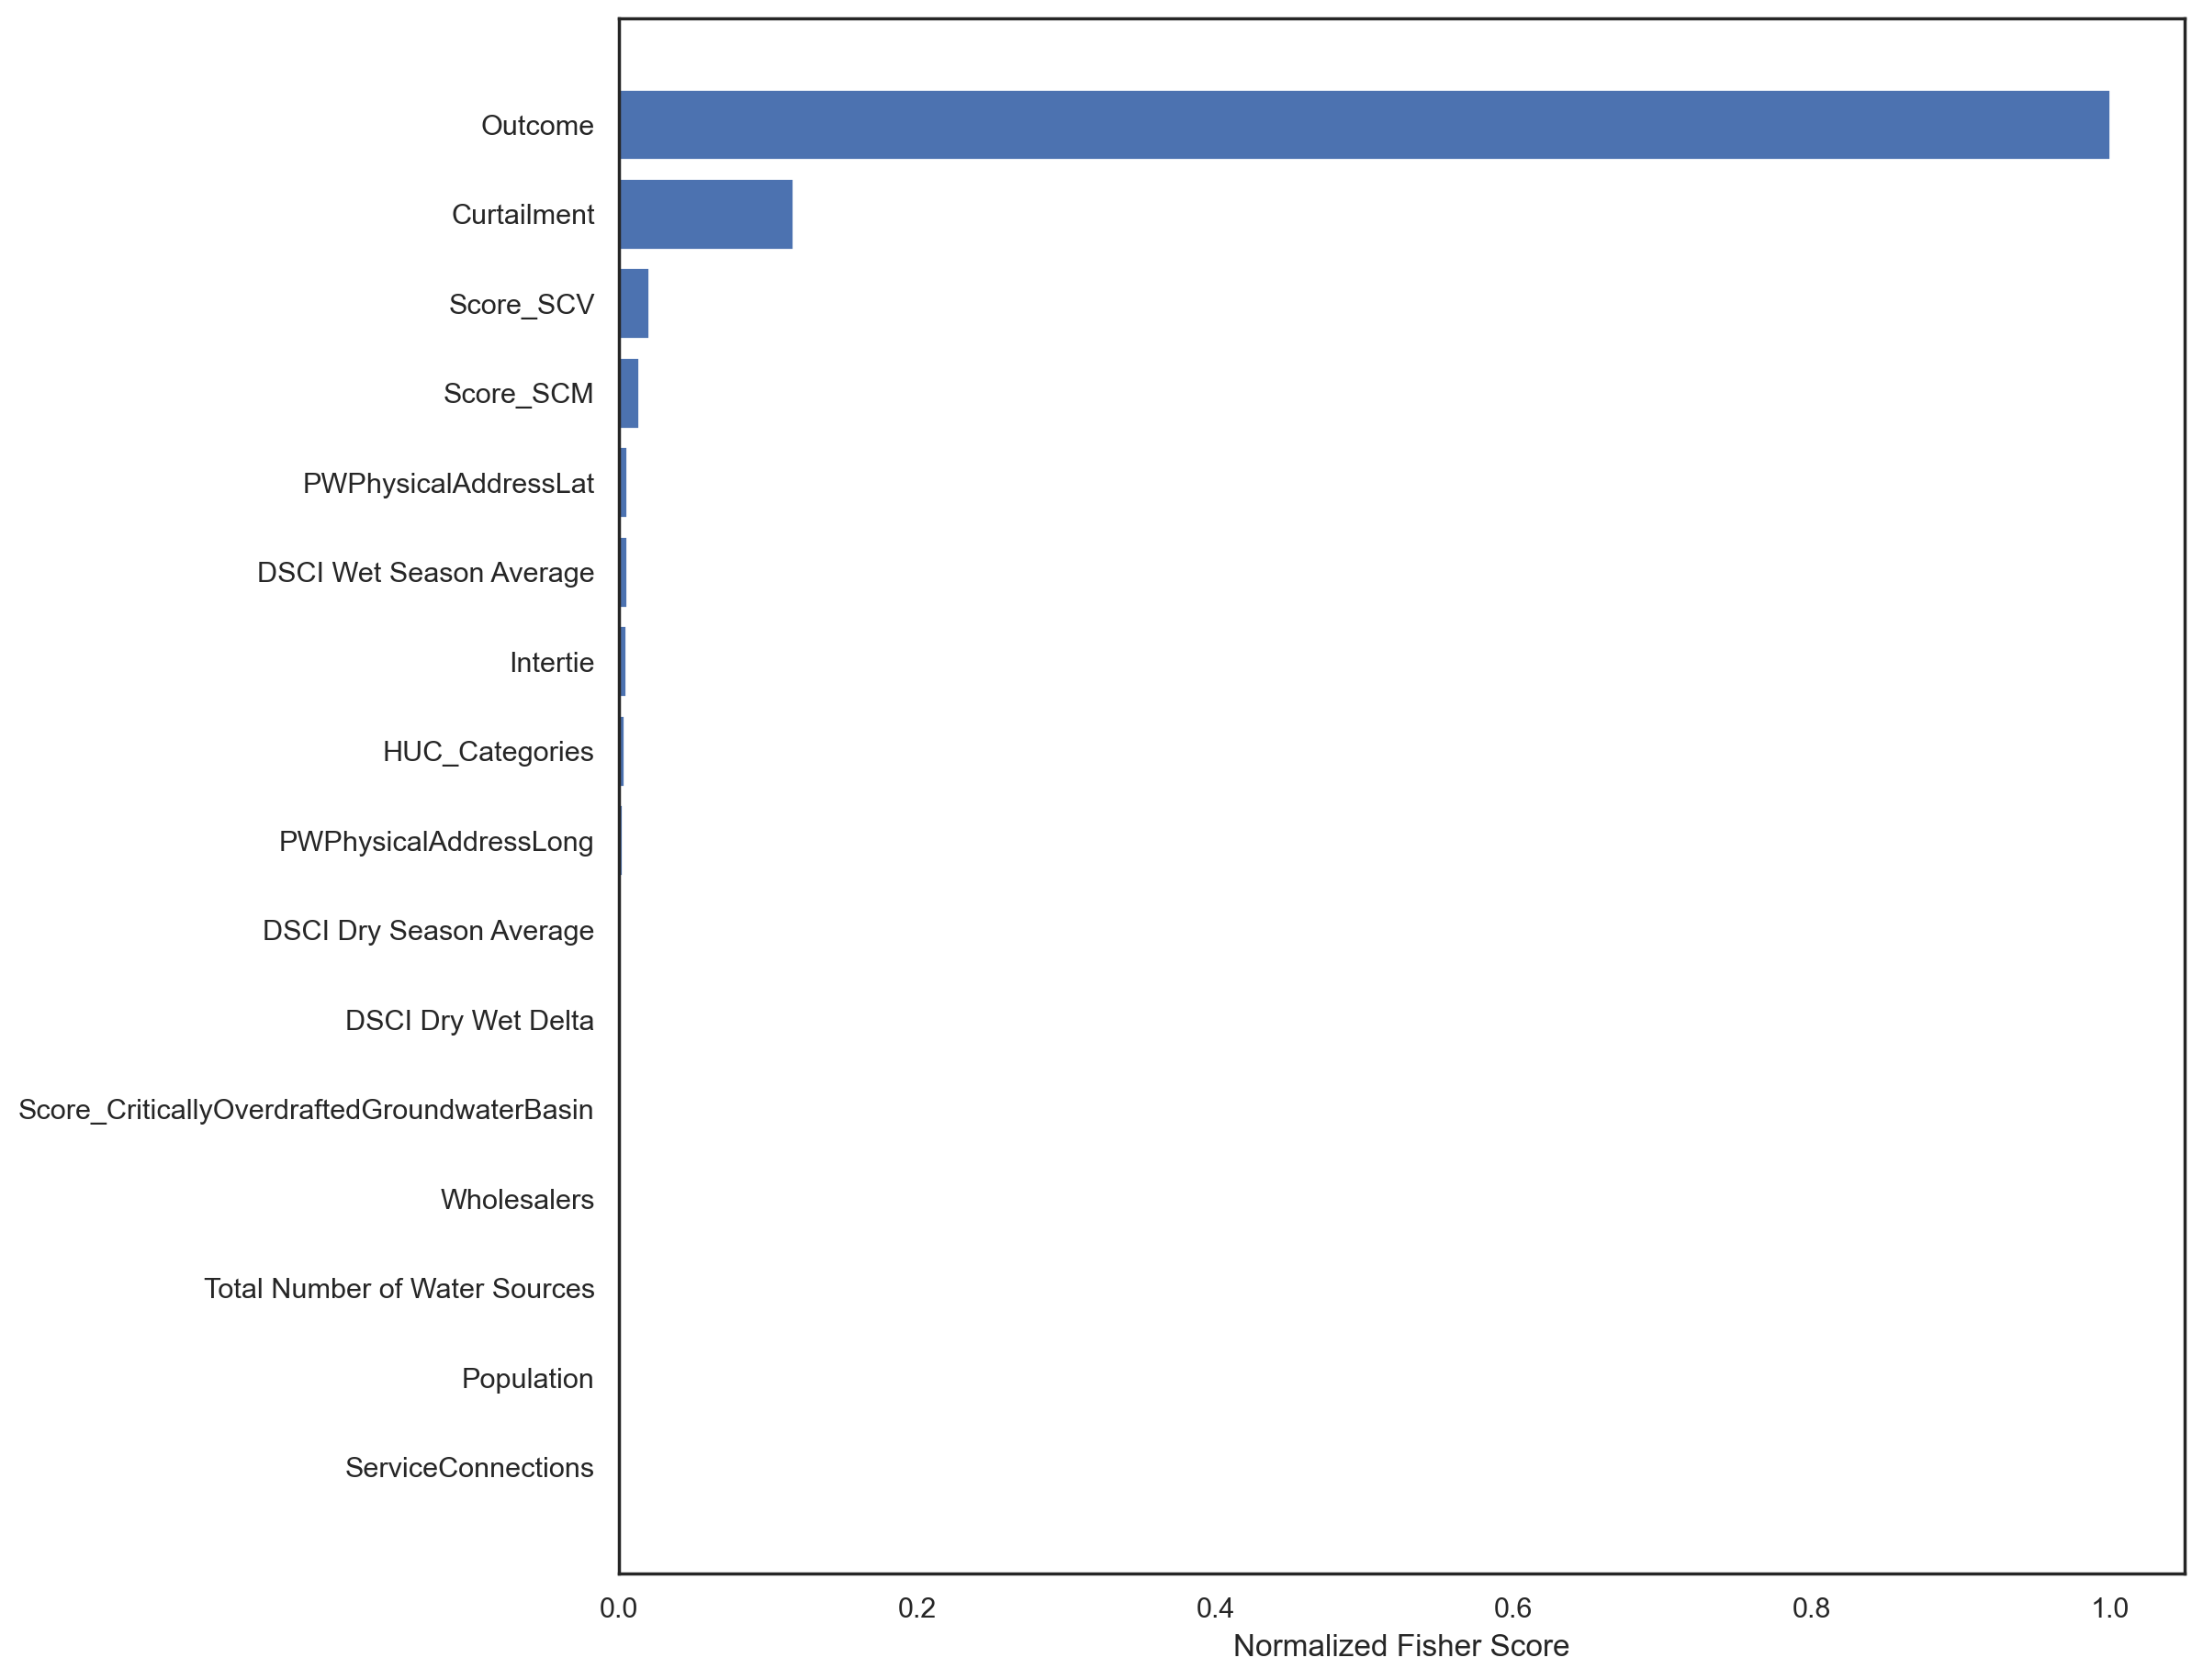

In [198]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

# Select method and fit
selector=SelectKBest(f_classif, k='all')
selector.fit(X, y)
scores_fisher = selector.scores_
scores_fisher[np.isnan(scores_fisher)] = 0.0

# Select, sort, and normalize features
features = X_train.columns.to_list()
order = np.argsort(scores_fisher)
ordered_features_fisher = [features[i] for i in order]
ordered_normalized_scores_fisher = sorted(scores_fisher/np.nanmax(scores_fisher))
ordered_scores_fisher = sorted(scores_fisher)

ax.barh(ordered_features_fisher, ordered_normalized_scores_fisher)
ax.set(xlabel = 'Normalized Fisher Score')
#fig.savefig('features.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 3: Can we generate any counterfactual examples?

A counterfactual example explains what would have had to happen to get the desired result. From the DiCE website: "Given that the model's output for input $x$ is $y$, what would be the output if input is changed to $x'$?"
Looking at counterfactual examples with [DiCE](https://github.com/interpretml/DiCE).

In [199]:
# Construct the dataframe of examples with the label for DiCE
X_train_dice = df_X_train
X_val_dice = df_X_val

In [200]:
X_train_dice = X_train_dice.assign(DroughtExperienced=df_y_train['DroughtExperienced'].values)
X_val_dice = X_val_dice.assign(DroughtExperienced=df_y_val['DroughtExperienced'].values)

In [204]:
# Drop CWSID
X_train_dice = X_train_dice.drop(columns=['CWSID', 'Water Year', 'HUC8'])
X_val_dice = X_val_dice.drop(columns=['CWSID', 'Water Year', 'HUC8'])

In [205]:
# Create the DiCE data
d = dice_ml.Data(dataframe=X_train_dice, continuous_features=numeric_features, outcome_name='DroughtExperienced')

In [206]:
# Initialize the model
clf = svm.SVC(gamma='auto', kernel='rbf', C=4, class_weight={0:1, 1: 5}, probability=True)

# Fit the model
model = clf.fit(X_train, y_train)

# Create the DiCE model
m = dice_ml.Model(model=model, backend="sklearn")

In [207]:
# Create the DiCE explainer
dice_explainer = dice_ml.Dice(d, m, method="kdtree")

In [208]:
df_y_comparison = pd.DataFrame({'y_pred':y_pred, 'y_val':y_val})

In [209]:
false_negatives_index = df_y_comparison[(y_pred == 0) & (y_val == 1)].index

In [211]:
print("There are {} false negatives.".format(len(false_negatives_index)))

There are 11 false negatives.


In [210]:
df_y_val.iloc[false_negatives_index][0:3]

CWSID  Water Year      HUC8  DroughtExperienced
3878  CA2310006        2022  18010110                   1
5151  CA4700503        2022  18010208                   1
3046  CA0910013        2022  18020128                   1

In [213]:
df_X_val.iloc[false_negatives_index][0:3]

CWSID  Water Year      HUC8  ServiceConnections  Population  \
1012  CA2310006        2021  18010110              1609.0        5500   
2285  CA4700503        2021  18010208                34.0          70   
180   CA0910013        2021  18020128              3733.0        9112   

      PWPhysicalAddressLat  PWPhysicalAddressLong  DSCI Dry Season Average  \
1012             39.125805            -123.205817               300.000000   
2285             41.309588            -122.801418               400.000000   
180              38.912373            -120.833732               314.318182   

      DSCI Wet Season Average  DSCI Dry Wet Delta  \
1012               246.010769           53.989231   
2285               329.102692           70.897308   
180                216.788846           97.529336   

      Total Number of Water Sources  Score_SCV  Score_SCM  \
1012                           20.0        0.0        0.0   
2285                            1.0        0.0        1.0   
180                             1.0        0.0        0.0   

      Score_CriticallyOverdraftedGroundwaterBasin  Intertie  Wholesalers  \
1012                                            0       0.0          0.0   
2285                                            0       0.0          0.0   
180                                             0       0.0          0.0   

      Curtailment  HUC_Categories  Outcome  
1012            1               3        1  
2285            1               3        0  
180             1               2        0

In [215]:
X_val_dice = X_val_dice.drop(columns='DroughtExperienced')
X_train_dice = X_train_dice.drop(columns='DroughtExperienced')

In [216]:
dice_counterfactuals = dice_explainer.generate_counterfactuals(X_val_dice.iloc[false_negatives_index][0:3], 
                                                               total_CFs=4, desired_class="opposite")

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.76it/s]


In [217]:
dice_counterfactuals.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0              1609.0        5500             39.125805   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -123.205818                    300.0               246.010773   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           53.989231                           20.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  DroughtExperienced  
0           1              3       1                   0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
1011             1073.0     3797.0              39.1258             -123.2058   
1014             1317.0     5200.0             39.27334             -123.1754   
646              1800.0     5928.0             38.94725             -122.6245   
2511             2065.0     6082.0             37.59762             -120.8646   

     DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
1011                       -                246.0108          53.989231   
1014                       -                246.0108          53.989231   
646                    333.7                315.0161          18.697483   
2511                   399.1                297.5062         101.560211   

     Total Number of Water Sources Score_SCV Score_SCM  \
1011                           5.0         -         -   
1014                           1.0         -       1.0   
646                            3.0         -         -   
2511                           3.0         -         -   

     Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
1011                                           -        -           -   
1014                                           -        -           -   
646                                            -      1.0           -   
2511                                           -        -           -   

     Curtailment HUC_Categories Outcome DroughtExperienced  
1011           -              -       -                  -  
1014           -              -       -                  -  
646            -              2       0                  -  
2511           0              2       0                  -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0                34.0          70             41.309589   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -122.801414                    400.0               329.102692   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           70.897308                            1.0       0.0       1.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  DroughtExperienced  
0           1              3       0                   0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
1431               82.0      160.0              33.5972             -116.4497   
2533               17.0       50.0             39.14988             -121.6636   
170                52.0       79.0             38.90685             -120.8385   
2382               22.0       66.0             38.78972             -123.0152   

     DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
1431                   294.7                252.9185          41.758358   
2533                   389.4                329.0916          60.351189   
170                    341.8                226.6927         115.118217   
2382                   300.0                246.0108          53.989231   

     Total Number of Water Sources Score_SCV Score_SCM  \
1431                             -         -         -   
2533                             -         -       0.0   
170                              -         -       0.0   
2382                             -         -       0.0   

     Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
1431                                           -        -           -   
2533                                           -        -           -   
170                                            -        -           -   
2382                                           -        -           -   

     Curtailment HUC_Categories Outcome DroughtExperienced  
1431           0              -       -                  -  
2533           0              2       -                  -  
170            -              2       -                  -  
2382           -              -       1                  -

Query instance (original outcome : 0)


ServiceConnections  Population  PWPhysicalAddressLat  \
0              3733.0        9112             38.912373   

   PWPhysicalAddressLong  DSCI Dry Season Average  DSCI Wet Season Average  \
0            -120.833733               314.318176               216.788849   

   DSCI Dry Wet Delta  Total Number of Water Sources Score_SCV Score_SCM  \
0           97.529335                            1.0       0.0       0.0   

  Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
0                                           0      0.0         0.0   

  Curtailment HUC_Categories Outcome  DroughtExperienced  
0           1              2       0                   0


Diverse Counterfactual set (new outcome: 1)


ServiceConnections Population PWPhysicalAddressLat PWPhysicalAddressLong  \
2443             3266.0     9157.0              38.8063             -123.0175   
2511             2065.0     6082.0             37.59762             -120.8646   
646              1800.0     5928.0             38.94725             -122.6245   
1266             1252.0     3148.0              39.2472             -121.0023   

     DSCI Dry Season Average DSCI Wet Season Average DSCI Dry Wet Delta  \
2443                   300.0                246.0108          53.989231   
2511                   399.1                297.5062         101.560211   
646                    333.7                315.0161          18.697483   
1266                   307.9                229.7815          78.125732   

     Total Number of Water Sources Score_SCV Score_SCM  \
2443                           7.0         -         -   
2511                           3.0         -         -   
646                            3.0         -         -   
1266                             -         -         -   

     Score_CriticallyOverdraftedGroundwaterBasin Intertie Wholesalers  \
2443                                           -        -           -   
2511                                           -        -           -   
646                                            -      1.0           -   
1266                                           -        -           -   

     Curtailment HUC_Categories Outcome DroughtExperienced  
2443           -              3       -                  -  
2511           0              -       -                  -  
646            -              -       -                  -  
1266           -              -       1                  -

### Question 4: How does the false positive rate and false negative rate change as a function of class weight?

Figure out how many positive examples are in the test set.

In [202]:
def test_sample_weights(C, max_range, step_size):
    
    # Convert validation labels into a numpy array
    y_val_np = np.array(y_val)
    
    # Create an empty dataframe
    out = [np.NaN]*int(max_range/step_size)
    df_weight = pd.DataFrame({'C':out, 'weight':out,
                          'total_false_positives':out, 'total_false_negatives':out,
                          'total_misclassifications':out})
    
    # Define some counters
    count_misclassifications = 0
    count_false_positive = 0
    count_false_negative = 0
    count_true_positive = 0
    count_true_negative = 0

    print ("C:", C)
    
    for i in range(0, max_range, step_size):
            
            # Define a counter
            df_weight['C'].iloc[i]=C
            positive_class_weight = i+1
            df_weight['weight'].iloc[i] = positive_class_weight
            print("--> Sample weight:", positive_class_weight)

            # Initialize the model
            clf = svm.SVC(gamma='auto', kernel='rbf', C=C, class_weight={0:1, 1: positive_class_weight}, probability=True)

            # Fit the model
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_val_scaled)

            for j in range(len(y_val_np)):
                if y_val_np[j] != y_pred[j]:
                    count_misclassifications += 1
                if ((y_val_np[j] == 1.0) and (y_pred[j] == 0.0)):
                    count_false_negative += 1      
                if ((y_val_np[j] == 0.0) and (y_pred[j] == 1.0)):
                    count_false_positive += 1    
                if ((y_val_np[j] == 1.0) and (y_pred[j] == 1.0)):
                    count_true_positive += 1      
                if ((y_val_np[j] == 0.0) and (y_pred[j] == 0.0)):
                    count_true_negative += 1    

            df_weight['total_misclassifications'].iloc[i] = count_misclassifications
            df_weight['total_false_negatives'].iloc[i] = count_false_negative
            df_weight['total_false_positives'].iloc[i] = count_false_positive

            count_misclassifications = 0
            count_false_positive = 0
            count_false_negative = 0
            count_true_positive = 0
            count_true_negative = 0
            
    return df_weight

In [203]:
df_weights = []
for i in (0.5, 1.0, 2.0, 4.0, 8.0):
    df_weight = test_sample_weights(C = i, max_range=20, step_size=1)
    df_weights.append(df_weight)

C: 0.5
--> Sample weight: 1
--> Sample weight: 2
--> Sample weight: 3
--> Sample weight: 4
--> Sample weight: 5
--> Sample weight: 6
--> Sample weight: 7
--> Sample weight: 8
--> Sample weight: 9
--> Sample weight: 10
--> Sample weight: 11
--> Sample weight: 12
--> Sample weight: 13
--> Sample weight: 14
--> Sample weight: 15
--> Sample weight: 16
--> Sample weight: 17
--> Sample weight: 18
--> Sample weight: 19
--> Sample weight: 20
C: 1.0
--> Sample weight: 1
--> Sample weight: 2
--> Sample weight: 3
--> Sample weight: 4
--> Sample weight: 5
--> Sample weight: 6
--> Sample weight: 7
--> Sample weight: 8
--> Sample weight: 9
--> Sample weight: 10
--> Sample weight: 11
--> Sample weight: 12
--> Sample weight: 13
--> Sample weight: 14
--> Sample weight: 15
--> Sample weight: 16
--> Sample weight: 17
--> Sample weight: 18
--> Sample weight: 19
--> Sample weight: 20
C: 2.0
--> Sample weight: 1
--> Sample weight: 2
--> Sample weight: 3
--> Sample weight: 4
--> Sample weight: 5
--> Sample w

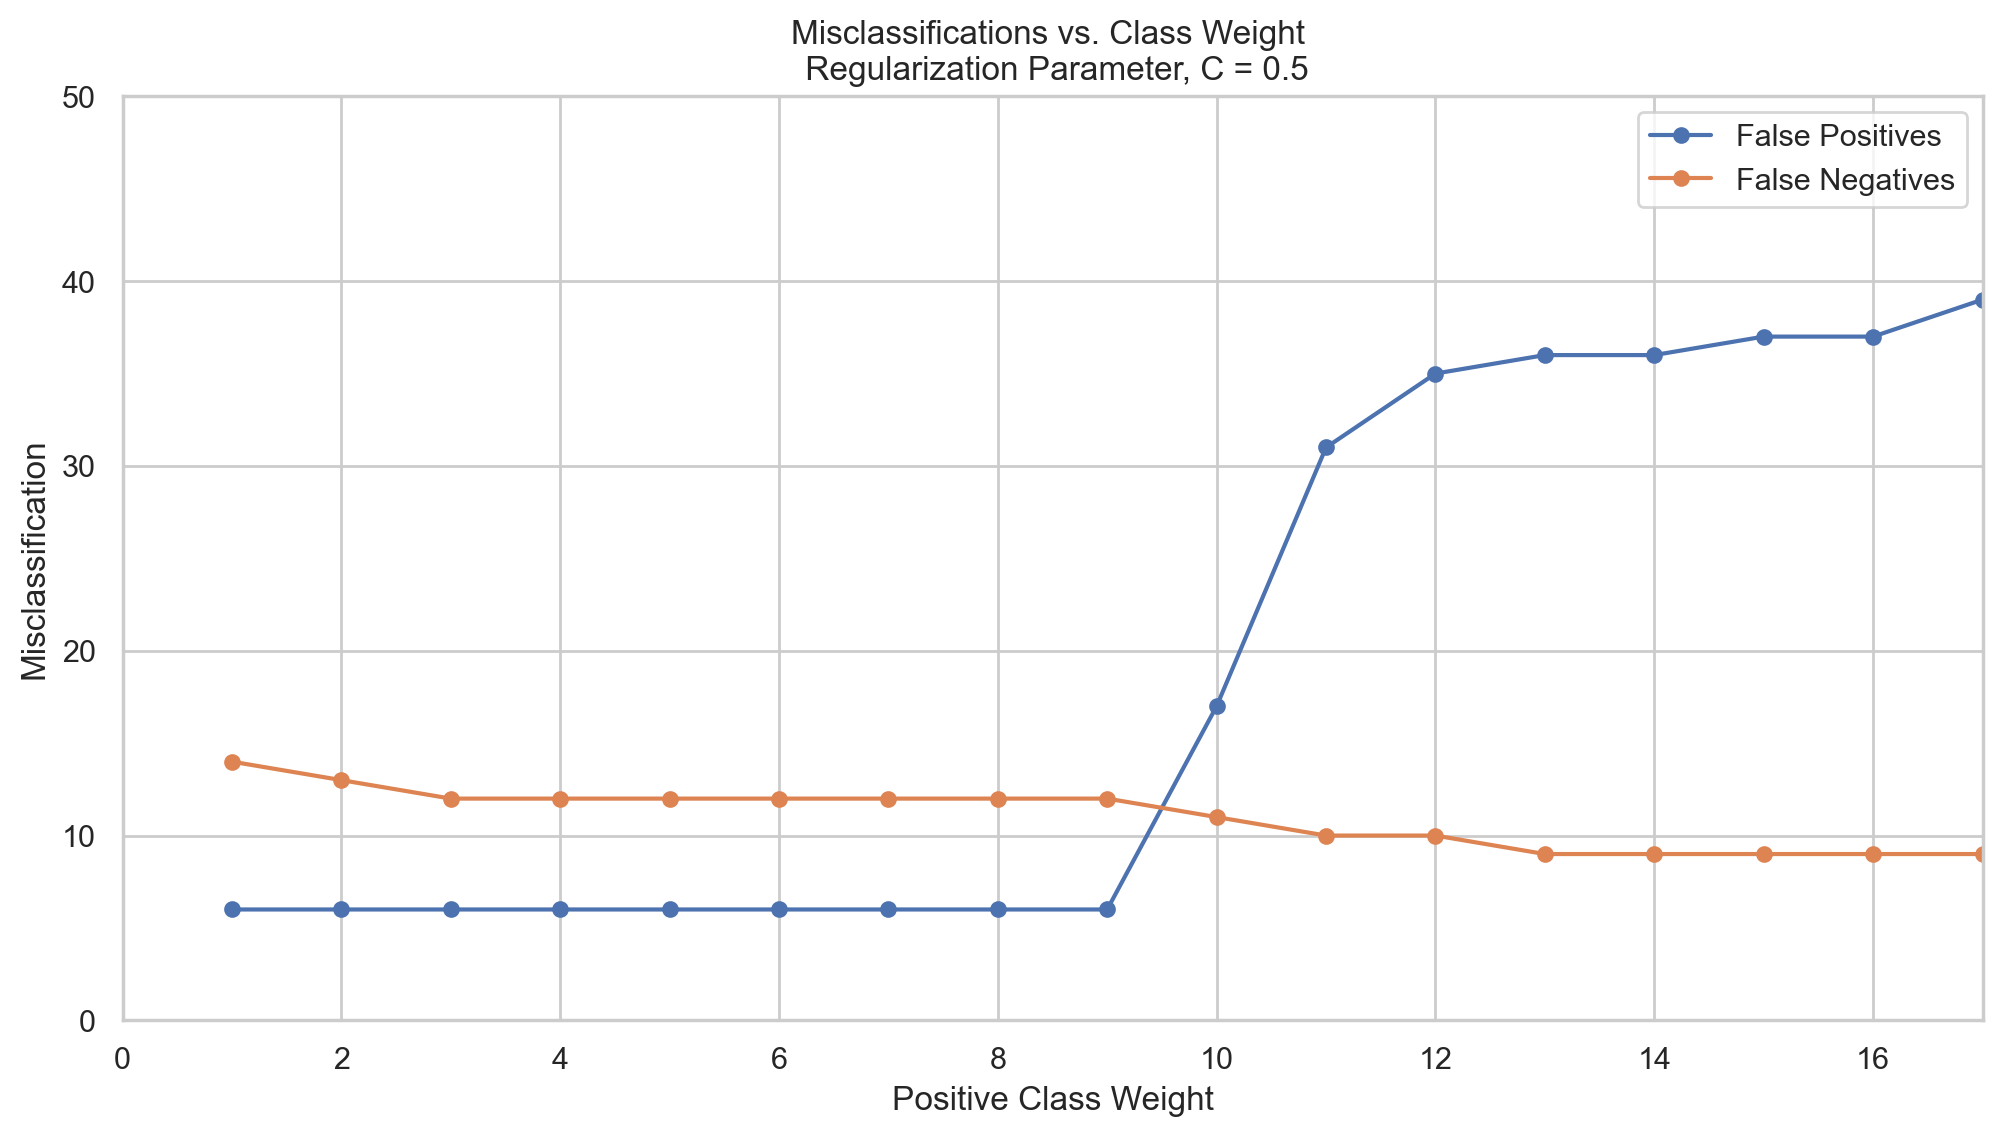

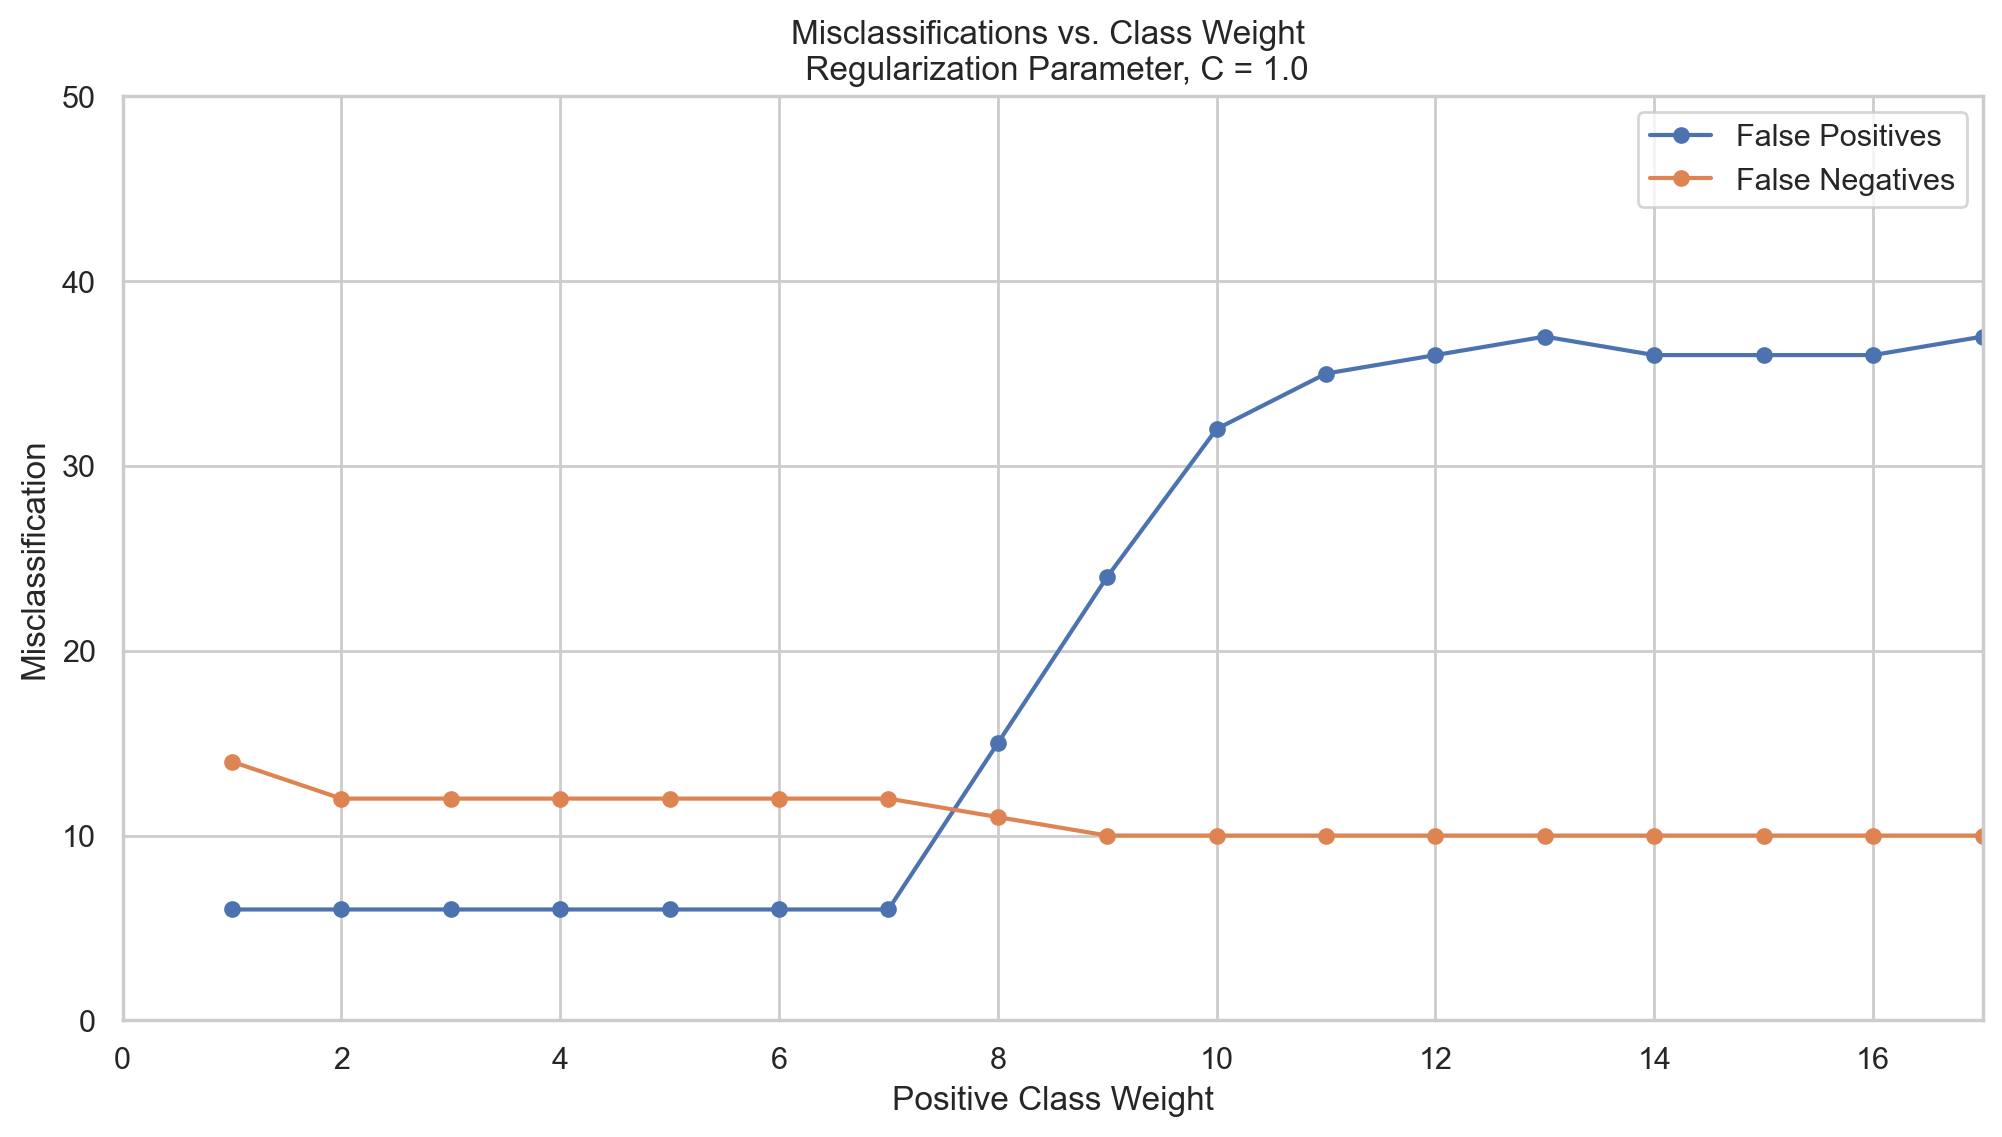

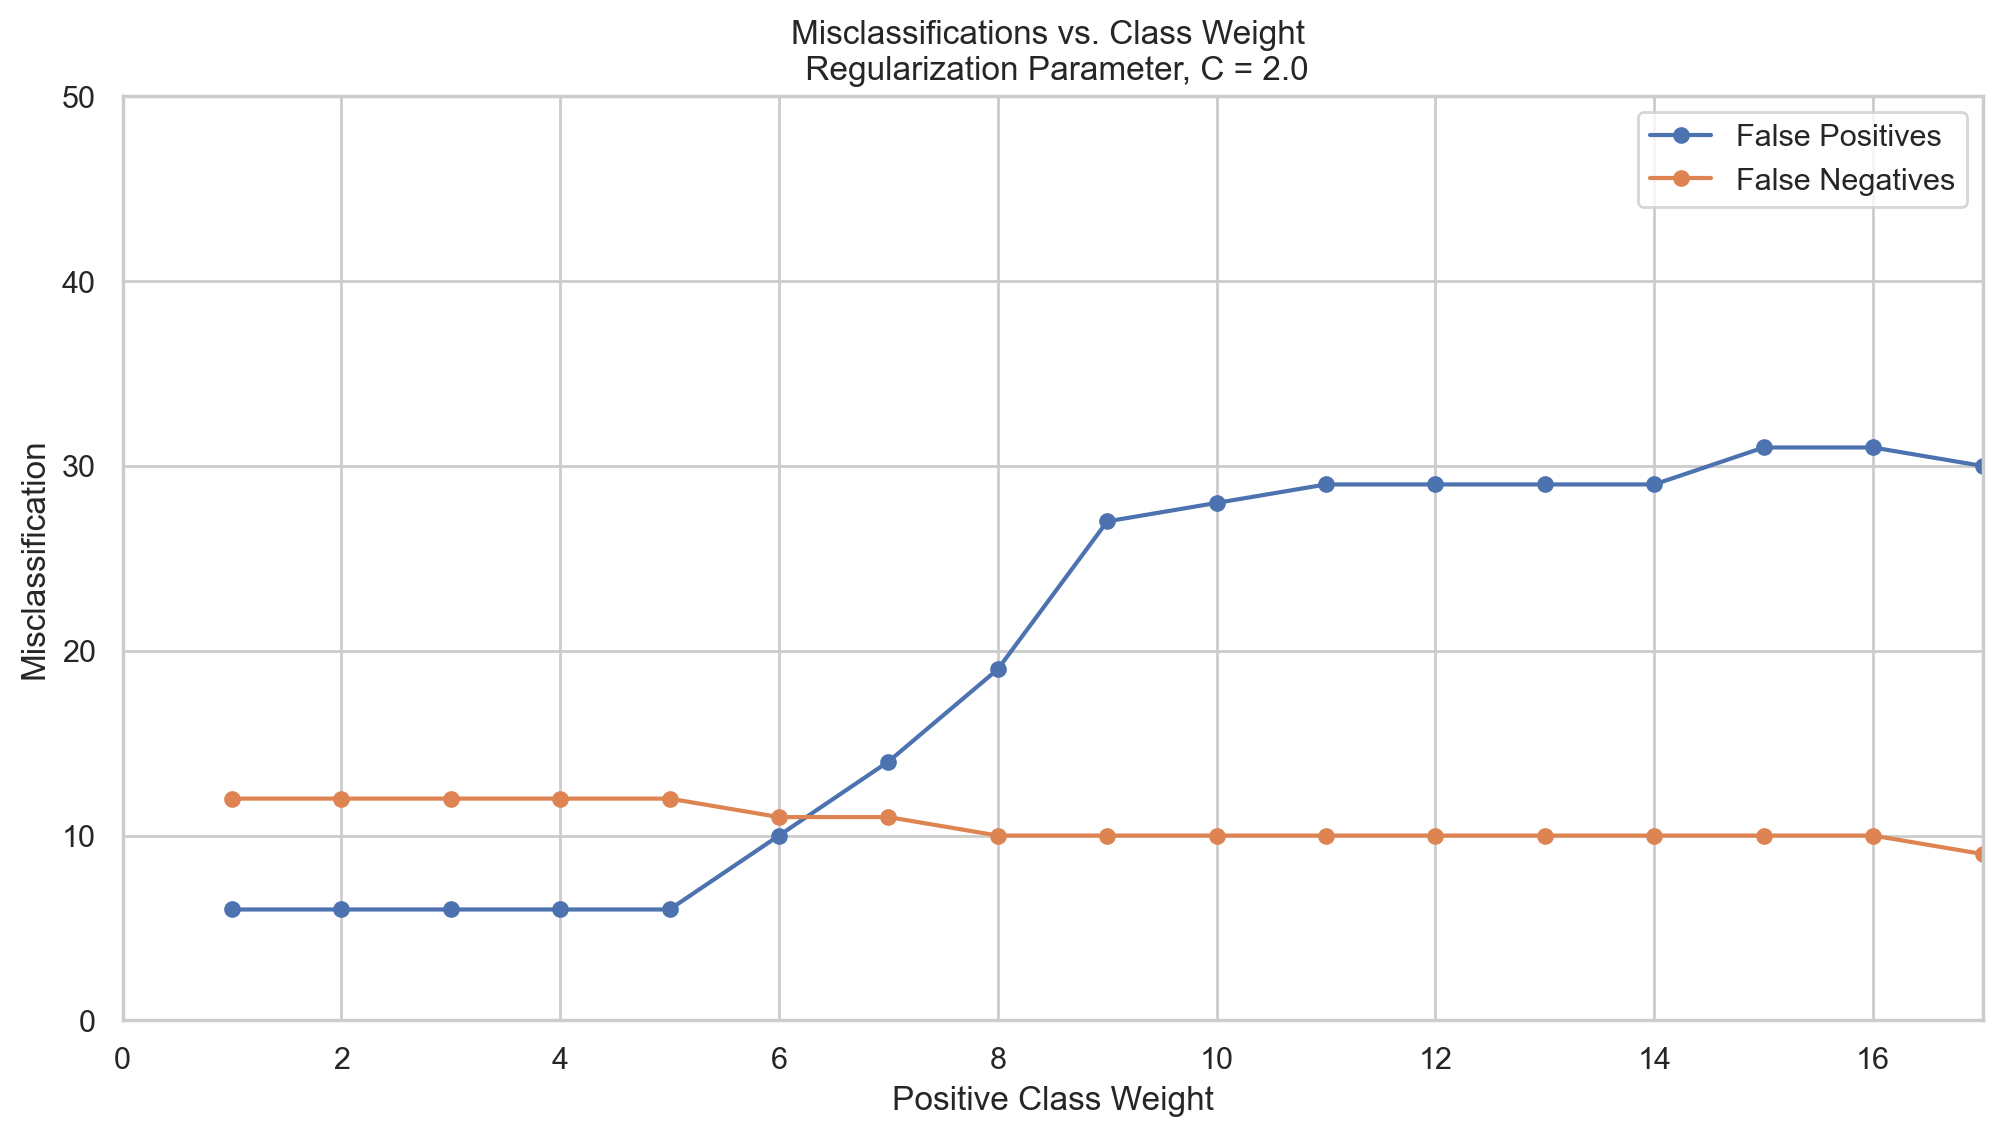

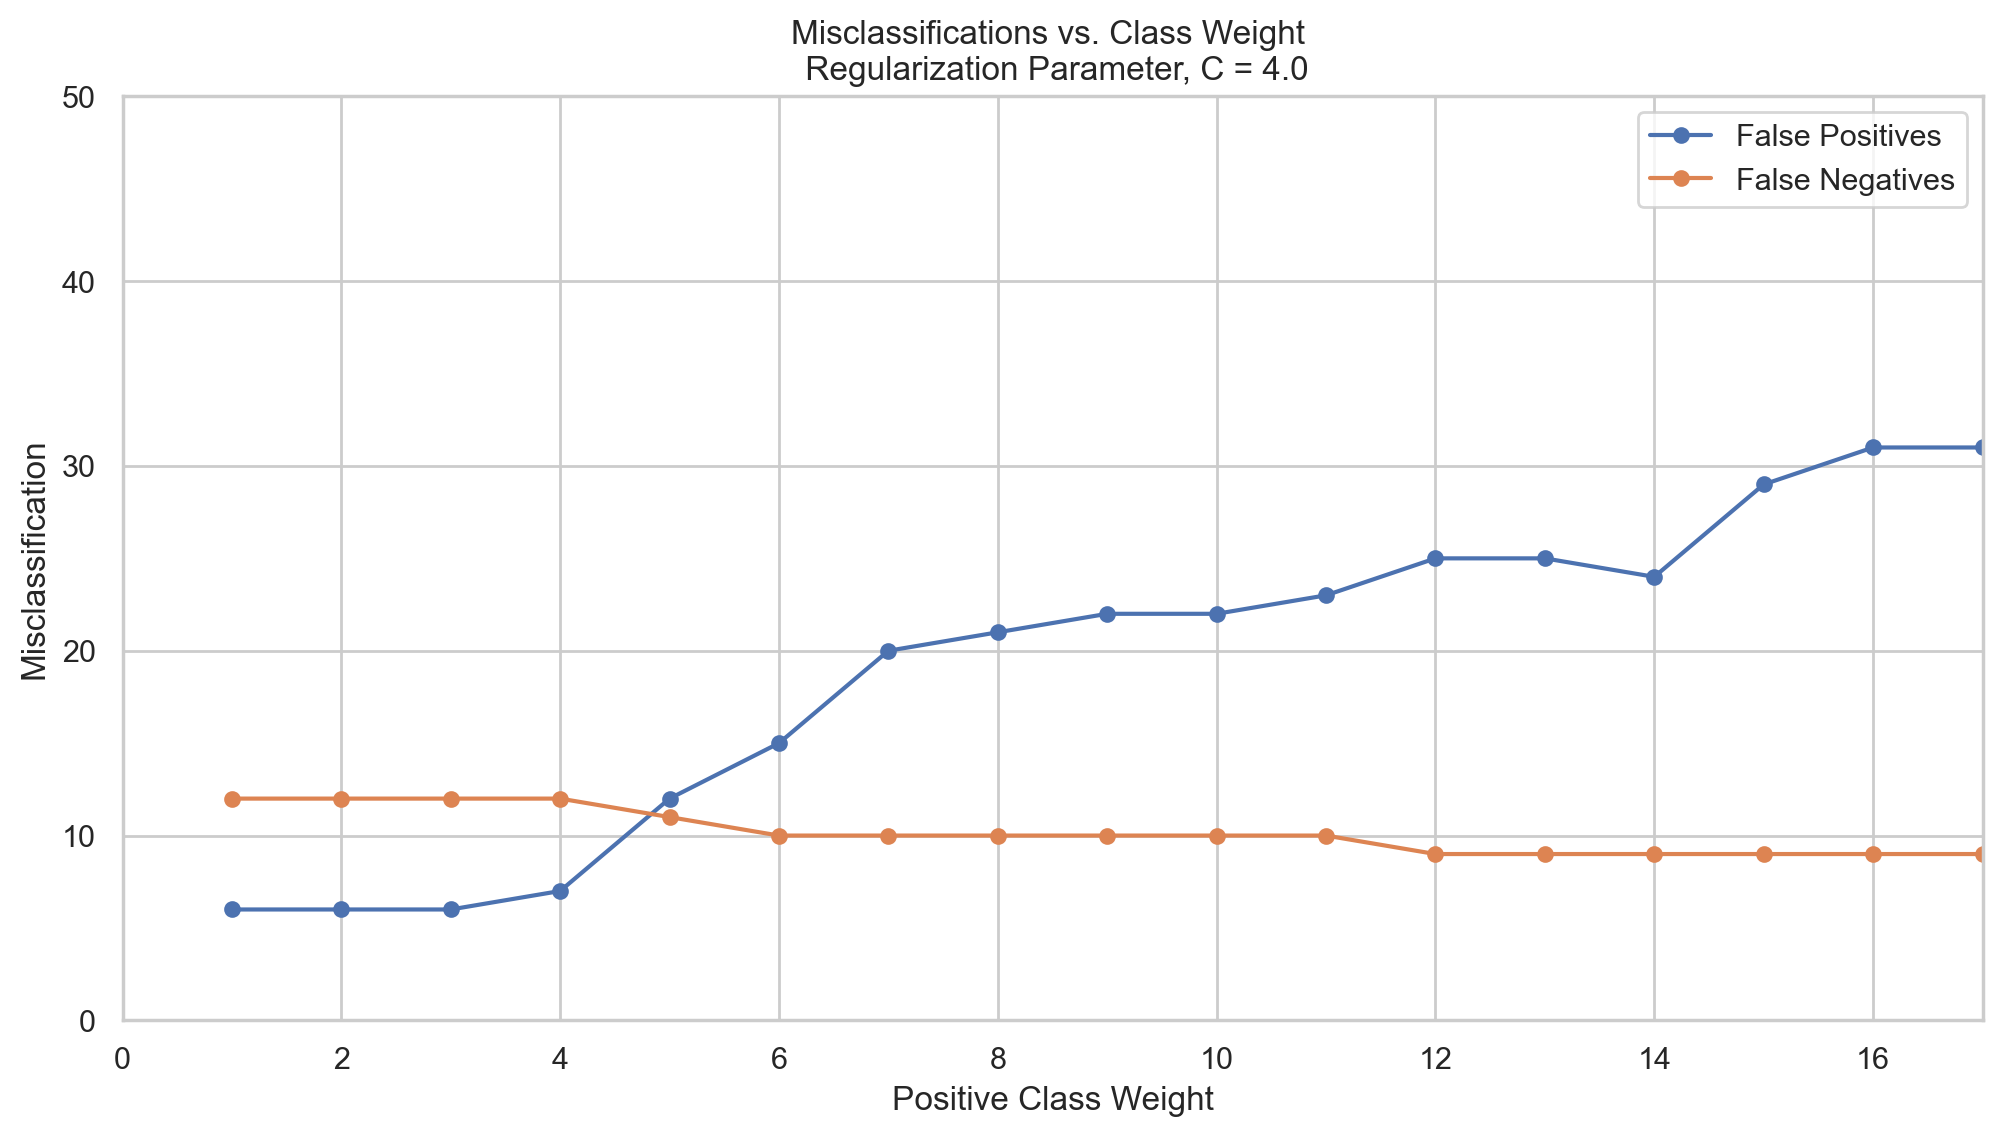

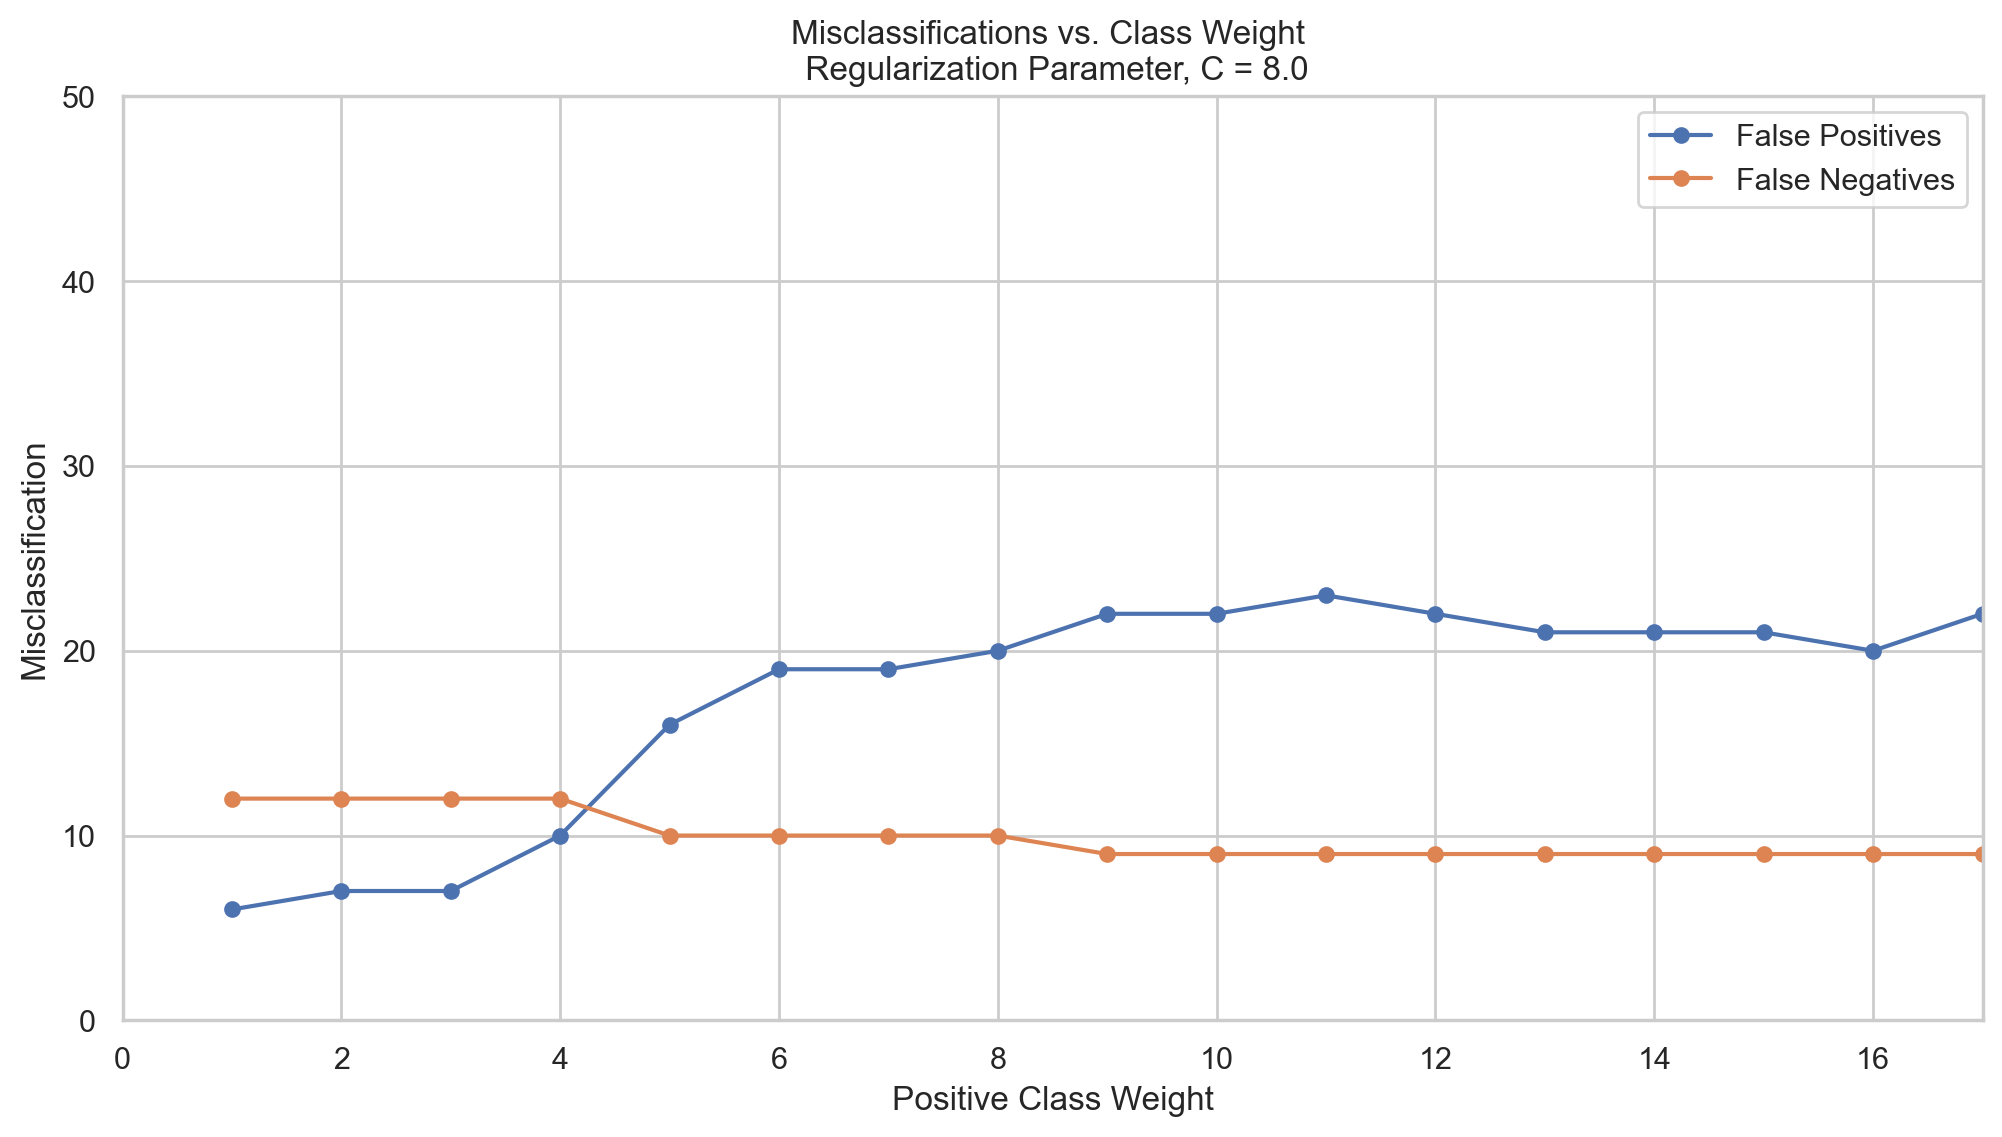

In [204]:
for i in range(len(df_weights)):
    fig, ax = plt.subplots(figsize=(12,6))
    sns.set_theme(style='whitegrid')
    ax.errorbar(df_weights[i]['weight'], df_weights[i]['total_false_positives'], marker=".", markersize=10, label='False Positives')
    ax.errorbar(df_weights[i]['weight'], df_weights[i]['total_false_negatives'], marker=".", markersize=10, label='False Negatives')
    ax.set_ylabel('Misclassification')
    ax.set_xlabel('Positive Class Weight')
    C = (df_weights[i]['C'][0])
    ax.set_title('Misclassifications vs. Class Weight \n Regularization Parameter, C = '+str(C))
    ax.legend()
    ax.set_ylim(0,50)
    ax.set_xlim(0,17)
    #fig.savefig('weightsversusmisclassifications_C_'+str(C)+'_svm.png', dpi=300, transparent=True, bbox_inches='tight')

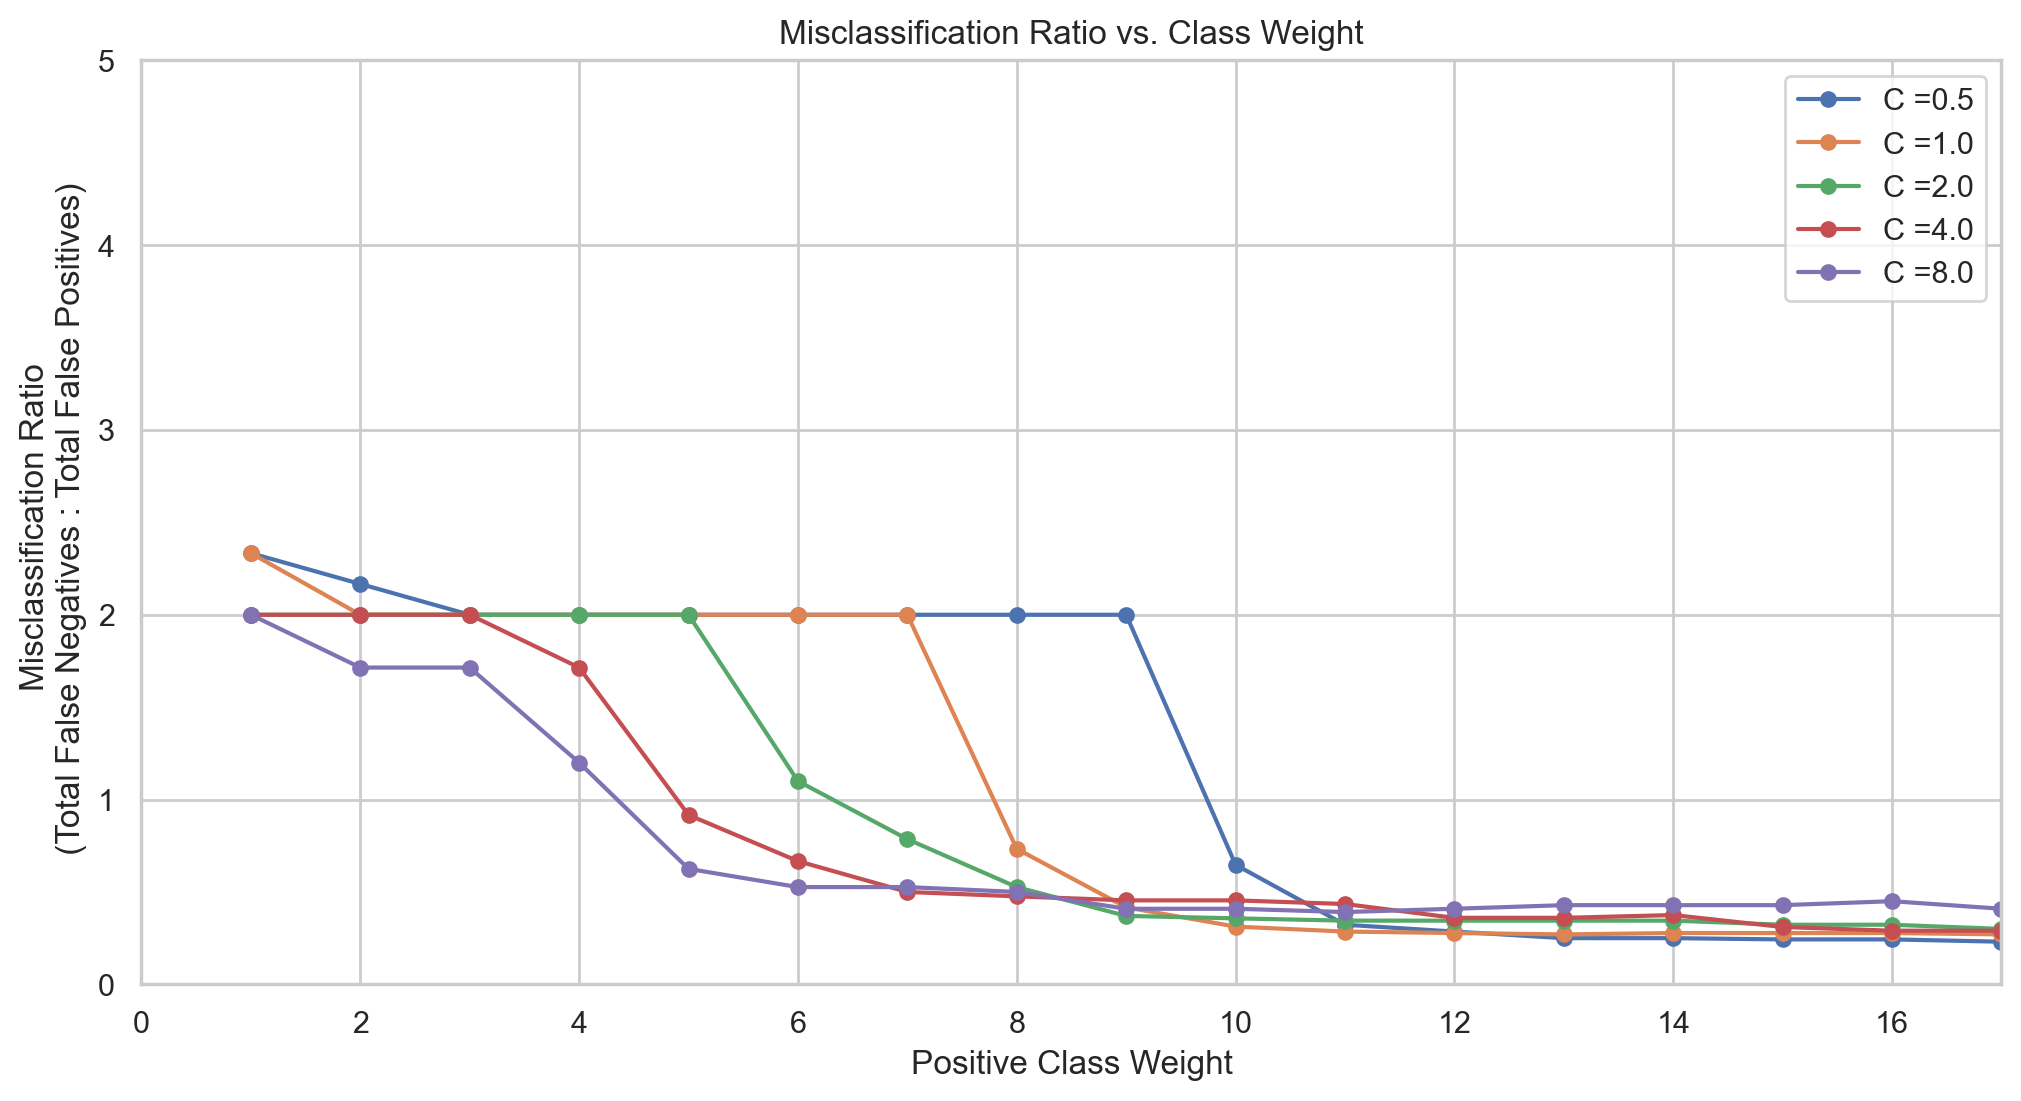

In [205]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(df_weights[0]['weight'].astype('int'), 
            df_weights[0]['total_false_negatives']/df_weights[0]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[0]['C'][0]))
ax.errorbar(df_weights[1]['weight'].astype('int'), 
            df_weights[1]['total_false_negatives']/df_weights[1]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[1]['C'][0]))
ax.errorbar(df_weights[2]['weight'].astype('int'), 
            df_weights[2]['total_false_negatives']/df_weights[2]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[2]['C'][0]))
ax.errorbar(df_weights[3]['weight'].astype('int'), 
            df_weights[3]['total_false_negatives']/df_weights[3]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[3]['C'][0]))
ax.errorbar(df_weights[4]['weight'].astype('int'), 
            df_weights[4]['total_false_negatives']/df_weights[4]['total_false_positives'],
            marker=".", markersize=10, label='C ='+str(df_weights[4]['C'][0]))
ax.set_ylabel('Misclassification Ratio \n (Total False Negatives : Total False Positives)')
ax.set_xlabel('Positive Class Weight')
ax.set_title('Misclassification Ratio vs. Class Weight')
ax.set_ylim(0,5)
ax.set_xlim(0,17)
ax.legend()
#fig.savefig('weightsversusmisclassificationsratio_estimators_svm.png', dpi=300, transparent=True, bbox_inches='tight')

### Question 5: Which label performs the best?

Plot the skill score as a function of number of features per label.

Note that the label `WaterOutageDroughtViolation` only has three examples, so it cannot be reliably split across training and test when stratifying by HUC category.

In [266]:
df_water_year_2022 = df_combined[df_combined['Water Year'] == 2022]

In [270]:
print("Number of positive examples in DroughtExperienced:",len(df_water_year_2022[df_water_year_2022['DroughtExperienced'] == 1]))
print("Number of positive examples in WaterOutageDroughtViolation:",len(df_water_year_2022[df_water_year_2022['WaterOutageDroughtViolation'] == 1]))
print("Number of positive examples in BottledHauledWaterOrZeroSource:",len(df_water_year_2022[df_water_year_2022['BottledHauledWaterOrZeroSource'] == 1]))
print("Number of positive examples in CurtailmentExemptionPetition:",len(df_water_year_2022[df_water_year_2022['CurtailmentExemptionPetition'] == 1]))

Number of positive examples in DroughtExperienced: 122
Number of positive examples in WaterOutageDroughtViolation: 3
Number of positive examples in BottledHauledWaterOrZeroSource: 66
Number of positive examples in CurtailmentExemptionPetition: 53


In [271]:
outcome_label = [
 'DroughtExperienced',
 'BottledHauledWaterOrZeroSource',
 'CurtailmentExemptionPetition']

In [272]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

In [273]:
print(ordered_features_fisher)

['ServiceConnections', 'Population', 'Total Number of Water Sources', 'Wholesalers', 'Score_CriticallyOverdraftedGroundwaterBasin', 'DSCI Dry Wet Delta', 'DSCI Dry Season Average', 'PWPhysicalAddressLong', 'HUC_Categories', 'Intertie', 'DSCI Wet Season Average', 'PWPhysicalAddressLat', 'Score_SCM', 'Score_SCV', 'Curtailment', 'Outcome']


In [274]:
TSS_values_per_label = []
TSS_std_per_label = []

for k in range(len(outcome_label)):
    TSS_values = []
    TSS_std = []
    
    # Construct the features        
    X = df_combined[df_combined['Water Year'] == 2021]
    X = X.drop(columns=temporary_features)
    X = X.rename(columns={'DroughtExperienced' : 'Outcome'})
    X = X[ordered_features_fisher]

    # Construct and select the label
    y = df_combined[outcome_label[k]][df_combined['Water Year'] == 2022]
    print(outcome_label[k])
    y = y.drop(columns=temporary_features)

    # Construct the splits
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.36, random_state=77, stratify=X['HUC_Categories'])

    # Unravel the label
    y_val = y_val.values.ravel()
    y_train = y_train.values.ravel()
    
    for i in range(len(ordered_features_fisher)):
        
        # Select the features
        X_train = X_train[ordered_features_fisher[i:]]
        X_val = X_val[ordered_features_fisher[i:]]
        total_features = X_train.columns.to_list()
        
        # Identify the numeric and categorical features
        total_numeric_features = list(set(total_features).intersection(numeric_features))
        total_categorical_features = list(set(total_features).intersection(categorical_features))
        
        TSS_scores = []
        for j in range(3):    # This should eventually be 100

            # Select and scale the numeric features
            if total_numeric_features:
                scaler = preprocessing.StandardScaler()
                X_train_numeric = X_train[total_numeric_features]
                X_val_numeric = X_val[total_numeric_features]
                X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
                X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

            # Select the categorical features
            if total_categorical_features:
                X_train_categorical = np.array(X_train[total_categorical_features])
                X_val_categorical = np.array(X_val[total_categorical_features])

            # Create training and validation sets
            if total_numeric_features and total_categorical_features:
                X_train_scaled = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
                X_val_scaled = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)
            if total_numeric_features and not total_categorical_features:
                X_train_scaled = X_train_numeric_scaled
                X_val_scaled = X_val_numeric_scaled
            if not total_numeric_features and total_categorical_features:
                X_train_scaled = X_train_categorical
                X_val_scaled = X_val_categorical

            # Train the model
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_val_scaled)
            
            # Calculate TSS
            TN, FP, TP, FN = confusion_table(np.array(y_pred), np.array(y_val))
            TSS_score = TP/(TP+FN) - FP/(FP+TN)
            TSS_scores.append(TSS_score)
        
        TSS_std.append(np.std(TSS_scores))
        TSS_values.append(np.mean(TSS_scores))
        print(i,np.mean(TSS_scores), np.std(TSS_scores))

    TSS_std_per_label.append(TSS_std)
    TSS_values_per_label.append(TSS_values)

DroughtExperienced
0 0.7413711583924348 1.1102230246251565e-16
1 0.7423843296183722 0.0
2 0.7656197230665316 0.0
3 0.7666328942924686 1.1102230246251565e-16
4 0.767646065518406 0.0
5 0.767646065518406 0.0
6 0.767646065518406 0.0
7 0.7706855791962175 0.0
8 0.7706855791962175 0.0
9 0.7706855791962175 0.0
10 0.7696724079702802 1.1102230246251565e-16
11 0.7696724079702802 1.1102230246251565e-16
12 0.7716987504221547 0.0
13 0.7716987504221547 0.0
14 0.7716987504221547 0.0
15 0.7716987504221547 0.0
BottledHauledWaterOrZeroSource
0 0.761278482948463 1.1102230246251565e-16
1 0.761278482948463 1.1102230246251565e-16
2 0.7602844471631749 0.0
3 0.7592904113778866 0.0
4 0.761278482948463 1.1102230246251565e-16
5 0.7622725187337513 0.0
6 0.761278482948463 1.1102230246251565e-16
7 0.7602844471631749 0.0
8 0.761278482948463 1.1102230246251565e-16
9 0.7632665545190397 0.0
10 0.7622725187337513 0.0
11 0.7632665545190397 0.0
12 0.7632665545190397 0.0
13 0.7632665545190397 0.0
14 0.7632665545190397 0.0
1

In [276]:
df_TSS = pd.DataFrame({'TSS Scores': TSS_values_per_label, 
                       'TSS Standard Deviation': TSS_std_per_label, 
                       'Outcome Label': outcome_label})

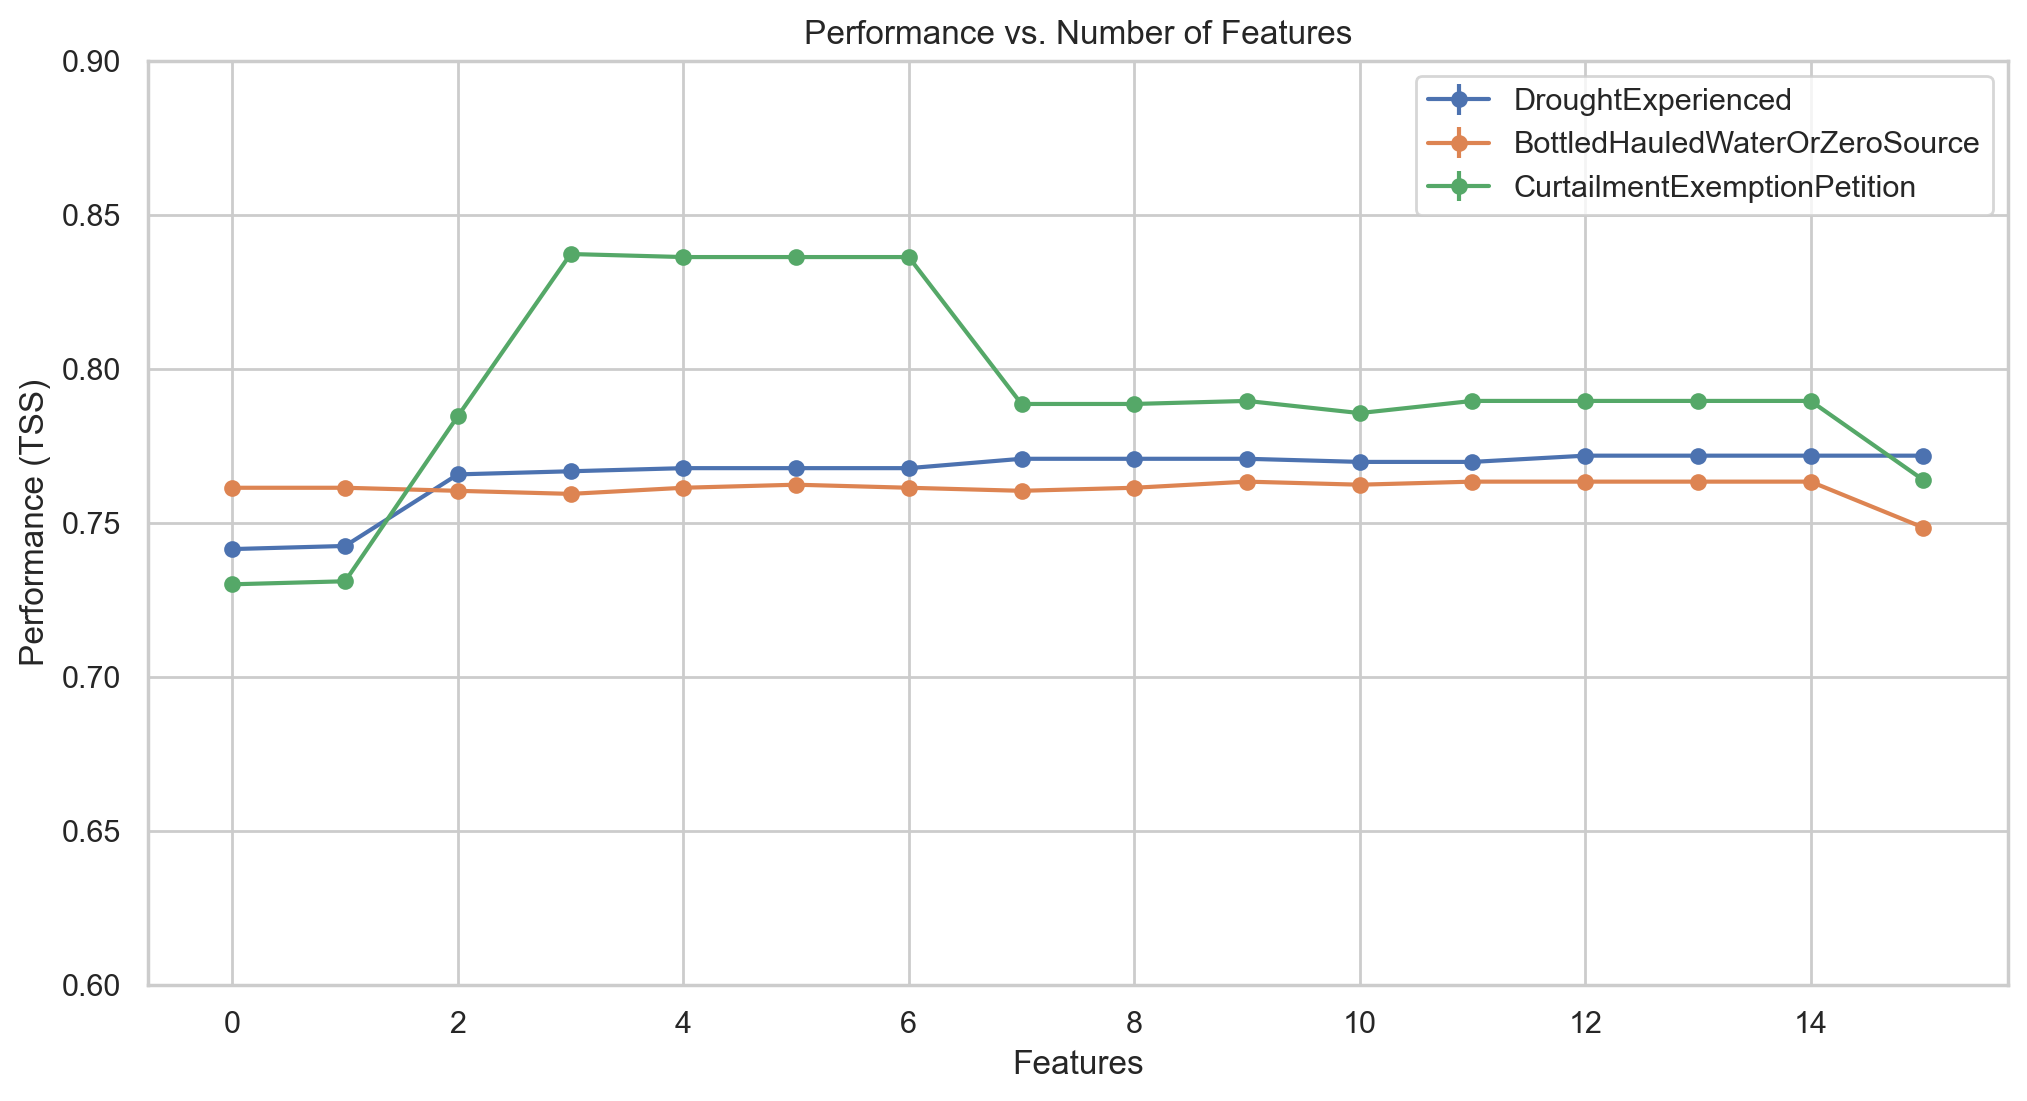

In [281]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(np.arange(len(df_TSS['TSS Scores'][0])),(df_TSS['TSS Scores'][0]), yerr=(df_TSS['TSS Standard Deviation'][0]), 
            marker=".", markersize=10, label=df_TSS['Outcome Label'][0])
ax.errorbar(np.arange(len(df_TSS['TSS Scores'][1])),(df_TSS['TSS Scores'][1]), yerr=(df_TSS['TSS Standard Deviation'][1]), 
            marker=".", markersize=10, label=df_TSS['Outcome Label'][1])
ax.errorbar(np.arange(len(df_TSS['TSS Scores'][2])),(df_TSS['TSS Scores'][2]), yerr=(df_TSS['TSS Standard Deviation'][2]), 
            marker=".", markersize=10, label=df_TSS['Outcome Label'][2])
ax.set_xlabel('Features')
ax.set_ylabel('Performance (TSS)')
ax.set_title('Performance vs. Number of Features')
ax.set_ylim([0.6, 0.9])
ax.legend()
#fig.savefig('performancevsfeaturesvslabel_TSS_svm.png', dpi=300, transparent=True, bbox_inches='tight')

It appears that the model performs as well with the top three features as it does with all 15.